# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 1, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 4,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'shift_polynomial': False,
        
        'border_min': 0.2, # defines an intervall. Value is randomly chosen and defines the minimum gap between x_min / x_max and the outermost stationary points => two values (left and right gap will be generated per variable)
        'border_max': 0.4,
        'lower_degree_prob': 0.5, # probability that the degree of the whole polynomial will be reduced
        'a_random_prob': 0.5, # probability that a random generated function is used without adjustement
                
        'global_stationary_prob': 1, # probability that all variables are used for adjustement (0 recommended for higher number of variables)
        'bulge_min': 1, # bulge_min and bulge_max define an intervall of how much the function is bulged
        'bulge_max': 4,
        'min_variables_used': 2, # defines an Intervall of how many variables are used to get stationary points and therefore adjust the function
        'max_variables_used': 6,
        'max_monomials': 7, # maximum number of monomials, before adjusting the function (monomial of degree 0 is always defined, but is included in this number)
        'max_monomials_random': 10, #maximum number of monomials for random generated functions
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0,
        'dropout_output': 0,
        'epochs': 2000, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [2048, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': 2, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        'max_optimization_minutes': 30,
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': True,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': True,
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

import random 

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.4.3'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2, --tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 4
[[3], [2], [1], [0]]


In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  10


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense2048-output_10_drop0e2000b256_custom/lnets_50000_20-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_3_negd_0_prob_0_spars_4_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_50000_20-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_3_negd_0_prob_0_spars_4_amin_-1_amax_1_xdist_uniform_noise_normal_0


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   41.4s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,3-target,2-target,1-target,0-target,3-lstsq_lambda,2-lstsq_lambda,1-lstsq_lambda,0-lstsq_lambda,3-lstsq_target,2-lstsq_target,1-lstsq_target,0-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60
33553,1373158606,0.047,0.040,0.339,0.505,0.005,-0.009,0.422,0.489,0.047,0.040,0.339,0.505,-0.011,-0.275,0.296,0.176,0.358,0.282,0.245,-0.361,0.139,0.367,0.441,-0.107,-0.023,0.299,0.278,0.423,0.110,0.419,0.463,0.438,0.000,0.000,-0.002,-0.001,0.134,0.134,-0.002,0.000,-0.001,0.091,-0.010,0.000,0.000,-0.003,0.136,-0.008,0.132,0.141,0.133,0.138,-0.309,-0.436,-0.299,-0.294,0.365,0.405,-0.104,-0.495,-0.319,0.052,-0.135,-0.428,-0.442,-0.126,0.326,-0.228,0.637,0.219,0.408,0.266,0.126
9427,1373158606,-0.383,0.736,-0.337,0.589,0.002,-0.003,0.083,0.525,-0.383,0.736,-0.337,0.589,-0.011,-0.275,0.334,0.214,0.315,0.240,0.283,-0.361,0.178,0.318,0.479,-0.107,-0.023,0.337,0.235,0.461,0.068,0.374,0.421,0.394,0.000,0.000,-0.002,-0.001,0.150,0.150,-0.001,0.000,-0.000,0.077,-0.005,0.000,0.000,-0.002,0.153,-0.005,0.150,0.157,0.148,0.153,-0.309,-0.436,-0.346,-0.347,0.343,0.389,-0.154,-0.495,-0.380,0.016,-0.180,-0.428,-0.442,-0.173,0.310,-0.273,0.651,0.196,0.382,0.242,0.141
199,1373158606,-0.216,-0.516,-0.499,-0.033,-0.206,-0.532,-0.493,-0.033,-0.216,-0.516,-0.499,-0.033,-0.011,-0.275,0.515,0.387,0.153,0.085,0.455,-0.361,0.334,0.619,0.696,-0.107,-0.023,0.530,0.084,0.670,0.012,0.277,0.251,0.257,0.000,0.000,-0.082,-0.186,-0.023,-0.088,-0.275,0.000,-0.281,-0.451,-0.007,0.000,0.000,-0.175,-0.086,-0.000,-0.026,-0.071,-0.038,-0.036,-0.309,-0.436,-0.535,-0.616,0.113,0.211,-0.455,-0.495,-0.749,-0.404,-0.377,-0.428,-0.442,-0.407,0.130,-0.470,0.480,-0.056,0.160,0.012,-0.034
12447,1373158606,0.957,-0.893,-0.418,0.426,0.006,-0.009,-0.529,0.419,0.957,-0.893,-0.418,0.426,-0.011,-0.275,0.399,0.272,0.248,0.172,0.350,-0.361,0.232,0.459,0.550,-0.107,-0.023,0.405,0.167,0.530,-0.004,0.309,0.353,0.328,0.000,0.000,-0.004,-0.002,0.128,0.130,-0.003,0.000,-0.002,-0.004,-0.007,0.000,0.000,-0.004,0.130,-0.007,0.139,0.124,0.127,0.125,-0.309,-0.436,-0.412,-0.408,0.278,0.330,-0.218,-0.495,-0.438,-0.083,-0.248,-0.428,-0.442,-0.239,0.251,-0.341,0.668,0.127,0.314,0.173,0.129
39489,1373158606,-0.500,0.755,0.504,0.403,-0.176,0.196,0.784,0.367,-0.500,0.755,0.504,0.403,-0.011,-0.275,0.194,0.147,0.393,0.317,0.172,-0.361,0.128,0.419,0.409,-0.107,-0.023,0.250,0.314,0.388,0.144,0.457,0.497,0.474,0.000,0.000,-0.149,-0.118,0.099,0.099,-0.133,0.000,-0.107,0.038,0.000,0.000,0.000,-0.001,0.100,0.000,0.098,0.103,0.099,0.101,-0.309,-0.436,-0.276,-0.357,0.375,0.412,-0.108,-0.495,-0.409,0.074,-0.086,-0.428,-0.442,-0.024,0.332,-0.180,0.623,0.232,0.423,0.280,0.095


In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,3-target,2-target,1-target,0-target,3-lstsq_lambda,2-lstsq_lambda,1-lstsq_lambda,0-lstsq_lambda,3-lstsq_target,2-lstsq_target,1-lstsq_target,0-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60
count,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000
mean,1373158606.000,0.000,0.005,0.002,-0.000,0.018,0.016,-0.024,0.005,0.000,0.005,0.002,-0.000,-0.011,-0.275,0.332,0.215,0.321,0.250,0.306,-0.361,0.180,0.489,0.518,-0.107,-0.023,0.364,0.249,0.474,0.079,0.434,0.429,0.430,0.000,0.000,0.014,-0.013,0.010,-0.001,-0.021,0.000,-0.018,-0.066,0.029,0.000,0.000,-0.006,-0.014,0.038,0.015,-0.023,0.043,0.020,-0.309,-0.436,-0.412,-0.469,0.368,0.436,-0.226,-0.495,-0.524,-0.003,-0.185,-0.428,-0.442,-0.212,0.371,-0.305,0.695,0.159,0.384,0.220,-0.006
std,0.000,0.577,0.579,0.576,0.578,0.494,0.461,0.582,0.552,0.577,0.579,0.576,0.578,0.000,0.000,0.126,0.128,0.130,0.132,0.153,0.000,0.130,0.236,0.147,0.000,0.000,0.148,0.137,0.124,0.132,0.179,0.133,0.149,0.000,0.000,0.151,0.177,0.155,0.167,0.195,0.000,0.185,0.306,0.150,0.000,0.000,0.181,0.187,0.128,0.152,0.215,0.113,0.147,0.000,0.000,0.134,0.192,0.152,0.181,0.265,0.000,0.221,0.334,0.244,0.000,0.000,0.265,0.202,0.162,0.258,0.327,0.125,0.243,0.154
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.405,-1.078,-1.394,-1.005,-1.000,-1.000,-1.000,-1.000,-0.011,-0.275,-0.049,-0.225,-0.086,-0.169,-0.141,-0.361,-0.277,-0.099,0.130,-0.107,-0.023,-0.064,-0.185,0.106,-0.312,-0.040,0.040,-0.004,0.000,0.000,-0.452,-0.479,-0.457,-0.522,-0.741,0.000,-0.518,-1.044,-0.892,0.000,0.000,-0.804,-0.541,-0.534,-0.442,-0.881,-0.451,-0.758,-0.309,-0.436,-1.110,-1.315,-1.311,0.132,-1.147,-0.495,-1.723,-1.504,-0.653,-0.428,-0.442,-0.875,0.033,-0.720,0.405,-1.720,-1.005,-1.738,-0.504
25%,1373158606.000,-0.502,-0.500,-0.495,-0.503,-0.259,-0.265,-0.519,-0.462,-0.502,-0.500,-0.495,-0.503,-0.011,-0.275,0.253,0.101,0.239,0.157,0.210,-0.361,0.082,0.344,0.425,-0.107,-0.023,0.275,0.151,0.399,0.012,0.320,0.347,0.331,0.000,0.000,-0.134,-0.106,-0.113,-0.098,-0.150,0.000,-0.089,-0.321,-0.010,0.000,0.000,-0.152,-0.096,-0.008,-0.026,-0.120,-0.007,-0.013,-0.309,-0.436,-0.466,-0.513,0.272,0.320,-0.294,-0.495,-0.570,-0.131,-0.283,-0.428,-0.442,-0.295,0.241,-0.378,0.480,0.118,0.307,0.166,-0.152
50%,1373158606.000,0.005,0.007,0.007,-0.003,-0.000,0.001,-0.030,-0.003,0.005,0.007,0.007,-0.003,-0.011,-0.275,0.335,0.214,0.321,0.250,0.292,-0.361,0.175,0.427,0.495,-0.107,-0.023,0.349,0.246,0.468,0.026,0.402,0.424,0.411,0.000,0.000,-0.000,-0.001,-0.000,-0.000,-0.001,0.000,-0.001,0.015,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.001,-0.001,0.000,-0.000,-0.309,-0.436,-0.403,-0.427,0.351,0.403,-0.222,-0.495,-0.466,-0.041,-0.215,-0.428,-0.442,-0.230,0.325,-0.310,0.628,0.199,0.379,0.242,-0.002
75%,1373158606.000,0.499,0.509,0.502,0.503,0.325,0.323,0.475,0.475,0.499,0.509,0.502,0.503,-0.011,-0.275,0.411,0.294,0.399,0.331,0.380,-0.361,0.259,0.592,0.579,-0.107,-0.023,0.430,0.333,0.543,0.140,0.502,0.501,0.501,0.000,0.000,0.147,0.144,0.141,0.141,0.144,0.000,0.142,0.171,0.142,0.0

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.24457676],
       [0.19267431],
       [0.71539711],
       [0.13782812],
       [0.94373167],
       [0.85158305],
       [0.19021396],
       [0.00893767],
       [0.91506872],
       [0.50437039]])

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[0.59131193],
       [0.57244897],
       [0.78575999],
       [0.55291176],
       [0.90085733],
       [0.85241354],
       [0.5715642 ],
       [0.50833553],
       [0.88548255],
       [0.69260138]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            _, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 74)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 74)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 74)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,3-target,2-target,1-target,0-target,3-lstsq_lambda,2-lstsq_lambda,1-lstsq_lambda,0-lstsq_lambda,3-lstsq_target,2-lstsq_target,1-lstsq_target,0-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60
9901,1373158606,-0.327,0.619,0.918,-0.537,-0.292,0.577,0.930,-0.538,-0.327,0.619,0.918,-0.537,-0.011,-0.275,0.203,0.073,0.487,0.411,0.174,-0.361,0.081,0.555,0.371,-0.107,-0.023,0.225,0.413,0.340,0.236,0.547,0.589,0.572,0.000,0.000,0.239,0.174,-0.006,-0.004,0.206,0.000,-0.092,-0.203,0.210,0.000,0.000,0.214,-0.004,0.232,-0.002,-0.094,-0.008,-0.020,-0.309,-0.436,-0.328,-0.306,0.458,0.501,-0.125,-0.495,-0.305,0.186,-0.119,-0.428,-0.442,-0.137,0.422,-0.224,0.751,0.307,0.502,0.357,-0.259
5910,1373158606,0.437,-0.791,-0.791,-0.593,0.364,-0.665,-0.852,-0.586,0.437,-0.791,-0.791,-0.593,-0.011,-0.275,0.421,0.292,0.159,0.135,0.371,-0.361,0.252,0.461,0.574,-0.107,-0.023,0.427,0.134,0.554,0.011,0.542,0.339,0.313,0.000,0.000,0.151,0.151,-0.139,-0.111,0.158,0.000,0.151,0.179,0.155,0.000,0.000,0.156,-0.107,0.152,-0.026,-0.165,-0.001,-0.001,-0.309,-0.436,-0.465,-0.466,0.219,0.306,-0.274,-0.495,-0.499,-0.138,-0.297,-0.428,-0.442,-0.293,0.225,-0.391,0.480,-0.416,0.244,0.094,-0.143
18619,1373158606,0.270,-0.369,0.066,0.068,0.078,-0.139,0.002,0.071,0.270,-0.369,0.066,0.068,-0.011,-0.275,0.332,0.202,0.300,0.224,0.278,-0.361,0.160,0.349,0.482,-0.107,-0.023,0.335,0.220,0.464,0.053,0.359,0.405,0.379,0.000,0.000,-0.004,-0.014,0.021,0.021,-0.004,0.000,-0.026,-0.010,-0.006,0.000,0.000,-0.004,0.021,-0.006,0.021,0.020,0.021,0.021,-0.309,-0.436,-0.343,-0.332,0.279,0.314,-0.147,-0.495,-0.360,-0.013,-0.183,-0.428,-0.442,-0.171,0.234,-0.276,0.515,0.137,0.328,0.185,0.021
33312,1373158606,0.440,-0.619,0.605,0.145,0.148,-0.266,0.500,0.150,0.440,-0.619,0.605,0.145,-0.011,-0.275,0.284,0.157,0.347,0.271,0.231,-0.361,0.072,0.362,0.440,-0.107,-0.023,0.288,0.267,0.421,0.100,0.408,0.452,0.427,0.000,0.000,-0.033,-0.032,0.043,0.043,-0.044,0.000,-0.075,-0.043,-0.013,0.000,0.000,-0.039,0.043,-0.009,0.043,0.044,0.043,0.043,-0.309,-0.436,-0.291,-0.280,0.324,0.358,-0.096,-0.495,-0.301,0.037,-0.134,-0.428,-0.442,-0.119,0.278,-0.227,0.557,0.181,0.373,0.230,0.043
47430,1373158606,0.672,0.871,-0.668,-0.189,0.693,0.833,-0.649,-0.192,0.672,0.871,-0.668,-0.189,-0.011,-0.275,0.306,0.173,0.533,0.475,0.267,-0.361,0.129,0.702,0.474,-0.107,-0.023,0.323,0.479,0.444,0.349,0.615,0.652,0.636,0.000,0.000,0.075,0.077,-0.332,-0.342,0.065,0.000,0.078,-0.120,0.066,0.000,0.000,0.067,-0.388,0.072,-0.315,-0.325,-0.194,-0.271,-0.309,-0.436,-0.310,-0.313,0.790,0.909,-0.119,-0.495,-0.349,0.369,-0.146,-0.428,-0.442,-0.138,0.900,-0.239,1.429,0.602,0.665,0.601,-0.082


In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,3-target,2-target,1-target,0-target,3-lstsq_lambda,2-lstsq_lambda,1-lstsq_lambda,0-lstsq_lambda,3-lstsq_target,2-lstsq_target,1-lstsq_target,0-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60
7038,1373158606,-0.989,-0.035,-0.980,0.646,-0.959,-0.075,-0.966,0.645,-0.989,-0.035,-0.980,0.646,-0.011,-0.275,0.581,0.507,0.035,-0.060,0.583,-0.361,0.474,0.685,0.811,-0.107,-0.023,0.612,-0.067,0.783,-0.243,0.216,0.151,0.161,0.000,0.000,-0.160,-0.387,0.206,0.217,-0.382,0.000,-0.405,-0.382,-0.011,0.000,0.000,-0.272,0.217,-0.003,0.244,0.126,0.201,0.175,-0.309,-0.436,-0.628,-0.945,0.213,0.334,-0.692,-0.495,-1.029,-0.502,-0.489,-0.428,-0.442,-0.572,0.257,-0.582,0.846,-0.013,0.197,0.049,0.218
30770,1373158606,0.629,-0.845,-0.341,0.188,0.155,-0.275,-0.507,0.196,0.629,-0.845,-0.341,0.188,-0.011,-0.275,0.407,0.275,0.232,0.156,0.354,-0.361,0.235,0.440,0.558,-0.107,-0.023,0.411,0.152,0.539,0.009,0.294,0.337,0.312,0.000,0.000,-0.001,-0.029,0.084,0.084,-0.009,0.000,-0.037,-0.001,-0.005,0.000,0.000,-0.001,0.083,-0.004,-0.028,0.079,0.085,0.082,-0.309,-0.436,-0.417,-0.407,0.227,0.268,-0.221,-0.495,-0.436,-0.087,-0.255,-0.428,-0.442,-0.244,0.188,-0.349,0.477,0.081,0.271,0.129,0.088
41342,1373158606,0.525,0.040,0.725,-0.409,0.511,0.062,0.715,-0.408,0.525,0.040,0.725,-0.409,-0.011,-0.275,0.145,0.011,0.475,0.432,0.129,-0.361,0.076,0.595,0.333,-0.107,-0.023,0.180,0.432,0.289,0.315,0.637,0.655,0.647,0.000,0.000,0.202,0.190,-0.131,-0.206,0.157,0.000,-0.088,-0.437,0.162,0.000,0.000,0.167,-0.269,0.192,-0.268,-0.004,-0.004,-0.002,-0.309,-0.436,-0.272,-0.317,0.468,0.626,-0.067,-0.495,-0.300,0.404,-0.056,-0.428,-0.442,-0.077,0.610,-0.163,1.150,0.383,0.571,0.430,-0.228
21084,1373158606,-0.777,-0.243,0.164,-0.426,-0.014,0.024,-0.739,-0.223,-0.777,-0.243,0.164,-0.426,-0.011,-0.275,0.410,0.281,0.233,0.157,0.358,-0.361,0.241,0.440,0.561,-0.107,-0.023,0.414,0.153,0.542,0.012,0.293,0.335,0.311,0.000,0.000,0.063,0.063,-0.005,-0.001,0.064,0.000,0.063,0.070,0.064,0.000,0.000,0.064,-0.002,0.063,-0.026,-0.014,-0.011,-0.012,-0.309,-0.436,-0.424,-0.416,0.199,0.230,-0.229,-0.495,-0.444,-0.094,-0.262,-0.428,-0.442,-0.251,0.148,-0.356,0.480,0.057,0.250,0.106,-0.061
47211,1373158606,0.505,0.230,-0.332,-0.317,0.494,0.242,-0.334,-0.318,0.505,0.230,-0.332,-0.317,-0.011,-0.275,0.208,0.073,0.405,0.351,0.155,-0.361,0.031,0.350,0.368,-0.107,-0.023,0.215,0.355,0.344,0.243,0.480,0.516,0.499,0.000,0.000,0.121,0.123,-0.248,-0.251,0.119,0.000,0.125,0.078,0.115,0.000,0.000,0.118,-0.283,0.118,-0.215,-0.244,-0.123,-0.200,-0.309,-0.436,-0.307,-0.351,0.597,0.704,-0.128,-0.495,-0.407,0.038,-0.116,-0.428,-0.442,-0.133,0.664,-0.213,1.162,0.414,0.473,0.414,-0.123


In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,3-target,2-target,1-target,0-target,3-lstsq_lambda,2-lstsq_lambda,1-lstsq_lambda,0-lstsq_lambda,3-lstsq_target,2-lstsq_target,1-lstsq_target,0-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60
35587,1373158606,-0.423,0.605,-0.763,0.593,0.000,-0.001,-0.530,0.574,-0.423,0.605,-0.763,0.593,-0.011,-0.275,0.407,0.282,0.247,0.170,0.360,-0.361,0.244,0.469,0.557,-0.107,-0.023,0.414,0.165,0.537,-0.005,0.305,0.353,0.326,0.000,0.000,-0.001,-0.001,0.165,0.168,-0.001,0.000,-0.000,-0.001,-0.001,0.000,0.000,-0.001,0.171,-0.001,0.178,0.166,0.162,0.164,-0.309,-0.436,-0.420,-0.420,0.315,0.374,-0.228,-0.495,-0.453,-0.088,-0.253,-0.428,-0.442,-0.247,0.297,-0.347,0.727,0.160,0.342,0.204,0.161
32681,1373158606,0.573,0.425,0.696,-0.089,0.559,0.448,0.686,-0.089,0.573,0.425,0.696,-0.089,-0.011,-0.275,0.152,0.103,0.561,0.487,0.130,-0.361,0.084,0.801,0.380,-0.107,-0.023,0.240,0.498,0.304,0.347,0.661,0.707,0.708,0.000,0.000,-0.152,-0.103,-0.108,-0.243,-0.130,0.000,-0.086,-0.596,-0.028,0.000,0.000,-0.136,-0.314,-0.057,-0.298,-0.238,-0.004,-0.004,-0.309,-0.436,-0.218,-0.274,0.546,0.694,-0.012,-0.495,-0.316,0.521,0.040,-0.428,-0.442,0.119,0.675,-0.073,1.190,0.463,0.616,0.477,-0.087
40971,1373158606,-0.738,-0.737,0.350,-0.071,-0.781,-0.661,0.310,-0.065,-0.738,-0.737,0.350,-0.071,-0.011,-0.275,0.556,0.453,0.170,0.089,0.530,-0.361,0.423,0.686,0.690,-0.107,-0.023,0.572,0.095,0.687,0.011,0.298,0.271,0.267,0.000,0.000,-0.259,-0.369,-0.000,-0.000,-0.389,0.000,-0.377,-0.447,-0.243,0.000,0.000,-0.323,-0.000,-0.156,-0.027,-0.045,-0.000,-0.000,-0.309,-0.436,-0.728,-0.927,0.142,0.185,-0.686,-0.495,-1.010,-0.541,-0.483,-0.428,-0.442,-0.613,0.104,-0.542,0.479,-0.067,0.185,0.040,-0.056
21022,1373158606,-0.385,-0.915,-0.257,0.785,-0.370,-0.938,-0.250,0.785,-0.385,-0.915,-0.257,0.785,-0.011,-0.275,0.569,0.436,0.060,-0.023,0.531,-0.361,0.394,0.641,0.733,-0.107,-0.023,0.575,-0.035,0.727,-0.199,0.117,0.177,0.145,0.000,0.000,-0.188,-0.292,0.208,0.214,-0.299,0.000,-0.339,-0.493,-0.130,0.000,0.000,-0.263,0.220,-0.024,0.221,0.208,0.199,0.203,-0.309,-0.436,-0.679,-0.834,0.350,0.457,-0.602,-0.495,-0.933,-0.535,-0.447,-0.428,-0.442,-0.561,0.386,-0.542,0.857,0.166,0.324,0.199,0.198
6403,1373158606,-0.526,-0.885,-0.241,-0.955,-0.682,-0.635,-0.355,-0.939,-0.526,-0.885,-0.241,-0.955,-0.011,-0.275,0.309,0.176,0.132,0.098,0.255,-0.361,0.135,0.349,0.465,-0.107,-0.023,0.314,0.096,0.445,0.012,1.022,0.430,0.941,0.000,0.000,0.241,0.244,-0.132,-0.098,0.254,0.000,0.244,0.283,0.247,0.000,0.000,0.250,-0.096,0.242,-0.026,-0.703,0.000,-0.348,-0.309,-0.436,-0.458,-0.484,0.169,0.229,-0.279,-0.495,-0.526,-0.136,-0.272,-0.428,-0.442,-0.287,0.149,-0.366,0.480,-1.232,0.336,-1.012,-0.228


## Interpretation Network Training

In [23]:
#%load_ext autoreload

In [24]:
lambda_net_train_dataset_list[0].weight_list[0].shape

(61,)

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/2000
176/176 [==============================] - 22s 109ms/step - loss: 0.4124 - r2_inet_lambda_fv_loss: 6944.6868 - val_loss: 0.2050 - val_r2_inet_lambda_fv_loss: 105.4875
Epoch 2/2000
176/176 [==============================] - 16s 93ms/step - loss: 0.2114 - r2_inet_lambda_fv_loss: 1806.0803 - val_loss: 0.1943 - val_r2_inet_lambda_fv_loss: 58.7493
Epoch 3/2000
176/176 [==============================] - 17s 98ms/step - loss: 0.1771 - r2_inet_lambda_fv_loss: 38.9518 - val_loss: 0.1275 - val_r2_inet_lambda_fv_loss: 3.3631
Epoch 4/2000
176/176 [==============================] - 17s 99ms/step - loss: 0.1334 - r2_inet_lambda_fv_loss: 7.3986 - val_loss: 0.1249 - val_r2_inet_lambda_fv_loss: 3.3056
Epoch 5/2000
176/176 [==============================] - 19s 106ms/step - loss: 0.1297 - r2_inet_lambda_fv_loss: 4.5248 - val_loss: 0.1233 - val_r2_inet_lambda_fv_loss: 3

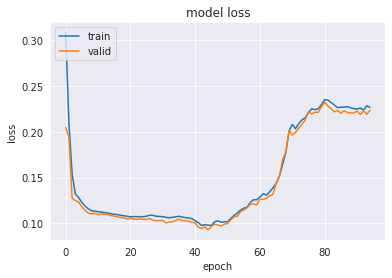

In [25]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [26]:
model_list[-1].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 61)]         0                                            
__________________________________________________________________________________________________
hidden1_2048 (Dense)            (None, 2048)         126976      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 2048)         0           hidden1_2048[0][0]               
__________________________________________________________________________________________________
output_coeff_2 (Dense)          (None, 2)            4098        activation1_relu[0][0]           
______________________________________________________________________________________________

In [27]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [28]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [29]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [33]:
%autoreload 2
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
---- Tuning the basis functions ----
---- Tuning the basis functions ----
---- Tuning the basis functions ----
---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.459
Iteration: 1 	--- Loss: 0.435
Iteration: 2 	--- Loss: 0.448
Iteration: 3 	--- Loss: 0.396
Iteration: 4 	--- Loss: 0.341
Iteration: 5 	--- Loss: 0.333
Iteration: 6 	--- Loss: 0.364
Iteration: 7 	--- Loss: 0.300
Iteration: 8 	--- Loss: 0.313
Iteration: 9 	--- Loss: 0.289
Iteration: 10 	--- Loss: 0.352
Iteration: 11 	--- Loss: 0.262
Iteration: 12 	--- Loss: 0.261
Iteration: 13 	--- Loss: 0.244
Iteration: 14 	--- Loss: 0.263
Iteration: 15 	--- Loss: 0.256
Iteration: 16 	--- Loss: 0.240
Iteration: 17 	--- Loss: 0.250
Iteration: 18 	--- Loss: 0.251
Iteration: 19 	--- Loss: 0.247
Iteration: 20 	--- Loss: 0.249
Iteration: 21 	--- Loss: 0.282
Iteration: 22 	--- Loss: 0.246
Iteration: 23 	--- Loss: 0.272
Iteration: 24 	--- Loss: 0.216
Iteration: 25 	--- Loss: 0.231
Iteration: 26 	--- 

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.213
Iteration: 261 	--- Loss: 0.226
Iteration: 262 	--- Loss: 0.220
Iteration: 263 	--- Loss: 0.195
Iteration: 264 	--- Loss: 0.243
Iteration: 265 	--- Loss: 0.219
Iteration: 266 	--- Loss: 0.248
Iteration: 267 	--- Loss: 0.222
Iteration: 268 	--- Loss: 0.225
Iteration: 269 	--- Loss: 0.230
Iteration: 270 	--- Loss: 0.205
Iteration: 271 	--- Loss: 0.232
Iteration: 272 	--- Loss: 0.210
Iteration: 273 	--- Loss: 0.229
Iteration: 274 	--- Loss: 0.227
Iteration: 275 	--- Loss: 0.229
Iteration: 276 	--- Loss: 0.226
Iteration: 277 	--- Loss: 0.214
Iteration: 278 	--- Loss: 0.229
Iteration: 279 	--- Loss: 0.227
Iteration: 280 	--- Loss: 0.202
Iteration: 281 	--- Loss: 0.209
Iteration: 282 	--- Loss: 0.206
Iteration: 283 	--- Loss: 0.216
Iteration: 284 	--- Loss: 0.189
Iteration: 285 	--- Loss: 0.233
Iteration: 286 	--- Loss: 0.217
Iteration: 287 	--- Loss: 0.211
Iteration: 288 	--- Loss: 0.202
Iteration: 289 	--- Loss: 0.214
Iteration: 290 	--- Loss: 0.208
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 2.482
Iteration: 261 	--- Loss: 2.551
Iteration: 262 	--- Loss: 2.460
Iteration: 263 	--- Loss: 2.394
Iteration: 264 	--- Loss: 2.521
Iteration: 265 	--- Loss: 2.354
Iteration: 266 	--- Loss: 2.427
Iteration: 267 	--- Loss: 2.618
Iteration: 268 	--- Loss: 2.541
Iteration: 269 	--- Loss: 2.381
Iteration: 270 	--- Loss: 2.380
Iteration: 271 	--- Loss: 2.429
Iteration: 272 	--- Loss: 2.509
Iteration: 273 	--- Loss: 2.419
Iteration: 274 	--- Loss: 2.303
Iteration: 275 	--- Loss: 2.452
Iteration: 276 	--- Loss: 2.452
Iteration: 277 	--- Loss: 2.411
Iteration: 278 	--- Loss: 2.518
Iteration: 279 	--- Loss: 2.607
Iteration: 280 	--- Loss: 2.552
Iteration: 281 	--- Loss: 2.393
Iteration: 282 	--- Loss: 2.398
Iteration: 283 	--- Loss: 2.384
Iteration: 284 	--- Loss: 2.405
Iteration: 285 	--- Loss: 2.491
Iteration: 286 	--- Loss: 2.436
Iteration: 287 	--- Loss: 2.471
Iteration: 288 	--- Loss: 2.503
Iteration: 289 	--- Loss: 2.482
Iteration: 290 	--- Loss: 2.461
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.057
Iteration: 261 	--- Loss: 0.057
Iteration: 262 	--- Loss: 0.059
Iteration: 263 	--- Loss: 0.060
Iteration: 264 	--- Loss: 0.055
Iteration: 265 	--- Loss: 0.059
Iteration: 266 	--- Loss: 0.055
Iteration: 267 	--- Loss: 0.058
Iteration: 268 	--- Loss: 0.051
Iteration: 269 	--- Loss: 0.051
Iteration: 270 	--- Loss: 0.053
Iteration: 271 	--- Loss: 0.056
Iteration: 272 	--- Loss: 0.054
Iteration: 273 	--- Loss: 0.055
Iteration: 274 	--- Loss: 0.051
Iteration: 275 	--- Loss: 0.055
Iteration: 276 	--- Loss: 0.055
Iteration: 277 	--- Loss: 0.055
Iteration: 278 	--- Loss: 0.054
Iteration: 279 	--- Loss: 0.052
Iteration: 280 	--- Loss: 0.056
Iteration: 281 	--- Loss: 0.051
Iteration: 282 	--- Loss: 0.054
Iteration: 283 	--- Loss: 0.059
Iteration: 284 	--- Loss: 0.052
Iteration: 285 	--- Loss: 0.050
Iteration: 286 	--- Loss: 0.056
Iteration: 287 	--- Loss: 0.056
Iteration: 288 	--- Loss: 0.059
Iteration: 289 	--- Loss: 0.050
Iteration: 290 	--- Loss: 0.053
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.218
Iteration: 261 	--- Loss: 0.228
Iteration: 262 	--- Loss: 0.228
Iteration: 263 	--- Loss: 0.223
Iteration: 264 	--- Loss: 0.231
Iteration: 265 	--- Loss: 0.227
Iteration: 266 	--- Loss: 0.224
Iteration: 267 	--- Loss: 0.242
Iteration: 268 	--- Loss: 0.238
Iteration: 269 	--- Loss: 0.227
Iteration: 270 	--- Loss: 0.220
Iteration: 271 	--- Loss: 0.227
Iteration: 272 	--- Loss: 0.221
Iteration: 273 	--- Loss: 0.232
Iteration: 274 	--- Loss: 0.223
Iteration: 275 	--- Loss: 0.221
Iteration: 276 	--- Loss: 0.220
Iteration: 277 	--- Loss: 0.221
Iteration: 278 	--- Loss: 0.238
Iteration: 279 	--- Loss: 0.230
Iteration: 280 	--- Loss: 0.232
Iteration: 281 	--- Loss: 0.238
Iteration: 282 	--- Loss: 0.239
Iteration: 283 	--- Loss: 0.210
Iteration: 284 	--- Loss: 0.236
Iteration: 285 	--- Loss: 0.234
Iteration: 286 	--- Loss: 0.217
Iteration: 287 	--- Loss: 0.226
Iteration: 288 	--- Loss: 0.230
Iteration: 289 	--- Loss: 0.220
Iteration: 290 	--- Loss: 0.227
Iterati

 80%|████████  | 8/10 [00:09<00:02,  1.17s/it][Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  1.1min

 10%|█         | 1/10 [00:00<00:08,  1.06it/s]

---- Tuning the basis functions ----


 50%|█████     | 5/10 [00:05<00:05,  1.14s/it]]

---- Tuning the basis functions ----



 80%|████████  | 8/10 [00:09<00:02,  1.20s/it]

---- Tuning the basis functions ----


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

---- Tuning the basis functions ----



  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 0.685
Iteration: 1 	--- Loss: 0.537
Iteration: 2 	--- Loss: 0.516
Iteration: 3 	--- Loss: 0.534
Iteration: 4 	--- Loss: 0.491
Iteration: 5 	--- Loss: 0.439
Iteration: 6 	--- Loss: 0.482
Iteration: 7 	--- Loss: 0.452
Iteration: 8 	--- Loss: 0.460
Iteration: 9 	--- Loss: 0.471
Iteration: 10 	--- Loss: 0.441
Iteration: 11 	--- Loss: 0.449
Iteration: 12 	--- Loss: 0.436
Iteration: 13 	--- Loss: 0.392
Iteration: 14 	--- Loss: 0.433
Iteration: 15 	--- Loss: 0.412
Iteration: 16 	--- Loss: 0.397
Iteration: 17 	--- Loss: 0.377
Iteration: 18 	--- Loss: 0.364
Iteration: 19 	--- Loss: 0.421
Iteration: 20 	--- Loss: 0.400
Iteration: 21 	--- Loss: 0.422
Iteration: 22 	--- Loss: 0.367
Iteration: 23 	--- Loss: 0.378
Iteration: 24 	--- Loss: 0.396
Iteration: 25 	--- Loss: 0.387
Iteration: 26 	--- Loss: 0.389
Iteration: 27 	--- Loss: 0.365
Iteration: 28 	--- Loss: 0.331
Iteration: 29 	--- Loss: 0.403
Iteration: 30 	--- Loss: 0.413
Iteration: 31 	--- Loss: 0.365
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.373
Iteration: 261 	--- Loss: 0.383
Iteration: 262 	--- Loss: 0.362
Iteration: 263 	--- Loss: 0.395
Iteration: 264 	--- Loss: 0.393
Iteration: 265 	--- Loss: 0.363
Iteration: 266 	--- Loss: 0.376
Iteration: 267 	--- Loss: 0.377
Iteration: 268 	--- Loss: 0.392
Iteration: 269 	--- Loss: 0.374
Iteration: 270 	--- Loss: 0.350
Iteration: 271 	--- Loss: 0.390
Iteration: 272 	--- Loss: 0.371
Iteration: 273 	--- Loss: 0.400
Iteration: 274 	--- Loss: 0.365
Iteration: 275 	--- Loss: 0.332
Iteration: 276 	--- Loss: 0.337
Iteration: 277 	--- Loss: 0.357
Iteration: 278 	--- Loss: 0.370
Iteration: 279 	--- Loss: 0.394
Iteration: 280 	--- Loss: 0.361
Iteration: 281 	--- Loss: 0.360
Iteration: 282 	--- Loss: 0.381
Iteration: 283 	--- Loss: 0.331
Iteration: 284 	--- Loss: 0.368
Iteration: 285 	--- Loss: 0.374
Iteration: 286 	--- Loss: 0.381
Iteration: 287 	--- Loss: 0.363
Iteration: 288 	--- Loss: 0.374
Iteration: 289 	--- Loss: 0.341
Iteration: 290 	--- Loss: 0.364
Iterati

 30%|███       | 3/10 [00:02<00:07,  1.03s/it]

Iteration: 0 	--- Loss: 0.379
Iteration: 1 	--- Loss: 0.365
Iteration: 2 	--- Loss: 0.379
Iteration: 3 	--- Loss: 0.353
Iteration: 4 	--- Loss: 0.362
Iteration: 5 	--- Loss: 0.404
Iteration: 6 	--- Loss: 0.343
Iteration: 7 	--- Loss: 0.379
Iteration: 8 	--- Loss: 0.374
Iteration: 9 	--- Loss: 0.373
Iteration: 10 	--- Loss: 0.389
Iteration: 11 	--- Loss: 0.348
Iteration: 12 	--- Loss: 0.336
Iteration: 13 	--- Loss: 0.328
Iteration: 14 	--- Loss: 0.350
Iteration: 15 	--- Loss: 0.320
Iteration: 16 	--- Loss: 0.346
Iteration: 17 	--- Loss: 0.374
Iteration: 18 	--- Loss: 0.326
Iteration: 19 	--- Loss: 0.367
Iteration: 20 	--- Loss: 0.337
Iteration: 21 	--- Loss: 0.323
Iteration: 22 	--- Loss: 0.331
Iteration: 23 	--- Loss: 0.336
Iteration: 24 	--- Loss: 0.349
Iteration: 25 	--- Loss: 0.335
Iteration: 26 	--- Loss: 0.353
Iteration: 27 	--- Loss: 0.327
Iteration: 28 	--- Loss: 0.366
Iteration: 29 	--- Loss: 0.362
Iteration: 30 	--- Loss: 0.338
Iteration: 31 	--- Loss: 0.345
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.065
Iteration: 261 	--- Loss: 0.066
Iteration: 262 	--- Loss: 0.067
Iteration: 263 	--- Loss: 0.066
Iteration: 264 	--- Loss: 0.065
Iteration: 265 	--- Loss: 0.067
Iteration: 266 	--- Loss: 0.067
Iteration: 267 	--- Loss: 0.067
Iteration: 268 	--- Loss: 0.065
Iteration: 269 	--- Loss: 0.067
Iteration: 270 	--- Loss: 0.068
Iteration: 271 	--- Loss: 0.067
Iteration: 272 	--- Loss: 0.067
Iteration: 273 	--- Loss: 0.067
Iteration: 274 	--- Loss: 0.066
Iteration: 275 	--- Loss: 0.067
Iteration: 276 	--- Loss: 0.066
Iteration: 277 	--- Loss: 0.066
Iteration: 278 	--- Loss: 0.067
Iteration: 279 	--- Loss: 0.067
Iteration: 280 	--- Loss: 0.065
Iteration: 281 	--- Loss: 0.069
Iteration: 282 	--- Loss: 0.066
Iteration: 283 	--- Loss: 0.067
Iteration: 284 	--- Loss: 0.066
Iteration: 285 	--- Loss: 0.067
Iteration: 286 	--- Loss: 0.065
Iteration: 287 	--- Loss: 0.066
Iteration: 288 	--- Loss: 0.066
Iteration: 289 	--- Loss: 0.068
Iteration: 290 	--- Loss: 0.068
Iterati

100%|██████████| 1/1 [00:50<00:00, 50.62s/it]]


Iteration: 260 	--- Loss: 0.907
Iteration: 261 	--- Loss: 0.867
Iteration: 262 	--- Loss: 0.891
Iteration: 263 	--- Loss: 0.874
Iteration: 264 	--- Loss: 0.914
Iteration: 265 	--- Loss: 0.847
Iteration: 266 	--- Loss: 0.871
Iteration: 267 	--- Loss: 0.916
Iteration: 268 	--- Loss: 0.879
Iteration: 269 	--- Loss: 0.890
Iteration: 270 	--- Loss: 0.880
Iteration: 271 	--- Loss: 0.842
Iteration: 272 	--- Loss: 0.929
Iteration: 273 	--- Loss: 0.894
Iteration: 274 	--- Loss: 0.811
Iteration: 275 	--- Loss: 0.887
Iteration: 276 	--- Loss: 0.872
Iteration: 277 	--- Loss: 0.921
Iteration: 278 	--- Loss: 0.832
Iteration: 279 	--- Loss: 0.868
Iteration: 280 	--- Loss: 0.886
Iteration: 281 	--- Loss: 0.895
Iteration: 282 	--- Loss: 0.913
Iteration: 283 	--- Loss: 0.906
Iteration: 284 	--- Loss: 0.919
Iteration: 285 	--- Loss: 0.908
Iteration: 286 	--- Loss: 0.890
Iteration: 287 	--- Loss: 0.958
Iteration: 288 	--- Loss: 0.913
Iteration: 289 	--- Loss: 0.906
Iteration: 290 	--- Loss: 0.837
Iterati


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


 40%|████      | 4/10 [00:04<00:06,  1.11s/it]


Iteration: 260 	--- Loss: 0.379
Iteration: 261 	--- Loss: 0.381
Iteration: 262 	--- Loss: 0.353
Iteration: 263 	--- Loss: 0.426
Iteration: 264 	--- Loss: 0.389
Iteration: 265 	--- Loss: 0.383
Iteration: 266 	--- Loss: 0.383
Iteration: 267 	--- Loss: 0.432
Iteration: 268 	--- Loss: 0.353
Iteration: 269 	--- Loss: 0.393
Iteration: 270 	--- Loss: 0.413
Iteration: 271 	--- Loss: 0.374
Iteration: 272 	--- Loss: 0.381
Iteration: 273 	--- Loss: 0.416
Iteration: 274 	--- Loss: 0.417
Iteration: 275 	--- Loss: 0.414
Iteration: 276 	--- Loss: 0.355
Iteration: 277 	--- Loss: 0.387
Iteration: 278 	--- Loss: 0.382
Iteration: 279 	--- Loss: 0.368
Iteration: 280 	--- Loss: 0.389
Iteration: 281 	--- Loss: 0.423
Iteration: 282 	--- Loss: 0.393
Iteration: 283 	--- Loss: 0.361
Iteration: 284 	--- Loss: 0.368
Iteration: 285 	--- Loss: 0.401
Iteration: 286 	--- Loss: 0.403
Iteration: 287 	--- Loss: 0.400
Iteration: 288 	--- Loss: 0.416
Iteration: 289 	--- Loss: 0.383
Iteration: 290 	--- Loss: 0.385
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.237
Iteration: 261 	--- Loss: 0.228
Iteration: 262 	--- Loss: 0.227
Iteration: 263 	--- Loss: 0.245
Iteration: 264 	--- Loss: 0.245
Iteration: 265 	--- Loss: 0.245
Iteration: 266 	--- Loss: 0.235
Iteration: 267 	--- Loss: 0.244
Iteration: 268 	--- Loss: 0.233
Iteration: 269 	--- Loss: 0.228
Iteration: 270 	--- Loss: 0.248
Iteration: 271 	--- Loss: 0.250
Iteration: 272 	--- Loss: 0.253
Iteration: 273 	--- Loss: 0.241
Iteration: 274 	--- Loss: 0.226
Iteration: 275 	--- Loss: 0.236
Iteration: 276 	--- Loss: 0.227
Iteration: 277 	--- Loss: 0.242
Iteration: 278 	--- Loss: 0.248
Iteration: 279 	--- Loss: 0.226
Iteration: 280 	--- Loss: 0.248
Iteration: 281 	--- Loss: 0.223
Iteration: 282 	--- Loss: 0.231
Iteration: 283 	--- Loss: 0.232
Iteration: 284 	--- Loss: 0.252
Iteration: 285 	--- Loss: 0.231
Iteration: 286 	--- Loss: 0.243
Iteration: 287 	--- Loss: 0.247
Iteration: 288 	--- Loss: 0.265
Iteration: 289 	--- Loss: 0.240
Iteration: 290 	--- Loss: 0.233
Iterati

 90%|█████████ | 9/10 [00:10<00:01,  1.16s/it]

Iteration: 0 	--- Loss: 0.589
Iteration: 1 	--- Loss: 0.510
Iteration: 2 	--- Loss: 0.514
Iteration: 3 	--- Loss: 0.452
Iteration: 4 	--- Loss: 0.480
Iteration: 5 	--- Loss: 0.384
Iteration: 6 	--- Loss: 0.364
Iteration: 7 	--- Loss: 0.369
Iteration: 8 	--- Loss: 0.385
Iteration: 9 	--- Loss: 0.417
Iteration: 10 	--- Loss: 0.355
Iteration: 11 	--- Loss: 0.338
Iteration: 12 	--- Loss: 0.334
Iteration: 13 	--- Loss: 0.300
Iteration: 14 	--- Loss: 0.331
Iteration: 15 	--- Loss: 0.284
Iteration: 16 	--- Loss: 0.322
Iteration: 17 	--- Loss: 0.265
Iteration: 18 	--- Loss: 0.295
Iteration: 19 	--- Loss: 0.312
Iteration: 20 	--- Loss: 0.306
Iteration: 21 	--- Loss: 0.303
Iteration: 22 	--- Loss: 0.312
Iteration: 23 	--- Loss: 0.314
Iteration: 24 	--- Loss: 0.322
Iteration: 25 	--- Loss: 0.327
Iteration: 26 	--- Loss: 0.299
Iteration: 27 	--- Loss: 0.280
Iteration: 28 	--- Loss: 0.310
Iteration: 29 	--- Loss: 0.296
Iteration: 30 	--- Loss: 0.280
Iteration: 31 	--- Loss: 0.305
Iteration: 32 	---

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 1.905
Iteration: 1 	--- Loss: 1.865
Iteration: 2 	--- Loss: 1.654
Iteration: 3 	--- Loss: 1.483
Iteration: 4 	--- Loss: 1.554
Iteration: 5 	--- Loss: 1.417
Iteration: 6 	--- Loss: 1.386
Iteration: 7 	--- Loss: 1.395
Iteration: 8 	--- Loss: 1.389
Iteration: 9 	--- Loss: 1.380
Iteration: 10 	--- Loss: 1.418
Iteration: 11 	--- Loss: 1.337
Iteration: 12 	--- Loss: 1.385
Iteration: 13 	--- Loss: 1.393
Iteration: 14 	--- Loss: 1.356
Iteration: 15 	--- Loss: 1.311
Iteration: 16 	--- Loss: 1.302
Iteration: 17 	--- Loss: 1.350
Iteration: 18 	--- Loss: 1.335
Iteration: 19 	--- Loss: 1.329
Iteration: 20 	--- Loss: 1.358
Iteration: 21 	--- Loss: 1.289
Iteration: 22 	--- Loss: 1.333
Iteration: 23 	--- Loss: 1.308
Iteration: 24 	--- Loss: 1.331
Iteration: 25 	--- Loss: 1.378
Iteration: 26 	--- Loss: 1.306
Iteration: 27 	--- Loss: 1.331
Iteration: 28 	--- Loss: 1.345
Iteration: 29 	--- Loss: 1.284
Iteration: 30 	--- Loss: 1.222
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.301
Iteration: 261 	--- Loss: 0.278
Iteration: 262 	--- Loss: 0.303
Iteration: 263 	--- Loss: 0.292
Iteration: 264 	--- Loss: 0.282
Iteration: 265 	--- Loss: 0.287
Iteration: 266 	--- Loss: 0.295
Iteration: 267 	--- Loss: 0.258
Iteration: 268 	--- Loss: 0.294
Iteration: 269 	--- Loss: 0.263
Iteration: 270 	--- Loss: 0.295
Iteration: 271 	--- Loss: 0.284
Iteration: 272 	--- Loss: 0.287
Iteration: 273 	--- Loss: 0.279
Iteration: 274 	--- Loss: 0.305
Iteration: 275 	--- Loss: 0.283
Iteration: 276 	--- Loss: 0.279
Iteration: 277 	--- Loss: 0.277
Iteration: 278 	--- Loss: 0.276
Iteration: 279 	--- Loss: 0.308
Iteration: 280 	--- Loss: 0.290
Iteration: 281 	--- Loss: 0.296
Iteration: 282 	--- Loss: 0.260
Iteration: 283 	--- Loss: 0.287
Iteration: 284 	--- Loss: 0.285
Iteration: 285 	--- Loss: 0.313
Iteration: 286 	--- Loss: 0.277
Iteration: 287 	--- Loss: 0.279
Iteration: 288 	--- Loss: 0.243
Iteration: 289 	--- Loss: 0.302
Iteration: 290 	--- Loss: 0.290
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 1.272
Iteration: 261 	--- Loss: 1.316
Iteration: 262 	--- Loss: 1.297
Iteration: 263 	--- Loss: 1.331
Iteration: 264 	--- Loss: 1.242
Iteration: 265 	--- Loss: 1.294
Iteration: 266 	--- Loss: 1.313
Iteration: 267 	--- Loss: 1.250
Iteration: 268 	--- Loss: 1.302
Iteration: 269 	--- Loss: 1.338
Iteration: 270 	--- Loss: 1.291
Iteration: 271 	--- Loss: 1.250
Iteration: 272 	--- Loss: 1.362
Iteration: 273 	--- Loss: 1.260
Iteration: 274 	--- Loss: 1.358
Iteration: 275 	--- Loss: 1.264
Iteration: 276 	--- Loss: 1.305
Iteration: 277 	--- Loss: 1.315
Iteration: 278 	--- Loss: 1.330
Iteration: 279 	--- Loss: 1.267
Iteration: 280 	--- Loss: 1.297
Iteration: 281 	--- Loss: 1.382
Iteration: 282 	--- Loss: 1.391
Iteration: 283 	--- Loss: 1.248
Iteration: 284 	--- Loss: 1.293
Iteration: 285 	--- Loss: 1.309
Iteration: 286 	--- Loss: 1.235
Iteration: 287 	--- Loss: 1.206
Iteration: 288 	--- Loss: 1.294
Iteration: 289 	--- Loss: 1.318
Iteration: 290 	--- Loss: 1.298
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.947
Iteration: 1 	--- Loss: 0.825
Iteration: 2 	--- Loss: 0.735
Iteration: 3 	--- Loss: 0.730
Iteration: 4 	--- Loss: 0.657
Iteration: 5 	--- Loss: 0.629
Iteration: 6 	--- Loss: 0.605
Iteration: 7 	--- Loss: 0.552
Iteration: 8 	--- Loss: 0.568
Iteration: 9 	--- Loss: 0.562
Iteration: 10 	--- Loss: 0.532
Iteration: 11 	--- Loss: 0.523
Iteration: 12 	--- Loss: 0.506
Iteration: 13 	--- Loss: 0.502
Iteration: 14 	--- Loss: 0.480
Iteration: 15 	--- Loss: 0.498
Iteration: 16 	--- Loss: 0.490
Iteration: 17 	--- Loss: 0.500
Iteration: 18 	--- Loss: 0.499
Iteration: 19 	--- Loss: 0.491
Iteration: 20 	--- Loss: 0.468
Iteration: 21 	--- Loss: 0.482
Iteration: 22 	--- Loss: 0.473
Iteration: 23 	--- Loss: 0.467
Iteration: 24 	--- Loss: 0.464
Iteration: 25 	--- Loss: 0.475
Iteration: 26 	--- Loss: 0.474
Iteration: 27 	--- Loss: 0.474
Iteration: 28 	--- Loss: 0.468
Iteration: 29 	--- Loss: 0.467
Iteration: 30 	--- Loss: 0.478
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.461
Iteration: 261 	--- Loss: 0.471
Iteration: 262 	--- Loss: 0.466
Iteration: 263 	--- Loss: 0.467
Iteration: 264 	--- Loss: 0.463
Iteration: 265 	--- Loss: 0.469
Iteration: 266 	--- Loss: 0.452
Iteration: 267 	--- Loss: 0.473
Iteration: 268 	--- Loss: 0.472
Iteration: 269 	--- Loss: 0.454
Iteration: 270 	--- Loss: 0.469
Iteration: 271 	--- Loss: 0.468
Iteration: 272 	--- Loss: 0.457
Iteration: 273 	--- Loss: 0.467
Iteration: 274 	--- Loss: 0.474
Iteration: 275 	--- Loss: 0.470
Iteration: 276 	--- Loss: 0.455
Iteration: 277 	--- Loss: 0.464
Iteration: 278 	--- Loss: 0.468
Iteration: 279 	--- Loss: 0.475
Iteration: 280 	--- Loss: 0.460
Iteration: 281 	--- Loss: 0.471
Iteration: 282 	--- Loss: 0.465
Iteration: 283 	--- Loss: 0.466
Iteration: 284 	--- Loss: 0.474
Iteration: 285 	--- Loss: 0.469
Iteration: 286 	--- Loss: 0.460
Iteration: 287 	--- Loss: 0.460
Iteration: 288 	--- Loss: 0.457
Iteration: 289 	--- Loss: 0.457
Iteration: 290 	--- Loss: 0.476
Iterati

100%|██████████| 10/10 [00:16<00:00,  1.63s/it]

---- Tuning the basis functions ----



  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.333
Iteration: 261 	--- Loss: 0.327
Iteration: 262 	--- Loss: 0.304
Iteration: 263 	--- Loss: 0.306
Iteration: 264 	--- Loss: 0.295
Iteration: 265 	--- Loss: 0.378
Iteration: 266 	--- Loss: 0.382
Iteration: 267 	--- Loss: 0.488
Iteration: 268 	--- Loss: 0.302
Iteration: 269 	--- Loss: 0.325
Iteration: 270 	--- Loss: 0.310
Iteration: 271 	--- Loss: 0.300
Iteration: 272 	--- Loss: 0.325
Iteration: 273 	--- Loss: 0.280
Iteration: 274 	--- Loss: 0.305
Iteration: 275 	--- Loss: 0.305
Iteration: 276 	--- Loss: 0.300
Iteration: 277 	--- Loss: 0.269
Iteration: 278 	--- Loss: 0.286
Iteration: 279 	--- Loss: 0.293
Iteration: 280 	--- Loss: 0.311
Iteration: 281 	--- Loss: 0.314
Iteration: 282 	--- Loss: 0.334
Iteration: 283 	--- Loss: 0.336
Iteration: 284 	--- Loss: 0.335
Iteration: 285 	--- Loss: 0.314
Iteration: 286 	--- Loss: 0.341
Iteration: 287 	--- Loss: 0.360
Iteration: 288 	--- Loss: 0.299
Iteration: 289 	--- Loss: 0.280
Iteration: 290 	--- Loss: 0.301
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.301
Iteration: 1 	--- Loss: 0.294
Iteration: 2 	--- Loss: 0.306
Iteration: 3 	--- Loss: 0.301
Iteration: 4 	--- Loss: 0.296
Iteration: 5 	--- Loss: 0.280
Iteration: 6 	--- Loss: 0.295
Iteration: 7 	--- Loss: 0.250
Iteration: 8 	--- Loss: 0.239
Iteration: 9 	--- Loss: 0.283
Iteration: 10 	--- Loss: 0.239
Iteration: 11 	--- Loss: 0.256
Iteration: 12 	--- Loss: 0.241
Iteration: 13 	--- Loss: 0.243
Iteration: 14 	--- Loss: 0.216
Iteration: 15 	--- Loss: 0.233
Iteration: 16 	--- Loss: 0.217
Iteration: 17 	--- Loss: 0.216
Iteration: 18 	--- Loss: 0.215
Iteration: 19 	--- Loss: 0.209
Iteration: 20 	--- Loss: 0.205
Iteration: 21 	--- Loss: 0.200
Iteration: 22 	--- Loss: 0.219
Iteration: 23 	--- Loss: 0.197
Iteration: 24 	--- Loss: 0.193
Iteration: 25 	--- Loss: 0.206
Iteration: 26 	--- Loss: 0.195
Iteration: 27 	--- Loss: 0.191
Iteration: 28 	--- Loss: 0.163
Iteration: 29 	--- Loss: 0.144
Iteration: 30 	--- Loss: 0.165
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.776
Iteration: 261 	--- Loss: 0.760
Iteration: 262 	--- Loss: 0.771
Iteration: 263 	--- Loss: 0.765
Iteration: 264 	--- Loss: 0.757
Iteration: 265 	--- Loss: 0.775
Iteration: 266 	--- Loss: 0.763
Iteration: 267 	--- Loss: 0.760
Iteration: 268 	--- Loss: 0.765
Iteration: 269 	--- Loss: 0.752
Iteration: 270 	--- Loss: 0.767
Iteration: 271 	--- Loss: 0.770
Iteration: 272 	--- Loss: 0.758
Iteration: 273 	--- Loss: 0.756
Iteration: 274 	--- Loss: 0.786
Iteration: 275 	--- Loss: 0.766
Iteration: 276 	--- Loss: 0.785
Iteration: 277 	--- Loss: 0.773
Iteration: 278 	--- Loss: 0.768
Iteration: 279 	--- Loss: 0.752
Iteration: 280 	--- Loss: 0.781
Iteration: 281 	--- Loss: 0.777
Iteration: 282 	--- Loss: 0.766
Iteration: 283 	--- Loss: 0.785
Iteration: 284 	--- Loss: 0.775
Iteration: 285 	--- Loss: 0.781
Iteration: 286 	--- Loss: 0.774
Iteration: 287 	--- Loss: 0.771
Iteration: 288 	--- Loss: 0.767
Iteration: 289 	--- Loss: 0.765
Iteration: 290 	--- Loss: 0.777
Iterati

100%|██████████| 10/10 [00:14<00:00,  1.50s/it][Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:  6.8min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.081
Iteration: 261 	--- Loss: 0.089
Iteration: 262 	--- Loss: 0.084
Iteration: 263 	--- Loss: 0.081
Iteration: 264 	--- Loss: 0.085
Iteration: 265 	--- Loss: 0.084
Iteration: 266 	--- Loss: 0.083
Iteration: 267 	--- Loss: 0.079
Iteration: 268 	--- Loss: 0.084
Iteration: 269 	--- Loss: 0.079
Iteration: 270 	--- Loss: 0.084
Iteration: 271 	--- Loss: 0.084
Iteration: 272 	--- Loss: 0.078
Iteration: 273 	--- Loss: 0.085
Iteration: 274 	--- Loss: 0.084
Iteration: 275 	--- Loss: 0.080
Iteration: 276 	--- Loss: 0.085
Iteration: 277 	--- Loss: 0.090
Iteration: 278 	--- Loss: 0.077
Iteration: 279 	--- Loss: 0.077
Iteration: 280 	--- Loss: 0.086
Iteration: 281 	--- Loss: 0.079
Iteration: 282 	--- Loss: 0.084
Iteration: 283 	--- Loss: 0.083
Iteration: 284 	--- Loss: 0.081
Iteration: 285 	--- Loss: 0.083
Iteration: 286 	--- Loss: 0.076
Iteration: 287 	--- Loss: 0.085
Iteration: 288 	--- Loss: 0.084
Iteration: 289 	--- Loss: 0.079
Iteration: 290 	--- Loss: 0.078
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.787
Iteration: 1 	--- Loss: 0.700
Iteration: 2 	--- Loss: 0.643
Iteration: 3 	--- Loss: 0.601
Iteration: 4 	--- Loss: 0.550
Iteration: 5 	--- Loss: 0.519
Iteration: 6 	--- Loss: 0.494
Iteration: 7 	--- Loss: 0.478
Iteration: 8 	--- Loss: 0.462
Iteration: 9 	--- Loss: 0.446
Iteration: 10 	--- Loss: 0.428
Iteration: 11 	--- Loss: 0.421
Iteration: 12 	--- Loss: 0.421
Iteration: 13 	--- Loss: 0.409
Iteration: 14 	--- Loss: 0.408
Iteration: 15 	--- Loss: 0.414
Iteration: 16 	--- Loss: 0.385
Iteration: 17 	--- Loss: 0.391
Iteration: 18 	--- Loss: 0.385
Iteration: 19 	--- Loss: 0.383
Iteration: 20 	--- Loss: 0.378
Iteration: 21 	--- Loss: 0.380
Iteration: 22 	--- Loss: 0.380
Iteration: 23 	--- Loss: 0.384
Iteration: 24 	--- Loss: 0.375
Iteration: 25 	--- Loss: 0.378
Iteration: 26 	--- Loss: 0.374
Iteration: 27 	--- Loss: 0.368
Iteration: 28 	--- Loss: 0.377
Iteration: 29 	--- Loss: 0.365
Iteration: 30 	--- Loss: 0.370
Iteration: 3

100%|██████████| 1/1 [01:29<00:00, 89.95s/it]



Iteration: 260 	--- Loss: 0.371
Iteration: 261 	--- Loss: 0.380
Iteration: 262 	--- Loss: 0.386
Iteration: 263 	--- Loss: 0.363
Iteration: 264 	--- Loss: 0.374
Iteration: 265 	--- Loss: 0.375
Iteration: 266 	--- Loss: 0.359
Iteration: 267 	--- Loss: 0.360
Iteration: 268 	--- Loss: 0.382
Iteration: 269 	--- Loss: 0.371
Iteration: 270 	--- Loss: 0.365
Iteration: 271 	--- Loss: 0.351
Iteration: 272 	--- Loss: 0.366
Iteration: 273 	--- Loss: 0.380
Iteration: 274 	--- Loss: 0.362
Iteration: 275 	--- Loss: 0.369
Iteration: 276 	--- Loss: 0.363
Iteration: 277 	--- Loss: 0.375
Iteration: 278 	--- Loss: 0.370
Iteration: 279 	--- Loss: 0.384
Iteration: 280 	--- Loss: 0.369
Iteration: 281 	--- Loss: 0.369
Iteration: 282 	--- Loss: 0.366
Iteration: 283 	--- Loss: 0.376
Iteration: 284 	--- Loss: 0.376
Iteration: 285 	--- Loss: 0.362
Iteration: 286 	--- Loss: 0.371
Iteration: 287 	--- Loss: 0.355
Iteration: 288 	--- Loss: 0.367
Iteration: 289 	--- Loss: 0.361
Iteration: 290 	--- Loss: 0.362
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.764
Iteration: 261 	--- Loss: 0.798
Iteration: 262 	--- Loss: 0.782
Iteration: 263 	--- Loss: 0.753
Iteration: 264 	--- Loss: 0.762
Iteration: 265 	--- Loss: 0.803
Iteration: 266 	--- Loss: 0.790
Iteration: 267 	--- Loss: 0.801
Iteration: 268 	--- Loss: 0.766
Iteration: 269 	--- Loss: 0.772
Iteration: 270 	--- Loss: 0.785
Iteration: 271 	--- Loss: 0.782
Iteration: 272 	--- Loss: 0.766
Iteration: 273 	--- Loss: 0.757
Iteration: 274 	--- Loss: 0.799
Iteration: 275 	--- Loss: 0.784
Iteration: 276 	--- Loss: 0.758
Iteration: 277 	--- Loss: 0.777
Iteration: 278 	--- Loss: 0.795
Iteration: 279 	--- Loss: 0.800
Iteration: 280 	--- Loss: 0.790
Iteration: 281 	--- Loss: 0.766
Iteration: 282 	--- Loss: 0.778
Iteration: 283 	--- Loss: 0.801
Iteration: 284 	--- Loss: 0.780
Iteration: 285 	--- Loss: 0.783
Iteration: 286 	--- Loss: 0.789
Iteration: 287 	--- Loss: 0.778
Iteration: 288 	--- Loss: 0.771
Iteration: 289 	--- Loss: 0.778
Iteration: 290 	--- Loss: 0.782
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.159
Iteration: 1 	--- Loss: 0.158
Iteration: 2 	--- Loss: 0.124
Iteration: 3 	--- Loss: 0.141
Iteration: 4 	--- Loss: 0.142
Iteration: 5 	--- Loss: 0.120
Iteration: 6 	--- Loss: 0.110
Iteration: 7 	--- Loss: 0.083
Iteration: 8 	--- Loss: 0.090
Iteration: 9 	--- Loss: 0.083
Iteration: 10 	--- Loss: 0.074
Iteration: 11 	--- Loss: 0.066
Iteration: 12 	--- Loss: 0.068
Iteration: 13 	--- Loss: 0.060
Iteration: 14 	--- Loss: 0.063
Iteration: 15 	--- Loss: 0.060
Iteration: 16 	--- Loss: 0.054
Iteration: 17 	--- Loss: 0.053
Iteration: 18 	--- Loss: 0.054
Iteration: 19 	--- Loss: 0.053
Iteration: 20 	--- Loss: 0.047
Iteration: 21 	--- Loss: 0.043
Iteration: 22 	--- Loss: 0.043
Iteration: 23 	--- Loss: 0.048
Iteration: 24 	--- Loss: 0.046
Iteration: 25 	--- Loss: 0.039
Iteration: 26 	--- Loss: 0.042
Iteration: 27 	--- Loss: 0.041
Iteration: 28 	--- Loss: 0.038
Iteration: 29 	--- Loss: 0.039
Iteration: 30 	--- Loss: 0.039
Iteration: 3

100%|██████████| 1/1 [01:30<00:00, 90.35s/it]



Iteration: 260 	--- Loss: 0.022
Iteration: 261 	--- Loss: 0.023
Iteration: 262 	--- Loss: 0.023
Iteration: 263 	--- Loss: 0.024
Iteration: 264 	--- Loss: 0.023
Iteration: 265 	--- Loss: 0.022
Iteration: 266 	--- Loss: 0.024
Iteration: 267 	--- Loss: 0.025
Iteration: 268 	--- Loss: 0.024
Iteration: 269 	--- Loss: 0.025
Iteration: 270 	--- Loss: 0.026
Iteration: 271 	--- Loss: 0.025
Iteration: 272 	--- Loss: 0.022
Iteration: 273 	--- Loss: 0.024
Iteration: 274 	--- Loss: 0.022
Iteration: 275 	--- Loss: 0.025
Iteration: 276 	--- Loss: 0.024
Iteration: 277 	--- Loss: 0.026
Iteration: 278 	--- Loss: 0.025
Iteration: 279 	--- Loss: 0.025
Iteration: 280 	--- Loss: 0.025
Iteration: 281 	--- Loss: 0.026
Iteration: 282 	--- Loss: 0.026
Iteration: 283 	--- Loss: 0.023
Iteration: 284 	--- Loss: 0.026
Iteration: 285 	--- Loss: 0.025
Iteration: 286 	--- Loss: 0.025
Iteration: 287 	--- Loss: 0.024
Iteration: 288 	--- Loss: 0.024
Iteration: 289 	--- Loss: 0.024
Iteration: 290 	--- Loss: 0.024
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.57s/it][Parallel(n_jobs=5)]: Done  18 tasks      | elapsed: 10.3min

  0%|          | 0/10 [00:00<?, ?it/s]

---- Tuning the basis functions ----

Iteration: 260 	--- Loss: 0.020
Iteration: 261 	--- Loss: 0.021
Iteration: 262 	--- Loss: 0.024
Iteration: 263 	--- Loss: 0.024
Iteration: 264 	--- Loss: 0.024
Iteration: 265 	--- Loss: 0.024
Iteration: 266 	--- Loss: 0.027
Iteration: 267 	--- Loss: 0.031
Iteration: 268 	--- Loss: 0.017
Iteration: 269 	--- Loss: 0.018
Iteration: 270 	--- Loss: 0.020
Iteration: 271 	--- Loss: 0.021
Iteration: 272 	--- Loss: 0.017
Iteration: 273 	--- Loss: 0.019
Iteration: 274 	--- Loss: 0.022
Iteration: 275 	--- Loss: 0.020
Iteration: 276 	--- Loss: 0.020
Iteration: 277 	--- Loss: 0.021
Iteration: 278 	--- Loss: 0.022
Iteration: 279 	--- Loss: 0.025
Iteration: 280 	--- Loss: 0.023
Iteration: 281 	--- Loss: 0.023
Iteration: 282 	--- Loss: 0.024
Iteration: 283 	--- Loss: 0.021
Iteration: 284 	--- Loss: 0.027
Iteration: 285 	--- Loss: 0.026
Iteration: 286 	--- Loss: 0.022
Iteration: 287 	--- Loss: 0.021
Iteration: 288 	--- Loss: 0.020
Iteration: 289 	--- Loss: 0.023
It

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.054
Iteration: 261 	--- Loss: 0.056
Iteration: 262 	--- Loss: 0.056
Iteration: 263 	--- Loss: 0.055
Iteration: 264 	--- Loss: 0.058
Iteration: 265 	--- Loss: 0.054
Iteration: 266 	--- Loss: 0.056
Iteration: 267 	--- Loss: 0.055
Iteration: 268 	--- Loss: 0.057
Iteration: 269 	--- Loss: 0.057
Iteration: 270 	--- Loss: 0.056
Iteration: 271 	--- Loss: 0.057
Iteration: 272 	--- Loss: 0.056
Iteration: 273 	--- Loss: 0.057
Iteration: 274 	--- Loss: 0.059
Iteration: 275 	--- Loss: 0.056
Iteration: 276 	--- Loss: 0.053
Iteration: 277 	--- Loss: 0.057
Iteration: 278 	--- Loss: 0.053
Iteration: 279 	--- Loss: 0.058
Iteration: 280 	--- Loss: 0.055
Iteration: 281 	--- Loss: 0.056
Iteration: 282 	--- Loss: 0.057
Iteration: 283 	--- Loss: 0.059
Iteration: 284 	--- Loss: 0.058
Iteration: 285 	--- Loss: 0.057
Iteration: 286 	--- Loss: 0.058
Iteration: 287 	--- Loss: 0.054
Iteration: 288 	--- Loss: 0.054
Iteration: 289 	--- Loss: 0.057
Iteration: 290 	--- Loss: 0.055
Iterati

100%|██████████| 10/10 [00:27<00:00,  2.71s/it][Parallel(n_jobs=5)]: Done  19 tasks      | elapsed: 10.8min
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed: 10.8min
  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----



  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 3.367
Iteration: 1 	--- Loss: 3.489
Iteration: 2 	--- Loss: 3.615
Iteration: 3 	--- Loss: 3.013
Iteration: 4 	--- Loss: 3.058
Iteration: 5 	--- Loss: 3.022
Iteration: 6 	--- Loss: 2.978
Iteration: 7 	--- Loss: 2.952
Iteration: 8 	--- Loss: 2.985
Iteration: 9 	--- Loss: 2.985
Iteration: 10 	--- Loss: 2.907
Iteration: 11 	--- Loss: 2.842
Iteration: 12 	--- Loss: 2.697
Iteration: 13 	--- Loss: 2.660
Iteration: 14 	--- Loss: 2.806
Iteration: 15 	--- Loss: 2.995
Iteration: 16 	--- Loss: 2.792
Iteration: 17 	--- Loss: 2.818
Iteration: 18 	--- Loss: 2.805
Iteration: 19 	--- Loss: 2.584
Iteration: 20 	--- Loss: 2.695
Iteration: 21 	--- Loss: 2.928
Iteration: 22 	--- Loss: 2.830
Iteration: 23 	--- Loss: 2.848
Iteration: 24 	--- Loss: 2.750
Iteration: 25 	--- Loss: 2.781
Iteration: 26 	--- Loss: 2.739
Iteration: 27 	--- Loss: 2.801
Iteration: 28 	--- Loss: 2.942
Iteration: 29 	--- Loss: 2.833
Iteration: 30 	--- Loss: 2.842
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 2.945
Iteration: 261 	--- Loss: 2.712
Iteration: 262 	--- Loss: 2.691
Iteration: 263 	--- Loss: 2.734
Iteration: 264 	--- Loss: 2.886
Iteration: 265 	--- Loss: 2.759
Iteration: 266 	--- Loss: 2.780
Iteration: 267 	--- Loss: 2.730
Iteration: 268 	--- Loss: 2.679
Iteration: 269 	--- Loss: 2.754
Iteration: 270 	--- Loss: 2.822
Iteration: 271 	--- Loss: 2.828
Iteration: 272 	--- Loss: 2.988
Iteration: 273 	--- Loss: 2.876
Iteration: 274 	--- Loss: 2.793
Iteration: 275 	--- Loss: 2.739
Iteration: 276 	--- Loss: 2.725
Iteration: 277 	--- Loss: 2.773
Iteration: 278 	--- Loss: 2.685
Iteration: 279 	--- Loss: 2.765
Iteration: 280 	--- Loss: 2.911
Iteration: 281 	--- Loss: 2.723
Iteration: 282 	--- Loss: 2.693
Iteration: 283 	--- Loss: 2.746
Iteration: 284 	--- Loss: 2.789
Iteration: 285 	--- Loss: 2.825
Iteration: 286 	--- Loss: 2.808
Iteration: 287 	--- Loss: 2.782
Iteration: 288 	--- Loss: 2.880
Iteration: 289 	--- Loss: 2.848
Iteration: 290 	--- Loss: 2.835
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.010
Iteration: 261 	--- Loss: 0.011
Iteration: 262 	--- Loss: 0.011
Iteration: 263 	--- Loss: 0.011
Iteration: 264 	--- Loss: 0.011
Iteration: 265 	--- Loss: 0.010
Iteration: 266 	--- Loss: 0.011
Iteration: 267 	--- Loss: 0.011
Iteration: 268 	--- Loss: 0.009
Iteration: 269 	--- Loss: 0.009
Iteration: 270 	--- Loss: 0.011
Iteration: 271 	--- Loss: 0.010
Iteration: 272 	--- Loss: 0.009
Iteration: 273 	--- Loss: 0.009
Iteration: 274 	--- Loss: 0.009
Iteration: 275 	--- Loss: 0.009
Iteration: 276 	--- Loss: 0.010
Iteration: 277 	--- Loss: 0.009
Iteration: 278 	--- Loss: 0.010
Iteration: 279 	--- Loss: 0.009
Iteration: 280 	--- Loss: 0.009
Iteration: 281 	--- Loss: 0.009
Iteration: 282 	--- Loss: 0.009
Iteration: 283 	--- Loss: 0.010
Iteration: 284 	--- Loss: 0.008
Iteration: 285 	--- Loss: 0.009
Iteration: 286 	--- Loss: 0.008
Iteration: 287 	--- Loss: 0.009
Iteration: 288 	--- Loss: 0.008
Iteration: 289 	--- Loss: 0.007
Iteration: 290 	--- Loss: 0.009
Iterati

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]

---- Tuning the basis functions ----



  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 2.080
Iteration: 1 	--- Loss: 1.965
Iteration: 2 	--- Loss: 1.902
Iteration: 3 	--- Loss: 1.743
Iteration: 4 	--- Loss: 1.750
Iteration: 5 	--- Loss: 1.639
Iteration: 6 	--- Loss: 1.590
Iteration: 7 	--- Loss: 1.555
Iteration: 8 	--- Loss: 1.698
Iteration: 9 	--- Loss: 1.667
Iteration: 10 	--- Loss: 1.524
Iteration: 11 	--- Loss: 1.525
Iteration: 12 	--- Loss: 1.652
Iteration: 13 	--- Loss: 1.582
Iteration: 14 	--- Loss: 1.592
Iteration: 15 	--- Loss: 1.498
Iteration: 16 	--- Loss: 1.547
Iteration: 17 	--- Loss: 1.524
Iteration: 18 	--- Loss: 1.455
Iteration: 19 	--- Loss: 1.408
Iteration: 20 	--- Loss: 1.474
Iteration: 21 	--- Loss: 1.475
Iteration: 22 	--- Loss: 1.516
Iteration: 23 	--- Loss: 1.462
Iteration: 24 	--- Loss: 1.468
Iteration: 25 	--- Loss: 1.413
Iteration: 26 	--- Loss: 1.482
Iteration: 27 	--- Loss: 1.414
Iteration: 28 	--- Loss: 1.396
Iteration: 29 	--- Loss: 1.335
Iteration: 30 	--- Loss: 1.382
Iteration: 31 	--- Loss: 1.400
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.258
Iteration: 261 	--- Loss: 0.257
Iteration: 262 	--- Loss: 0.259
Iteration: 263 	--- Loss: 0.259
Iteration: 264 	--- Loss: 0.258
Iteration: 265 	--- Loss: 0.259
Iteration: 266 	--- Loss: 0.259
Iteration: 267 	--- Loss: 0.257
Iteration: 268 	--- Loss: 0.256
Iteration: 269 	--- Loss: 0.257
Iteration: 270 	--- Loss: 0.257
Iteration: 271 	--- Loss: 0.257
Iteration: 272 	--- Loss: 0.257
Iteration: 273 	--- Loss: 0.258
Iteration: 274 	--- Loss: 0.258
Iteration: 275 	--- Loss: 0.258
Iteration: 276 	--- Loss: 0.258
Iteration: 277 	--- Loss: 0.258
Iteration: 278 	--- Loss: 0.259
Iteration: 279 	--- Loss: 0.258
Iteration: 280 	--- Loss: 0.258
Iteration: 281 	--- Loss: 0.258
Iteration: 282 	--- Loss: 0.257
Iteration: 283 	--- Loss: 0.257
Iteration: 284 	--- Loss: 0.259
Iteration: 285 	--- Loss: 0.259
Iteration: 286 	--- Loss: 0.259
Iteration: 287 	--- Loss: 0.257
Iteration: 288 	--- Loss: 0.259
Iteration: 289 	--- Loss: 0.258
Iteration: 290 	--- Loss: 0.258
Iterati

100%|██████████| 10/10 [00:30<00:00,  3.05s/it]

---- Tuning the basis functions ----



  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.483
Iteration: 261 	--- Loss: 0.481
Iteration: 262 	--- Loss: 0.490
Iteration: 263 	--- Loss: 0.490
Iteration: 264 	--- Loss: 0.505
Iteration: 265 	--- Loss: 0.477
Iteration: 266 	--- Loss: 0.491
Iteration: 267 	--- Loss: 0.479
Iteration: 268 	--- Loss: 0.480
Iteration: 269 	--- Loss: 0.489
Iteration: 270 	--- Loss: 0.468
Iteration: 271 	--- Loss: 0.488
Iteration: 272 	--- Loss: 0.477
Iteration: 273 	--- Loss: 0.489
Iteration: 274 	--- Loss: 0.488
Iteration: 275 	--- Loss: 0.480
Iteration: 276 	--- Loss: 0.487
Iteration: 277 	--- Loss: 0.497
Iteration: 278 	--- Loss: 0.494
Iteration: 279 	--- Loss: 0.486
Iteration: 280 	--- Loss: 0.464
Iteration: 281 	--- Loss: 0.488
Iteration: 282 	--- Loss: 0.468
Iteration: 283 	--- Loss: 0.483
Iteration: 284 	--- Loss: 0.458
Iteration: 285 	--- Loss: 0.450
Iteration: 286 	--- Loss: 0.474
Iteration: 287 	--- Loss: 0.482
Iteration: 288 	--- Loss: 0.480
Iteration: 289 	--- Loss: 0.488
Iteration: 290 	--- Loss: 0.482
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.52s/it][Parallel(n_jobs=5)]: Done  24 tasks      | elapsed: 12.5min


---- Tuning the basis functions ----



  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.947
Iteration: 1 	--- Loss: 0.843
Iteration: 2 	--- Loss: 0.812
Iteration: 3 	--- Loss: 0.736
Iteration: 4 	--- Loss: 0.694
Iteration: 5 	--- Loss: 0.663
Iteration: 6 	--- Loss: 0.632
Iteration: 7 	--- Loss: 0.593
Iteration: 8 	--- Loss: 0.620
Iteration: 9 	--- Loss: 0.571
Iteration: 10 	--- Loss: 0.572
Iteration: 11 	--- Loss: 0.566
Iteration: 12 	--- Loss: 0.554
Iteration: 13 	--- Loss: 0.532
Iteration: 14 	--- Loss: 0.540
Iteration: 15 	--- Loss: 0.529
Iteration: 16 	--- Loss: 0.550
Iteration: 17 	--- Loss: 0.524
Iteration: 18 	--- Loss: 0.542
Iteration: 19 	--- Loss: 0.521
Iteration: 20 	--- Loss: 0.508
Iteration: 21 	--- Loss: 0.519
Iteration: 22 	--- Loss: 0.505
Iteration: 23 	--- Loss: 0.512
Iteration: 24 	--- Loss: 0.500
Iteration: 25 	--- Loss: 0.513
Iteration: 26 	--- Loss: 0.509
Iteration: 27 	--- Loss: 0.522
Iteration: 28 	--- Loss: 0.518
Iteration: 29 	--- Loss: 0.506
Iteration: 30 	--- Loss: 0.514
Iteration: 3

100%|██████████| 1/1 [01:31<00:00, 91.26s/it]



Iteration: 260 	--- Loss: 0.504
Iteration: 261 	--- Loss: 0.526
Iteration: 262 	--- Loss: 0.512
Iteration: 263 	--- Loss: 0.496
Iteration: 264 	--- Loss: 0.515
Iteration: 265 	--- Loss: 0.492
Iteration: 266 	--- Loss: 0.515
Iteration: 267 	--- Loss: 0.514
Iteration: 268 	--- Loss: 0.535
Iteration: 269 	--- Loss: 0.504
Iteration: 270 	--- Loss: 0.500
Iteration: 271 	--- Loss: 0.488
Iteration: 272 	--- Loss: 0.506
Iteration: 273 	--- Loss: 0.508
Iteration: 274 	--- Loss: 0.491
Iteration: 275 	--- Loss: 0.487
Iteration: 276 	--- Loss: 0.520
Iteration: 277 	--- Loss: 0.528
Iteration: 278 	--- Loss: 0.525
Iteration: 279 	--- Loss: 0.505
Iteration: 280 	--- Loss: 0.503
Iteration: 281 	--- Loss: 0.496
Iteration: 282 	--- Loss: 0.517
Iteration: 283 	--- Loss: 0.484
Iteration: 284 	--- Loss: 0.490
Iteration: 285 	--- Loss: 0.503
Iteration: 286 	--- Loss: 0.521
Iteration: 287 	--- Loss: 0.508
Iteration: 288 	--- Loss: 0.510
Iteration: 289 	--- Loss: 0.492
Iteration: 290 	--- Loss: 0.523
Iterati

 20%|██        | 2/10 [00:02<00:10,  1.36s/it]

Iteration: 0 	--- Loss: 0.823
Iteration: 1 	--- Loss: 0.794
Iteration: 2 	--- Loss: 0.747
Iteration: 3 	--- Loss: 0.720
Iteration: 4 	--- Loss: 0.710
Iteration: 5 	--- Loss: 0.678
Iteration: 6 	--- Loss: 0.670
Iteration: 7 	--- Loss: 0.657
Iteration: 8 	--- Loss: 0.642
Iteration: 9 	--- Loss: 0.605
Iteration: 10 	--- Loss: 0.628
Iteration: 11 	--- Loss: 0.582
Iteration: 12 	--- Loss: 0.590
Iteration: 13 	--- Loss: 0.566
Iteration: 14 	--- Loss: 0.585
Iteration: 15 	--- Loss: 0.563
Iteration: 16 	--- Loss: 0.569
Iteration: 17 	--- Loss: 0.547
Iteration: 18 	--- Loss: 0.550
Iteration: 19 	--- Loss: 0.542
Iteration: 20 	--- Loss: 0.527
Iteration: 21 	--- Loss: 0.531
Iteration: 22 	--- Loss: 0.516
Iteration: 23 	--- Loss: 0.523
Iteration: 24 	--- Loss: 0.511
Iteration: 25 	--- Loss: 0.497
Iteration: 26 	--- Loss: 0.447
Iteration: 27 	--- Loss: 0.455
Iteration: 28 	--- Loss: 0.441
Iteration: 29 	--- Loss: 0.429
Iteration: 30 	--- Loss: 0.402
Iteration: 31 	--- Loss: 0.400
Iteration: 32 	---

100%|██████████| 1/1 [01:25<00:00, 85.16s/it]]



Iteration: 260 	--- Loss: 0.636
Iteration: 261 	--- Loss: 0.637
Iteration: 262 	--- Loss: 0.639
Iteration: 263 	--- Loss: 0.637
Iteration: 264 	--- Loss: 0.637
Iteration: 265 	--- Loss: 0.639
Iteration: 266 	--- Loss: 0.637
Iteration: 267 	--- Loss: 0.638
Iteration: 268 	--- Loss: 0.638
Iteration: 269 	--- Loss: 0.639
Iteration: 270 	--- Loss: 0.638
Iteration: 271 	--- Loss: 0.635
Iteration: 272 	--- Loss: 0.640
Iteration: 273 	--- Loss: 0.640
Iteration: 274 	--- Loss: 0.637
Iteration: 275 	--- Loss: 0.635
Iteration: 276 	--- Loss: 0.636
Iteration: 277 	--- Loss: 0.636
Iteration: 278 	--- Loss: 0.638
Iteration: 279 	--- Loss: 0.636
Iteration: 280 	--- Loss: 0.636
Iteration: 281 	--- Loss: 0.636
Iteration: 282 	--- Loss: 0.639
Iteration: 283 	--- Loss: 0.641
Iteration: 284 	--- Loss: 0.637
Iteration: 285 	--- Loss: 0.636
Iteration: 286 	--- Loss: 0.639
Iteration: 287 	--- Loss: 0.634
Iteration: 288 	--- Loss: 0.637
Iteration: 289 	--- Loss: 0.640
Iteration: 290 	--- Loss: 0.636
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


100%|██████████| 10/10 [00:15<00:00,  1.50s/it][Parallel(n_jobs=5)]: Done  27 tasks      | elapsed: 14.1min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.322
Iteration: 261 	--- Loss: 0.326
Iteration: 262 	--- Loss: 0.312
Iteration: 263 	--- Loss: 0.333
Iteration: 264 	--- Loss: 0.325
Iteration: 265 	--- Loss: 0.331
Iteration: 266 	--- Loss: 0.332
Iteration: 267 	--- Loss: 0.325
Iteration: 268 	--- Loss: 0.327
Iteration: 269 	--- Loss: 0.316
Iteration: 270 	--- Loss: 0.336
Iteration: 271 	--- Loss: 0.310
Iteration: 272 	--- Loss: 0.322
Iteration: 273 	--- Loss: 0.322
Iteration: 274 	--- Loss: 0.325
Iteration: 275 	--- Loss: 0.310
Iteration: 276 	--- Loss: 0.317
Iteration: 277 	--- Loss: 0.329
Iteration: 278 	--- Loss: 0.308
Iteration: 279 	--- Loss: 0.317
Iteration: 280 	--- Loss: 0.326
Iteration: 281 	--- Loss: 0.325
Iteration: 282 	--- Loss: 0.335
Iteration: 283 	--- Loss: 0.317
Iteration: 284 	--- Loss: 0.321
Iteration: 285 	--- Loss: 0.301
Iteration: 286 	--- Loss: 0.320
Iteration: 287 	--- Loss: 0.321
Iteration: 288 	--- Loss: 0.315
Iteration: 289 	--- Loss: 0.321
Iteration: 290 	--- Loss: 0.318
Iterati

 50%|█████     | 5/10 [00:07<00:07,  1.57s/it]



Iteration: 260 	--- Loss: 0.103
Iteration: 261 	--- Loss: 0.107
Iteration: 262 	--- Loss: 0.104
Iteration: 263 	--- Loss: 0.105
Iteration: 264 	--- Loss: 0.104
Iteration: 265 	--- Loss: 0.108
Iteration: 266 	--- Loss: 0.108
Iteration: 267 	--- Loss: 0.106
Iteration: 268 	--- Loss: 0.102
Iteration: 269 	--- Loss: 0.120
Iteration: 270 	--- Loss: 0.105
Iteration: 271 	--- Loss: 0.101
Iteration: 272 	--- Loss: 0.108
Iteration: 273 	--- Loss: 0.096
Iteration: 274 	--- Loss: 0.103
Iteration: 275 	--- Loss: 0.098
Iteration: 276 	--- Loss: 0.101
Iteration: 277 	--- Loss: 0.094
Iteration: 278 	--- Loss: 0.105
Iteration: 279 	--- Loss: 0.098
Iteration: 280 	--- Loss: 0.111
Iteration: 281 	--- Loss: 0.095
Iteration: 282 	--- Loss: 0.106
Iteration: 283 	--- Loss: 0.096
Iteration: 284 	--- Loss: 0.105
Iteration: 285 	--- Loss: 0.104
Iteration: 286 	--- Loss: 0.098
Iteration: 287 	--- Loss: 0.098
Iteration: 288 	--- Loss: 0.107
Iteration: 289 	--- Loss: 0.099
Iteration: 290 	--- Loss: 0.098
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.59s/it][Parallel(n_jobs=5)]: Done  28 tasks      | elapsed: 14.5min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


100%|██████████| 10/10 [00:14<00:00,  1.48s/it][Parallel(n_jobs=5)]: Done  29 tasks      | elapsed: 14.6min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.341
Iteration: 1 	--- Loss: 0.333
Iteration: 2 	--- Loss: 0.322
Iteration: 3 	--- Loss: 0.314
Iteration: 4 	--- Loss: 0.309
Iteration: 5 	--- Loss: 0.306
Iteration: 6 	--- Loss: 0.307
Iteration: 7 	--- Loss: 0.324
Iteration: 8 	--- Loss: 0.295
Iteration: 9 	--- Loss: 0.282
Iteration: 10 	--- Loss: 0.295
Iteration: 11 	--- Loss: 0.269
Iteration: 12 	--- Loss: 0.300
Iteration: 13 	--- Loss: 0.269
Iteration: 14 	--- Loss: 0.287
Iteration: 15 	--- Loss: 0.287
Iteration: 16 	--- Loss: 0.306
Iteration: 17 	--- Loss: 0.263
Iteration: 18 	--- Loss: 0.257
Iteration: 19 	--- Loss: 0.247
Iteration: 20 	--- Loss: 0.285
Iteration: 21 	--- Loss: 0.283
Iteration: 22 	--- Loss: 0.258
Iteration: 23 	--- Loss: 0.253
Iteration: 24 	--- Loss: 0.255
Iteration: 25 	--- Loss: 0.275
Iteration: 26 	--- Loss: 0.268
Iteration: 27 	--- Loss: 0.294
Iteration: 28 	--- Loss: 0.260
Iteration: 29 	--- Loss: 0.274
Iteration: 30 	--- Loss: 0.270
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.241
Iteration: 261 	--- Loss: 0.263
Iteration: 262 	--- Loss: 0.262
Iteration: 263 	--- Loss: 0.241
Iteration: 264 	--- Loss: 0.257
Iteration: 265 	--- Loss: 0.262
Iteration: 266 	--- Loss: 0.270
Iteration: 267 	--- Loss: 0.278
Iteration: 268 	--- Loss: 0.229
Iteration: 269 	--- Loss: 0.260
Iteration: 270 	--- Loss: 0.240
Iteration: 271 	--- Loss: 0.251
Iteration: 272 	--- Loss: 0.243
Iteration: 273 	--- Loss: 0.261
Iteration: 274 	--- Loss: 0.251
Iteration: 275 	--- Loss: 0.240
Iteration: 276 	--- Loss: 0.250
Iteration: 277 	--- Loss: 0.270
Iteration: 278 	--- Loss: 0.258
Iteration: 279 	--- Loss: 0.255
Iteration: 280 	--- Loss: 0.252
Iteration: 281 	--- Loss: 0.241
Iteration: 282 	--- Loss: 0.255
Iteration: 283 	--- Loss: 0.250
Iteration: 284 	--- Loss: 0.255
Iteration: 285 	--- Loss: 0.238
Iteration: 286 	--- Loss: 0.262
Iteration: 287 	--- Loss: 0.253
Iteration: 288 	--- Loss: 0.253
Iteration: 289 	--- Loss: 0.280
Iteration: 290 	--- Loss: 0.255
Iterati

 20%|██        | 2/10 [00:02<00:10,  1.33s/it]

Iteration: 0 	--- Loss: 0.318
Iteration: 1 	--- Loss: 0.309
Iteration: 2 	--- Loss: 0.299
Iteration: 3 	--- Loss: 0.297
Iteration: 4 	--- Loss: 0.288
Iteration: 5 	--- Loss: 0.282
Iteration: 6 	--- Loss: 0.280
Iteration: 7 	--- Loss: 0.267
Iteration: 8 	--- Loss: 0.269
Iteration: 9 	--- Loss: 0.262
Iteration: 10 	--- Loss: 0.263
Iteration: 11 	--- Loss: 0.252
Iteration: 12 	--- Loss: 0.258
Iteration: 13 	--- Loss: 0.257
Iteration: 14 	--- Loss: 0.250
Iteration: 15 	--- Loss: 0.247
Iteration: 16 	--- Loss: 0.245
Iteration: 17 	--- Loss: 0.243
Iteration: 18 	--- Loss: 0.245
Iteration: 19 	--- Loss: 0.231
Iteration: 20 	--- Loss: 0.235
Iteration: 21 	--- Loss: 0.243
Iteration: 22 	--- Loss: 0.229
Iteration: 23 	--- Loss: 0.236
Iteration: 24 	--- Loss: 0.225
Iteration: 25 	--- Loss: 0.230
Iteration: 26 	--- Loss: 0.224
Iteration: 27 	--- Loss: 0.201
Iteration: 28 	--- Loss: 0.195
Iteration: 29 	--- Loss: 0.182
Iteration: 30 	--- Loss: 0.183
Iteration: 31 	--- Loss: 0.174
Iteration: 32 	---

100%|██████████| 10/10 [00:15<00:00,  1.55s/it][Parallel(n_jobs=5)]: Done  30 tasks      | elapsed: 15.7min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.564
Iteration: 261 	--- Loss: 0.570
Iteration: 262 	--- Loss: 0.577
Iteration: 263 	--- Loss: 0.587
Iteration: 264 	--- Loss: 0.573
Iteration: 265 	--- Loss: 0.571
Iteration: 266 	--- Loss: 0.562
Iteration: 267 	--- Loss: 0.566
Iteration: 268 	--- Loss: 0.566
Iteration: 269 	--- Loss: 0.559
Iteration: 270 	--- Loss: 0.579
Iteration: 271 	--- Loss: 0.576
Iteration: 272 	--- Loss: 0.574
Iteration: 273 	--- Loss: 0.571
Iteration: 274 	--- Loss: 0.569
Iteration: 275 	--- Loss: 0.569
Iteration: 276 	--- Loss: 0.581
Iteration: 277 	--- Loss: 0.577
Iteration: 278 	--- Loss: 0.559
Iteration: 279 	--- Loss: 0.567
Iteration: 280 	--- Loss: 0.579
Iteration: 281 	--- Loss: 0.573
Iteration: 282 	--- Loss: 0.573
Iteration: 283 	--- Loss: 0.582
Iteration: 284 	--- Loss: 0.571
Iteration: 285 	--- Loss: 0.581
Iteration: 286 	--- Loss: 0.577
Iteration: 287 	--- Loss: 0.572
Iteration: 288 	--- Loss: 0.575
Iteration: 289 	--- Loss: 0.572
Iteration: 290 	--- Loss: 0.572
Iterati

100%|██████████| 10/10 [00:14<00:00,  1.46s/it][Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 16.3min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.040
Iteration: 261 	--- Loss: 0.038
Iteration: 262 	--- Loss: 0.040
Iteration: 263 	--- Loss: 0.041
Iteration: 264 	--- Loss: 0.042
Iteration: 265 	--- Loss: 0.041
Iteration: 266 	--- Loss: 0.042
Iteration: 267 	--- Loss: 0.038
Iteration: 268 	--- Loss: 0.042
Iteration: 269 	--- Loss: 0.040
Iteration: 270 	--- Loss: 0.040
Iteration: 271 	--- Loss: 0.038
Iteration: 272 	--- Loss: 0.040
Iteration: 273 	--- Loss: 0.039
Iteration: 274 	--- Loss: 0.037
Iteration: 275 	--- Loss: 0.035
Iteration: 276 	--- Loss: 0.040
Iteration: 277 	--- Loss: 0.038
Iteration: 278 	--- Loss: 0.040
Iteration: 279 	--- Loss: 0.037
Iteration: 280 	--- Loss: 0.037
Iteration: 281 	--- Loss: 0.041
Iteration: 282 	--- Loss: 0.038
Iteration: 283 	--- Loss: 0.041
Iteration: 284 	--- Loss: 0.042
Iteration: 285 	--- Loss: 0.038
Iteration: 286 	--- Loss: 0.038
Iteration: 287 	--- Loss: 0.037
Iteration: 288 	--- Loss: 0.038
Iteration: 289 	--- Loss: 0.041
Iteration: 290 	--- Loss: 0.036
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.53s/it][Parallel(n_jobs=5)]: Done  32 tasks      | elapsed: 16.6min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.243
Iteration: 1 	--- Loss: 0.238
Iteration: 2 	--- Loss: 0.235
Iteration: 3 	--- Loss: 0.233
Iteration: 4 	--- Loss: 0.228
Iteration: 5 	--- Loss: 0.222
Iteration: 6 	--- Loss: 0.218
Iteration: 7 	--- Loss: 0.218
Iteration: 8 	--- Loss: 0.217
Iteration: 9 	--- Loss: 0.220
Iteration: 10 	--- Loss: 0.214
Iteration: 11 	--- Loss: 0.208
Iteration: 12 	--- Loss: 0.202
Iteration: 13 	--- Loss: 0.209
Iteration: 14 	--- Loss: 0.207
Iteration: 15 	--- Loss: 0.202
Iteration: 16 	--- Loss: 0.202
Iteration: 17 	--- Loss: 0.201
Iteration: 18 	--- Loss: 0.192
Iteration: 19 	--- Loss: 0.200
Iteration: 20 	--- Loss: 0.198
Iteration: 21 	--- Loss: 0.190
Iteration: 22 	--- Loss: 0.200
Iteration: 23 	--- Loss: 0.193
Iteration: 24 	--- Loss: 0.193
Iteration: 25 	--- Loss: 0.188
Iteration: 26 	--- Loss: 0.191
Iteration: 27 	--- Loss: 0.185
Iteration: 28 	--- Loss: 0.190
Iteration: 29 	--- Loss: 0.177
Iteration: 30 	--- Loss: 0.176
Iteration: 3

100%|██████████| 1/1 [01:31<00:00, 91.96s/it]



Iteration: 260 	--- Loss: 0.420
Iteration: 261 	--- Loss: 0.419
Iteration: 262 	--- Loss: 0.412
Iteration: 263 	--- Loss: 0.417
Iteration: 264 	--- Loss: 0.402
Iteration: 265 	--- Loss: 0.422
Iteration: 266 	--- Loss: 0.403
Iteration: 267 	--- Loss: 0.399
Iteration: 268 	--- Loss: 0.416
Iteration: 269 	--- Loss: 0.413
Iteration: 270 	--- Loss: 0.424
Iteration: 271 	--- Loss: 0.423
Iteration: 272 	--- Loss: 0.416
Iteration: 273 	--- Loss: 0.400
Iteration: 274 	--- Loss: 0.412
Iteration: 275 	--- Loss: 0.411
Iteration: 276 	--- Loss: 0.410
Iteration: 277 	--- Loss: 0.418
Iteration: 278 	--- Loss: 0.399
Iteration: 279 	--- Loss: 0.412
Iteration: 280 	--- Loss: 0.413
Iteration: 281 	--- Loss: 0.407
Iteration: 282 	--- Loss: 0.400
Iteration: 283 	--- Loss: 0.415
Iteration: 284 	--- Loss: 0.410
Iteration: 285 	--- Loss: 0.404
Iteration: 286 	--- Loss: 0.419
Iteration: 287 	--- Loss: 0.418
Iteration: 288 	--- Loss: 0.408
Iteration: 289 	--- Loss: 0.415
Iteration: 290 	--- Loss: 0.425
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.57s/it][Parallel(n_jobs=5)]: Done  33 tasks      | elapsed: 18.4min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 1.744
Iteration: 1 	--- Loss: 1.642
Iteration: 2 	--- Loss: 1.476
Iteration: 3 	--- Loss: 1.452
Iteration: 4 	--- Loss: 1.316
Iteration: 5 	--- Loss: 1.324
Iteration: 6 	--- Loss: 1.299
Iteration: 7 	--- Loss: 1.313
Iteration: 8 	--- Loss: 1.224
Iteration: 9 	--- Loss: 1.211
Iteration: 10 	--- Loss: 1.222
Iteration: 11 	--- Loss: 1.199
Iteration: 12 	--- Loss: 1.239
Iteration: 13 	--- Loss: 1.144
Iteration: 14 	--- Loss: 1.132
Iteration: 15 	--- Loss: 1.178
Iteration: 16 	--- Loss: 1.187
Iteration: 17 	--- Loss: 1.189
Iteration: 18 	--- Loss: 1.205
Iteration: 19 	--- Loss: 1.129
Iteration: 20 	--- Loss: 1.168
Iteration: 21 	--- Loss: 1.205
Iteration: 22 	--- Loss: 1.206
Iteration: 23 	--- Loss: 1.167
Iteration: 24 	--- Loss: 1.142
Iteration: 25 	--- Loss: 1.171
Iteration: 26 	--- Loss: 1.150
Iteration: 27 	--- Loss: 1.154
Iteration: 28 	--- Loss: 1.178
Iteration: 29 	--- Loss: 1.161
Iteration: 30 	--- Loss: 1.204
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 1.193
Iteration: 261 	--- Loss: 1.172
Iteration: 262 	--- Loss: 1.140
Iteration: 263 	--- Loss: 1.142
Iteration: 264 	--- Loss: 1.122
Iteration: 265 	--- Loss: 1.212
Iteration: 266 	--- Loss: 1.137
Iteration: 267 	--- Loss: 1.169
Iteration: 268 	--- Loss: 1.216
Iteration: 269 	--- Loss: 1.183
Iteration: 270 	--- Loss: 1.173
Iteration: 271 	--- Loss: 1.179
Iteration: 272 	--- Loss: 1.152
Iteration: 273 	--- Loss: 1.185
Iteration: 274 	--- Loss: 1.179
Iteration: 275 	--- Loss: 1.193
Iteration: 276 	--- Loss: 1.149
Iteration: 277 	--- Loss: 1.153
Iteration: 278 	--- Loss: 1.133
Iteration: 279 	--- Loss: 1.152
Iteration: 280 	--- Loss: 1.162
Iteration: 281 	--- Loss: 1.182
Iteration: 282 	--- Loss: 1.214
Iteration: 283 	--- Loss: 1.191
Iteration: 284 	--- Loss: 1.182
Iteration: 285 	--- Loss: 1.158
Iteration: 286 	--- Loss: 1.181
Iteration: 287 	--- Loss: 1.186
Iteration: 288 	--- Loss: 1.143
Iteration: 289 	--- Loss: 1.191
Iteration: 290 	--- Loss: 1.148
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.50s/it]

---- Tuning the basis functions ----



  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 0.235
Iteration: 1 	--- Loss: 0.226
Iteration: 2 	--- Loss: 0.224
Iteration: 3 	--- Loss: 0.232
Iteration: 4 	--- Loss: 0.219
Iteration: 5 	--- Loss: 0.217
Iteration: 6 	--- Loss: 0.209
Iteration: 7 	--- Loss: 0.218
Iteration: 8 	--- Loss: 0.210
Iteration: 9 	--- Loss: 0.215
Iteration: 10 	--- Loss: 0.210
Iteration: 11 	--- Loss: 0.218
Iteration: 12 	--- Loss: 0.210
Iteration: 13 	--- Loss: 0.204
Iteration: 14 	--- Loss: 0.208
Iteration: 15 	--- Loss: 0.199
Iteration: 16 	--- Loss: 0.210
Iteration: 17 	--- Loss: 0.197
Iteration: 18 	--- Loss: 0.191
Iteration: 19 	--- Loss: 0.200
Iteration: 20 	--- Loss: 0.199
Iteration: 21 	--- Loss: 0.202
Iteration: 22 	--- Loss: 0.198
Iteration: 23 	--- Loss: 0.194
Iteration: 24 	--- Loss: 0.184
Iteration: 25 	--- Loss: 0.201
Iteration: 26 	--- Loss: 0.196
Iteration: 27 	--- Loss: 0.186
Iteration: 28 	--- Loss: 0.197
Iteration: 29 	--- Loss: 0.195
Iteration: 30 	--- Loss: 0.177
Iteration: 31 	--- Loss: 0.185
Iteration: 32 	---

100%|██████████| 1/1 [01:38<00:00, 98.15s/it]


Iteration: 260 	--- Loss: 0.034
Iteration: 261 	--- Loss: 0.031
Iteration: 262 	--- Loss: 0.030
Iteration: 263 	--- Loss: 0.030
Iteration: 264 	--- Loss: 0.033
Iteration: 265 	--- Loss: 0.031
Iteration: 266 	--- Loss: 0.031
Iteration: 267 	--- Loss: 0.031
Iteration: 268 	--- Loss: 0.037
Iteration: 269 	--- Loss: 0.028
Iteration: 270 	--- Loss: 0.029
Iteration: 271 	--- Loss: 0.027
Iteration: 272 	--- Loss: 0.028
Iteration: 273 	--- Loss: 0.029
Iteration: 274 	--- Loss: 0.033
Iteration: 275 	--- Loss: 0.030
Iteration: 276 	--- Loss: 0.035
Iteration: 277 	--- Loss: 0.034
Iteration: 278 	--- Loss: 0.045
Iteration: 279 	--- Loss: 0.028
Iteration: 280 	--- Loss: 0.027
Iteration: 281 	--- Loss: 0.025
Iteration: 282 	--- Loss: 0.025
Iteration: 283 	--- Loss: 0.026
Iteration: 284 	--- Loss: 0.027
Iteration: 285 	--- Loss: 0.026
Iteration: 286 	--- Loss: 0.027
Iteration: 287 	--- Loss: 0.024
Iteration: 288 	--- Loss: 0.024
Iteration: 289 	--- Loss: 0.024
Iteration: 290 	--- Loss: 0.025
Iterati


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


[Parallel(n_jobs=5)]: Done  36 tasks      | elapsed: 22.2min
  0%|          | 0/1 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.038
Iteration: 261 	--- Loss: 0.037
Iteration: 262 	--- Loss: 0.039
Iteration: 263 	--- Loss: 0.040
Iteration: 264 	--- Loss: 0.042
Iteration: 265 	--- Loss: 0.045
Iteration: 266 	--- Loss: 0.041
Iteration: 267 	--- Loss: 0.040
Iteration: 268 	--- Loss: 0.041
Iteration: 269 	--- Loss: 0.037
Iteration: 270 	--- Loss: 0.037
Iteration: 271 	--- Loss: 0.034
Iteration: 272 	--- Loss: 0.037
Iteration: 273 	--- Loss: 0.035
Iteration: 274 	--- Loss: 0.038
Iteration: 275 	--- Loss: 0.036
Iteration: 276 	--- Loss: 0.036
Iteration: 277 	--- Loss: 0.035
Iteration: 278 	--- Loss: 0.036
Iteration: 279 	--- Loss: 0.036
Iteration: 280 	--- Loss: 0.038
Iteration: 281 	--- Loss: 0.037
Iteration: 282 	--- Loss: 0.040
Iteration: 283 	--- Loss: 0.042
Iteration: 284 	--- Loss: 0.041
Iteration: 285 	--- Loss: 0.035
Iteration: 286 	--- Loss: 0.037
Iteration: 287 	--- Loss: 0.037
Iteration: 288 	--- Loss: 0.036
Iteration: 289 	--- Loss: 0.041
Iteration: 290 	--- Loss: 0.037
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.045
Iteration: 261 	--- Loss: 0.046
Iteration: 262 	--- Loss: 0.047
Iteration: 263 	--- Loss: 0.047
Iteration: 264 	--- Loss: 0.047
Iteration: 265 	--- Loss: 0.046
Iteration: 266 	--- Loss: 0.049
Iteration: 267 	--- Loss: 0.044
Iteration: 268 	--- Loss: 0.047
Iteration: 269 	--- Loss: 0.046
Iteration: 270 	--- Loss: 0.042
Iteration: 271 	--- Loss: 0.044
Iteration: 272 	--- Loss: 0.039
Iteration: 273 	--- Loss: 0.044
Iteration: 274 	--- Loss: 0.045
Iteration: 275 	--- Loss: 0.044
Iteration: 276 	--- Loss: 0.045
Iteration: 277 	--- Loss: 0.043
Iteration: 278 	--- Loss: 0.042
Iteration: 279 	--- Loss: 0.046
Iteration: 280 	--- Loss: 0.044
Iteration: 281 	--- Loss: 0.044
Iteration: 282 	--- Loss: 0.043
Iteration: 283 	--- Loss: 0.040
Iteration: 284 	--- Loss: 0.040
Iteration: 285 	--- Loss: 0.040
Iteration: 286 	--- Loss: 0.043
Iteration: 287 	--- Loss: 0.043
Iteration: 288 	--- Loss: 0.043
Iteration: 289 	--- Loss: 0.041
Iteration: 290 	--- Loss: 0.043
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.042
Iteration: 261 	--- Loss: 0.041
Iteration: 262 	--- Loss: 0.040
Iteration: 263 	--- Loss: 0.041
Iteration: 264 	--- Loss: 0.039
Iteration: 265 	--- Loss: 0.039
Iteration: 266 	--- Loss: 0.037
Iteration: 267 	--- Loss: 0.043
Iteration: 268 	--- Loss: 0.040
Iteration: 269 	--- Loss: 0.039
Iteration: 270 	--- Loss: 0.041
Iteration: 271 	--- Loss: 0.040
Iteration: 272 	--- Loss: 0.041
Iteration: 273 	--- Loss: 0.043
Iteration: 274 	--- Loss: 0.038
Iteration: 275 	--- Loss: 0.040
Iteration: 276 	--- Loss: 0.040
Iteration: 277 	--- Loss: 0.041
Iteration: 278 	--- Loss: 0.042
Iteration: 279 	--- Loss: 0.037
Iteration: 280 	--- Loss: 0.038
Iteration: 281 	--- Loss: 0.036
Iteration: 282 	--- Loss: 0.038
Iteration: 283 	--- Loss: 0.039
Iteration: 284 	--- Loss: 0.041
Iteration: 285 	--- Loss: 0.038
Iteration: 286 	--- Loss: 0.038
Iteration: 287 	--- Loss: 0.040
Iteration: 288 	--- Loss: 0.035
Iteration: 289 	--- Loss: 0.038
Iteration: 290 	--- Loss: 0.039
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.014
Iteration: 261 	--- Loss: 0.016
Iteration: 262 	--- Loss: 0.020
Iteration: 263 	--- Loss: 0.013
Iteration: 264 	--- Loss: 0.011
Iteration: 265 	--- Loss: 0.012
Iteration: 266 	--- Loss: 0.010
Iteration: 267 	--- Loss: 0.011
Iteration: 268 	--- Loss: 0.010
Iteration: 269 	--- Loss: 0.011
Iteration: 270 	--- Loss: 0.009
Iteration: 271 	--- Loss: 0.010
Iteration: 272 	--- Loss: 0.010
Iteration: 273 	--- Loss: 0.010
Iteration: 274 	--- Loss: 0.009
Iteration: 275 	--- Loss: 0.010
Iteration: 276 	--- Loss: 0.010
Iteration: 277 	--- Loss: 0.010
Iteration: 278 	--- Loss: 0.010
Iteration: 279 	--- Loss: 0.010
Iteration: 280 	--- Loss: 0.009
Iteration: 281 	--- Loss: 0.009
Iteration: 282 	--- Loss: 0.010
Iteration: 283 	--- Loss: 0.011
Iteration: 284 	--- Loss: 0.009
Iteration: 285 	--- Loss: 0.010
Iteration: 286 	--- Loss: 0.010
Iteration: 287 	--- Loss: 0.009
Iteration: 288 	--- Loss: 0.010
Iteration: 289 	--- Loss: 0.010
Iteration: 290 	--- Loss: 0.010
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.53s/it][Parallel(n_jobs=5)]: Done  37 tasks      | elapsed: 23.9min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


100%|██████████| 10/10 [00:15<00:00,  1.51s/it][Parallel(n_jobs=5)]: Done  38 tasks      | elapsed: 24.0min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


 30%|███       | 3/10 [00:12<00:28,  4.08s/it][Parallel(n_jobs=5)]: Done  39 tasks      | elapsed: 24.1min

  0%|          | 0/1 [00:00<?, ?it/s]


---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.266
Iteration: 1 	--- Loss: 0.293
Iteration: 2 	--- Loss: 0.270
Iteration: 3 	--- Loss: 0.196
Iteration: 4 	--- Loss: 0.223
Iteration: 5 	--- Loss: 0.223
Iteration: 6 	--- Loss: 0.197
Iteration: 7 	--- Loss: 0.189
Iteration: 8 	--- Loss: 0.212
Iteration: 9 	--- Loss: 0.206
Iteration: 10 	--- Loss: 0.179
Iteration: 11 	--- Loss: 0.217
Iteration: 12 	--- Loss: 0.185
Iteration: 13 	--- Loss: 0.190
Iteration: 14 	--- Loss: 0.182
Iteration: 15 	--- Loss: 0.173
Iteration: 16 	--- Loss: 0.160
Iteration: 17 	--- Loss: 0.172
Iteration: 18 	--- Loss: 0.172
Iteration: 19 	--- Loss: 0.180
Iteration: 20 	--- Loss: 0.157
Iteration: 21 	--- Loss: 0.158
Iteration: 22 	--- Loss: 0.157
Iteration: 23 	--- Loss: 0.156
Iteration: 24 	--- Loss: 0.162
Iteration: 25 	--- Loss: 0.150
Iteration: 26 	--- Loss: 0.149
Iteration: 27 	--- Loss: 0.155
Iteration: 28 	--- Loss: 0.151
Iteration: 29 	--- Loss: 0.142
Iteration: 30 	--- Loss: 0.160
Iteration: 

100%|██████████| 1/1 [08:56<00:00, 536.19s/it]



Iteration: 260 	--- Loss: 0.055
Iteration: 261 	--- Loss: 0.055
Iteration: 262 	--- Loss: 0.051
Iteration: 263 	--- Loss: 0.060
Iteration: 264 	--- Loss: 0.050
Iteration: 265 	--- Loss: 0.053
Iteration: 266 	--- Loss: 0.054
Iteration: 267 	--- Loss: 0.050
Iteration: 268 	--- Loss: 0.057
Iteration: 269 	--- Loss: 0.054
Iteration: 270 	--- Loss: 0.060
Iteration: 271 	--- Loss: 0.053
Iteration: 272 	--- Loss: 0.055
Iteration: 273 	--- Loss: 0.060
Iteration: 274 	--- Loss: 0.056
Iteration: 275 	--- Loss: 0.051
Iteration: 276 	--- Loss: 0.054
Iteration: 277 	--- Loss: 0.052
Iteration: 278 	--- Loss: 0.059
Iteration: 279 	--- Loss: 0.055
Iteration: 280 	--- Loss: 0.048
Iteration: 281 	--- Loss: 0.055
Iteration: 282 	--- Loss: 0.054
Iteration: 283 	--- Loss: 0.054
Iteration: 284 	--- Loss: 0.057
Iteration: 285 	--- Loss: 0.056
Iteration: 286 	--- Loss: 0.054
Iteration: 287 	--- Loss: 0.052
Iteration: 288 	--- Loss: 0.056
Iteration: 289 	--- Loss: 0.056
Iteration: 290 	--- Loss: 0.052
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.200
Iteration: 261 	--- Loss: 0.197
Iteration: 262 	--- Loss: 0.194
Iteration: 263 	--- Loss: 0.193
Iteration: 264 	--- Loss: 0.193
Iteration: 265 	--- Loss: 0.207
Iteration: 266 	--- Loss: 0.194
Iteration: 267 	--- Loss: 0.196
Iteration: 268 	--- Loss: 0.200
Iteration: 269 	--- Loss: 0.194
Iteration: 270 	--- Loss: 0.206
Iteration: 271 	--- Loss: 0.198
Iteration: 272 	--- Loss: 0.205
Iteration: 273 	--- Loss: 0.203
Iteration: 274 	--- Loss: 0.207
Iteration: 275 	--- Loss: 0.194
Iteration: 276 	--- Loss: 0.188
Iteration: 277 	--- Loss: 0.199
Iteration: 278 	--- Loss: 0.199
Iteration: 279 	--- Loss: 0.192
Iteration: 280 	--- Loss: 0.191
Iteration: 281 	--- Loss: 0.190
Iteration: 282 	--- Loss: 0.199
Iteration: 283 	--- Loss: 0.193
Iteration: 284 	--- Loss: 0.194
Iteration: 285 	--- Loss: 0.194
Iteration: 286 	--- Loss: 0.204
Iteration: 287 	--- Loss: 0.200
Iteration: 288 	--- Loss: 0.199
Iteration: 289 	--- Loss: 0.196
Iteration: 290 	--- Loss: 0.190
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.134
Iteration: 261 	--- Loss: 0.151
Iteration: 262 	--- Loss: 0.149
Iteration: 263 	--- Loss: 0.152
Iteration: 264 	--- Loss: 0.141
Iteration: 265 	--- Loss: 0.149
Iteration: 266 	--- Loss: 0.150
Iteration: 267 	--- Loss: 0.135
Iteration: 268 	--- Loss: 0.143
Iteration: 269 	--- Loss: 0.142
Iteration: 270 	--- Loss: 0.162
Iteration: 271 	--- Loss: 0.146
Iteration: 272 	--- Loss: 0.144
Iteration: 273 	--- Loss: 0.141
Iteration: 274 	--- Loss: 0.143
Iteration: 275 	--- Loss: 0.136
Iteration: 276 	--- Loss: 0.140
Iteration: 277 	--- Loss: 0.154
Iteration: 278 	--- Loss: 0.156
Iteration: 279 	--- Loss: 0.143
Iteration: 280 	--- Loss: 0.138
Iteration: 281 	--- Loss: 0.141
Iteration: 282 	--- Loss: 0.156
Iteration: 283 	--- Loss: 0.145
Iteration: 284 	--- Loss: 0.153
Iteration: 285 	--- Loss: 0.133
Iteration: 286 	--- Loss: 0.137
Iteration: 287 	--- Loss: 0.164
Iteration: 288 	--- Loss: 0.167
Iteration: 289 	--- Loss: 0.140
Iteration: 290 	--- Loss: 0.165
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


100%|██████████| 10/10 [00:15<00:00,  1.51s/it][Parallel(n_jobs=5)]: Done  41 tasks      | elapsed: 25.6min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [09:59<?, ?it/s][Parallel(n_jobs=5)]: Done  43 tasks      | elapsed: 25.7min

  0%|          | 0/1 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.059
Iteration: 261 	--- Loss: 0.057
Iteration: 262 	--- Loss: 0.059
Iteration: 263 	--- Loss: 0.058
Iteration: 264 	--- Loss: 0.058
Iteration: 265 	--- Loss: 0.053
Iteration: 266 	--- Loss: 0.057
Iteration: 267 	--- Loss: 0.054
Iteration: 268 	--- Loss: 0.053
Iteration: 269 	--- Loss: 0.059
Iteration: 270 	--- Loss: 0.057
Iteration: 271 	--- Loss: 0.059
Iteration: 272 	--- Loss: 0.056
Iteration: 273 	--- Loss: 0.054
Iteration: 274 	--- Loss: 0.057
Iteration: 275 	--- Loss: 0.057
Iteration: 276 	--- Loss: 0.055
Iteration: 277 	--- Loss: 0.062
Iteration: 278 	--- Loss: 0.058
Iteration: 279 	--- Loss: 0.059
Iteration: 280 	--- Loss: 0.058
Iteration: 281 	--- Loss: 0.059
Iteration: 282 	--- Loss: 0.056
Iteration: 283 	--- Loss: 0.061
Iteration: 284 	--- Loss: 0.056
Iteration: 285 	--- Loss: 0.056
Iteration: 286 	--- Loss: 0.058
Iteration: 287 	--- Loss: 0.052
Iteration: 288 	--- Loss: 0.050
Iteration: 289 	--- Loss: 0.056
Iteration: 290 	--- Loss: 0.057
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 1.561
Iteration: 261 	--- Loss: 1.537
Iteration: 262 	--- Loss: 1.648
Iteration: 263 	--- Loss: 1.657
Iteration: 264 	--- Loss: 1.588
Iteration: 265 	--- Loss: 1.654
Iteration: 266 	--- Loss: 1.637
Iteration: 267 	--- Loss: 1.671
Iteration: 268 	--- Loss: 1.614
Iteration: 269 	--- Loss: 1.593
Iteration: 270 	--- Loss: 1.529
Iteration: 271 	--- Loss: 1.628
Iteration: 272 	--- Loss: 1.586
Iteration: 273 	--- Loss: 1.589
Iteration: 274 	--- Loss: 1.607
Iteration: 275 	--- Loss: 1.530
Iteration: 276 	--- Loss: 1.615
Iteration: 277 	--- Loss: 1.585
Iteration: 278 	--- Loss: 1.573
Iteration: 279 	--- Loss: 1.525
Iteration: 280 	--- Loss: 1.595
Iteration: 281 	--- Loss: 1.664
Iteration: 282 	--- Loss: 1.668
Iteration: 283 	--- Loss: 1.557
Iteration: 284 	--- Loss: 1.659
Iteration: 285 	--- Loss: 1.597
Iteration: 286 	--- Loss: 1.594
Iteration: 287 	--- Loss: 1.574
Iteration: 288 	--- Loss: 1.531
Iteration: 289 	--- Loss: 1.531
Iteration: 290 	--- Loss: 1.572
Iterati

 30%|███       | 3/10 [00:03<00:09,  1.40s/it]

Iteration: 0 	--- Loss: 0.232
Iteration: 1 	--- Loss: 0.224
Iteration: 2 	--- Loss: 0.220
Iteration: 3 	--- Loss: 0.214
Iteration: 4 	--- Loss: 0.209
Iteration: 5 	--- Loss: 0.200
Iteration: 6 	--- Loss: 0.204
Iteration: 7 	--- Loss: 0.201
Iteration: 8 	--- Loss: 0.194
Iteration: 9 	--- Loss: 0.191
Iteration: 10 	--- Loss: 0.189
Iteration: 11 	--- Loss: 0.185
Iteration: 12 	--- Loss: 0.185
Iteration: 13 	--- Loss: 0.183
Iteration: 14 	--- Loss: 0.188
Iteration: 15 	--- Loss: 0.181
Iteration: 16 	--- Loss: 0.171
Iteration: 17 	--- Loss: 0.171
Iteration: 18 	--- Loss: 0.167
Iteration: 19 	--- Loss: 0.171
Iteration: 20 	--- Loss: 0.169
Iteration: 21 	--- Loss: 0.166
Iteration: 22 	--- Loss: 0.170
Iteration: 23 	--- Loss: 0.163
Iteration: 24 	--- Loss: 0.171
Iteration: 25 	--- Loss: 0.152
Iteration: 26 	--- Loss: 0.158
Iteration: 27 	--- Loss: 0.162
Iteration: 28 	--- Loss: 0.149
Iteration: 29 	--- Loss: 0.155
Iteration: 30 	--- Loss: 0.140
Iteration: 31 	--- Loss: 0.128
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.222
Iteration: 261 	--- Loss: 0.220
Iteration: 262 	--- Loss: 0.219
Iteration: 263 	--- Loss: 0.221
Iteration: 264 	--- Loss: 0.231
Iteration: 265 	--- Loss: 0.232
Iteration: 266 	--- Loss: 0.226
Iteration: 267 	--- Loss: 0.235
Iteration: 268 	--- Loss: 0.238
Iteration: 269 	--- Loss: 0.234
Iteration: 270 	--- Loss: 0.223
Iteration: 271 	--- Loss: 0.239
Iteration: 272 	--- Loss: 0.230
Iteration: 273 	--- Loss: 0.226
Iteration: 274 	--- Loss: 0.224
Iteration: 275 	--- Loss: 0.218
Iteration: 276 	--- Loss: 0.234
Iteration: 277 	--- Loss: 0.235
Iteration: 278 	--- Loss: 0.232
Iteration: 279 	--- Loss: 0.236
Iteration: 280 	--- Loss: 0.219
Iteration: 281 	--- Loss: 0.233
Iteration: 282 	--- Loss: 0.232
Iteration: 283 	--- Loss: 0.228
Iteration: 284 	--- Loss: 0.248
Iteration: 285 	--- Loss: 0.240
Iteration: 286 	--- Loss: 0.225
Iteration: 287 	--- Loss: 0.227
Iteration: 288 	--- Loss: 0.232
Iteration: 289 	--- Loss: 0.227
Iteration: 290 	--- Loss: 0.231
Iterati

100%|██████████| 1/1 [01:32<00:00, 92.44s/it]



Iteration: 260 	--- Loss: 0.006
Iteration: 261 	--- Loss: 0.006
Iteration: 262 	--- Loss: 0.008
Iteration: 263 	--- Loss: 0.008
Iteration: 264 	--- Loss: 0.009
Iteration: 265 	--- Loss: 0.009
Iteration: 266 	--- Loss: 0.006
Iteration: 267 	--- Loss: 0.006
Iteration: 268 	--- Loss: 0.005
Iteration: 269 	--- Loss: 0.005
Iteration: 270 	--- Loss: 0.005
Iteration: 271 	--- Loss: 0.005
Iteration: 272 	--- Loss: 0.005
Iteration: 273 	--- Loss: 0.005
Iteration: 274 	--- Loss: 0.006
Iteration: 275 	--- Loss: 0.005
Iteration: 276 	--- Loss: 0.005
Iteration: 277 	--- Loss: 0.005
Iteration: 278 	--- Loss: 0.005
Iteration: 279 	--- Loss: 0.005
Iteration: 280 	--- Loss: 0.005
Iteration: 281 	--- Loss: 0.005
Iteration: 282 	--- Loss: 0.005
Iteration: 283 	--- Loss: 0.005
Iteration: 284 	--- Loss: 0.005
Iteration: 285 	--- Loss: 0.004
Iteration: 286 	--- Loss: 0.005
Iteration: 287 	--- Loss: 0.005
Iteration: 288 	--- Loss: 0.005
Iteration: 289 	--- Loss: 0.005
Iteration: 290 	--- Loss: 0.004
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


100%|██████████| 1/1 [01:38<00:00, 98.85s/it]t]


Iteration: 260 	--- Loss: 0.008
Iteration: 261 	--- Loss: 0.008
Iteration: 262 	--- Loss: 0.008
Iteration: 263 	--- Loss: 0.008
Iteration: 264 	--- Loss: 0.008
Iteration: 265 	--- Loss: 0.008
Iteration: 266 	--- Loss: 0.008
Iteration: 267 	--- Loss: 0.007
Iteration: 268 	--- Loss: 0.008
Iteration: 269 	--- Loss: 0.008
Iteration: 270 	--- Loss: 0.008
Iteration: 271 	--- Loss: 0.008
Iteration: 272 	--- Loss: 0.008
Iteration: 273 	--- Loss: 0.008
Iteration: 274 	--- Loss: 0.008
Iteration: 275 	--- Loss: 0.008
Iteration: 276 	--- Loss: 0.008
Iteration: 277 	--- Loss: 0.008
Iteration: 278 	--- Loss: 0.007
Iteration: 279 	--- Loss: 0.007
Iteration: 280 	--- Loss: 0.007
Iteration: 281 	--- Loss: 0.007
Iteration: 282 	--- Loss: 0.007
Iteration: 283 	--- Loss: 0.007
Iteration: 284 	--- Loss: 0.007
Iteration: 285 	--- Loss: 0.006
Iteration: 286 	--- Loss: 0.007
Iteration: 287 	--- Loss: 0.006
Iteration: 288 	--- Loss: 0.007
Iteration: 289 	--- Loss: 0.007
Iteration: 290 	--- Loss: 0.006
Iterati


100%|██████████| 10/10 [00:15<00:00,  1.52s/it][Parallel(n_jobs=5)]: Done  46 tasks      | elapsed: 27.4min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.173
Iteration: 1 	--- Loss: 0.175
Iteration: 2 	--- Loss: 0.163
Iteration: 3 	--- Loss: 0.155
Iteration: 4 	--- Loss: 0.164
Iteration: 5 	--- Loss: 0.157
Iteration: 6 	--- Loss: 0.151
Iteration: 7 	--- Loss: 0.154
Iteration: 8 	--- Loss: 0.155
Iteration: 9 	--- Loss: 0.146
Iteration: 10 	--- Loss: 0.144
Iteration: 11 	--- Loss: 0.143
Iteration: 12 	--- Loss: 0.146
Iteration: 13 	--- Loss: 0.128
Iteration: 14 	--- Loss: 0.137
Iteration: 15 	--- Loss: 0.144
Iteration: 16 	--- Loss: 0.131
Iteration: 17 	--- Loss: 0.133
Iteration: 18 	--- Loss: 0.127
Iteration: 19 	--- Loss: 0.132
Iteration: 20 	--- Loss: 0.124
Iteration: 21 	--- Loss: 0.132
Iteration: 22 	--- Loss: 0.127
Iteration: 23 	--- Loss: 0.124
Iteration: 24 	--- Loss: 0.130
Iteration: 25 	--- Loss: 0.122
Iteration: 26 	--- Loss: 0.123
Iteration: 27 	--- Loss: 0.130
Iteration: 28 	--- Loss: 0.130
Iteration: 29 	--- Loss: 0.112
Iteration: 30 	--- Loss: 0.126
Iteration: 3

100%|██████████| 1/1 [01:36<00:00, 96.37s/it]



Iteration: 260 	--- Loss: 0.108
Iteration: 261 	--- Loss: 0.115
Iteration: 262 	--- Loss: 0.126
Iteration: 263 	--- Loss: 0.115
Iteration: 264 	--- Loss: 0.119
Iteration: 265 	--- Loss: 0.118
Iteration: 266 	--- Loss: 0.129
Iteration: 267 	--- Loss: 0.116
Iteration: 268 	--- Loss: 0.126
Iteration: 269 	--- Loss: 0.117
Iteration: 270 	--- Loss: 0.109
Iteration: 271 	--- Loss: 0.106
Iteration: 272 	--- Loss: 0.117
Iteration: 273 	--- Loss: 0.128
Iteration: 274 	--- Loss: 0.121
Iteration: 275 	--- Loss: 0.129
Iteration: 276 	--- Loss: 0.115
Iteration: 277 	--- Loss: 0.118
Iteration: 278 	--- Loss: 0.118
Iteration: 279 	--- Loss: 0.109
Iteration: 280 	--- Loss: 0.134
Iteration: 281 	--- Loss: 0.121
Iteration: 282 	--- Loss: 0.116
Iteration: 283 	--- Loss: 0.109
Iteration: 284 	--- Loss: 0.116
Iteration: 285 	--- Loss: 0.116
Iteration: 286 	--- Loss: 0.135
Iteration: 287 	--- Loss: 0.114
Iteration: 288 	--- Loss: 0.122
Iteration: 289 	--- Loss: 0.131
Iteration: 290 	--- Loss: 0.120
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.267
Iteration: 261 	--- Loss: 0.268
Iteration: 262 	--- Loss: 0.262
Iteration: 263 	--- Loss: 0.253
Iteration: 264 	--- Loss: 0.258
Iteration: 265 	--- Loss: 0.269
Iteration: 266 	--- Loss: 0.244
Iteration: 267 	--- Loss: 0.267
Iteration: 268 	--- Loss: 0.236
Iteration: 269 	--- Loss: 0.285
Iteration: 270 	--- Loss: 0.266
Iteration: 271 	--- Loss: 0.247
Iteration: 272 	--- Loss: 0.275
Iteration: 273 	--- Loss: 0.255
Iteration: 274 	--- Loss: 0.241
Iteration: 275 	--- Loss: 0.262
Iteration: 276 	--- Loss: 0.264
Iteration: 277 	--- Loss: 0.277
Iteration: 278 	--- Loss: 0.268
Iteration: 279 	--- Loss: 0.244
Iteration: 280 	--- Loss: 0.281
Iteration: 281 	--- Loss: 0.266
Iteration: 282 	--- Loss: 0.250
Iteration: 283 	--- Loss: 0.253
Iteration: 284 	--- Loss: 0.264
Iteration: 285 	--- Loss: 0.254
Iteration: 286 	--- Loss: 0.271
Iteration: 287 	--- Loss: 0.270
Iteration: 288 	--- Loss: 0.256
Iteration: 289 	--- Loss: 0.275
Iteration: 290 	--- Loss: 0.250
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.014
Iteration: 261 	--- Loss: 0.015
Iteration: 262 	--- Loss: 0.013
Iteration: 263 	--- Loss: 0.014
Iteration: 264 	--- Loss: 0.014
Iteration: 265 	--- Loss: 0.015
Iteration: 266 	--- Loss: 0.014
Iteration: 267 	--- Loss: 0.015
Iteration: 268 	--- Loss: 0.014
Iteration: 269 	--- Loss: 0.015
Iteration: 270 	--- Loss: 0.013
Iteration: 271 	--- Loss: 0.013
Iteration: 272 	--- Loss: 0.013
Iteration: 273 	--- Loss: 0.015
Iteration: 274 	--- Loss: 0.013
Iteration: 275 	--- Loss: 0.013
Iteration: 276 	--- Loss: 0.014
Iteration: 277 	--- Loss: 0.013
Iteration: 278 	--- Loss: 0.015
Iteration: 279 	--- Loss: 0.014
Iteration: 280 	--- Loss: 0.014
Iteration: 281 	--- Loss: 0.014
Iteration: 282 	--- Loss: 0.014
Iteration: 283 	--- Loss: 0.015
Iteration: 284 	--- Loss: 0.013
Iteration: 285 	--- Loss: 0.013
Iteration: 286 	--- Loss: 0.014
Iteration: 287 	--- Loss: 0.015
Iteration: 288 	--- Loss: 0.014
Iteration: 289 	--- Loss: 0.013
Iteration: 290 	--- Loss: 0.014
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 1.275
Iteration: 1 	--- Loss: 1.138
Iteration: 2 	--- Loss: 1.071
Iteration: 3 	--- Loss: 0.987
Iteration: 4 	--- Loss: 0.927
Iteration: 5 	--- Loss: 0.887
Iteration: 6 	--- Loss: 0.858
Iteration: 7 	--- Loss: 0.823
Iteration: 8 	--- Loss: 0.802
Iteration: 9 	--- Loss: 0.794
Iteration: 10 	--- Loss: 0.784
Iteration: 11 	--- Loss: 0.774
Iteration: 12 	--- Loss: 0.763
Iteration: 13 	--- Loss: 0.770
Iteration: 14 	--- Loss: 0.765
Iteration: 15 	--- Loss: 0.745
Iteration: 16 	--- Loss: 0.734
Iteration: 17 	--- Loss: 0.727
Iteration: 18 	--- Loss: 0.754
Iteration: 19 	--- Loss: 0.750
Iteration: 20 	--- Loss: 0.740
Iteration: 21 	--- Loss: 0.725
Iteration: 22 	--- Loss: 0.728
Iteration: 23 	--- Loss: 0.740
Iteration: 24 	--- Loss: 0.733
Iteration: 25 	--- Loss: 0.737
Iteration: 26 	--- Loss: 0.732
Iteration: 27 	--- Loss: 0.736
Iteration: 28 	--- Loss: 0.742
Iteration: 29 	--- Loss: 0.712
Iteration: 30 	--- Loss: 0.729
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.718
Iteration: 261 	--- Loss: 0.704
Iteration: 262 	--- Loss: 0.734
Iteration: 263 	--- Loss: 0.710
Iteration: 264 	--- Loss: 0.727
Iteration: 265 	--- Loss: 0.711
Iteration: 266 	--- Loss: 0.731
Iteration: 267 	--- Loss: 0.723
Iteration: 268 	--- Loss: 0.721
Iteration: 269 	--- Loss: 0.734
Iteration: 270 	--- Loss: 0.712
Iteration: 271 	--- Loss: 0.742
Iteration: 272 	--- Loss: 0.722
Iteration: 273 	--- Loss: 0.750
Iteration: 274 	--- Loss: 0.720
Iteration: 275 	--- Loss: 0.719
Iteration: 276 	--- Loss: 0.739
Iteration: 277 	--- Loss: 0.731
Iteration: 278 	--- Loss: 0.734
Iteration: 279 	--- Loss: 0.714
Iteration: 280 	--- Loss: 0.730
Iteration: 281 	--- Loss: 0.728
Iteration: 282 	--- Loss: 0.708
Iteration: 283 	--- Loss: 0.727
Iteration: 284 	--- Loss: 0.737
Iteration: 285 	--- Loss: 0.733
Iteration: 286 	--- Loss: 0.714
Iteration: 287 	--- Loss: 0.735
Iteration: 288 	--- Loss: 0.726
Iteration: 289 	--- Loss: 0.734
Iteration: 290 	--- Loss: 0.730
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.163
Iteration: 261 	--- Loss: 0.126
Iteration: 262 	--- Loss: 0.148
Iteration: 263 	--- Loss: 0.147
Iteration: 264 	--- Loss: 0.147
Iteration: 265 	--- Loss: 0.149
Iteration: 266 	--- Loss: 0.127
Iteration: 267 	--- Loss: 0.135
Iteration: 268 	--- Loss: 0.148
Iteration: 269 	--- Loss: 0.148
Iteration: 270 	--- Loss: 0.148
Iteration: 271 	--- Loss: 0.157
Iteration: 272 	--- Loss: 0.161
Iteration: 273 	--- Loss: 0.142
Iteration: 274 	--- Loss: 0.134
Iteration: 275 	--- Loss: 0.146
Iteration: 276 	--- Loss: 0.156
Iteration: 277 	--- Loss: 0.149
Iteration: 278 	--- Loss: 0.125
Iteration: 279 	--- Loss: 0.144
Iteration: 280 	--- Loss: 0.132
Iteration: 281 	--- Loss: 0.136
Iteration: 282 	--- Loss: 0.147
Iteration: 283 	--- Loss: 0.133
Iteration: 284 	--- Loss: 0.169
Iteration: 285 	--- Loss: 0.162
Iteration: 286 	--- Loss: 0.165
Iteration: 287 	--- Loss: 0.142
Iteration: 288 	--- Loss: 0.137
Iteration: 289 	--- Loss: 0.160
Iteration: 290 	--- Loss: 0.133
Iterati

100%|██████████| 10/10 [00:14<00:00,  1.49s/it][Parallel(n_jobs=5)]: Done  51 tasks      | elapsed: 30.7min


---- Tuning the basis functions ----



100%|██████████| 10/10 [00:15<00:00,  1.51s/it]

---- Tuning the basis functions ----



100%|██████████| 1/1 [01:42<00:00, 102.09s/it]


Iteration: 260 	--- Loss: 0.040
Iteration: 261 	--- Loss: 0.041
Iteration: 262 	--- Loss: 0.041
Iteration: 263 	--- Loss: 0.041
Iteration: 264 	--- Loss: 0.043
Iteration: 265 	--- Loss: 0.041
Iteration: 266 	--- Loss: 0.041
Iteration: 267 	--- Loss: 0.043
Iteration: 268 	--- Loss: 0.043
Iteration: 269 	--- Loss: 0.039
Iteration: 270 	--- Loss: 0.041
Iteration: 271 	--- Loss: 0.041
Iteration: 272 	--- Loss: 0.042
Iteration: 273 	--- Loss: 0.042
Iteration: 274 	--- Loss: 0.042
Iteration: 275 	--- Loss: 0.042
Iteration: 276 	--- Loss: 0.039
Iteration: 277 	--- Loss: 0.044
Iteration: 278 	--- Loss: 0.041
Iteration: 279 	--- Loss: 0.041
Iteration: 280 	--- Loss: 0.039
Iteration: 281 	--- Loss: 0.041
Iteration: 282 	--- Loss: 0.042
Iteration: 283 	--- Loss: 0.042
Iteration: 284 	--- Loss: 0.047
Iteration: 285 	--- Loss: 0.044
Iteration: 286 	--- Loss: 0.041
Iteration: 287 	--- Loss: 0.042
Iteration: 288 	--- Loss: 0.041
Iteration: 289 	--- Loss: 0.041
Iteration: 290 	--- Loss: 0.044
Iterati


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.086
Iteration: 1 	--- Loss: 0.092
Iteration: 2 	--- Loss: 0.087
Iteration: 3 	--- Loss: 0.087
Iteration: 4 	--- Loss: 0.085
Iteration: 5 	--- Loss: 0.087
Iteration: 6 	--- Loss: 0.089
Iteration: 7 	--- Loss: 0.091
Iteration: 8 	--- Loss: 0.084
Iteration: 9 	--- Loss: 0.087
Iteration: 10 	--- Loss: 0.080
Iteration: 11 	--- Loss: 0.087
Iteration: 12 	--- Loss: 0.084
Iteration: 13 	--- Loss: 0.089
Iteration: 14 	--- Loss: 0.088
Iteration: 15 	--- Loss: 0.082
Iteration: 16 	--- Loss: 0.087
Iteration: 17 	--- Loss: 0.087
Iteration: 18 	--- Loss: 0.081
Iteration: 19 	--- Loss: 0.083
Iteration: 20 	--- Loss: 0.082
Iteration: 21 	--- Loss: 0.087
Iteration: 22 	--- Loss: 0.086
Iteration: 23 	--- Loss: 0.084
Iteration: 24 	--- Loss: 0.079
Iteration: 25 	--- Loss: 0.088
Iteration: 26 	--- Loss: 0.086
Iteration: 27 	--- Loss: 0.086
Iteration: 28 	--- Loss: 0.080
Iteration: 29 	--- Loss: 0.089
Iteration: 30 	--- Loss: 0.081
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.005
Iteration: 261 	--- Loss: 0.006
Iteration: 262 	--- Loss: 0.005
Iteration: 263 	--- Loss: 0.004
Iteration: 264 	--- Loss: 0.004
Iteration: 265 	--- Loss: 0.004
Iteration: 266 	--- Loss: 0.004
Iteration: 267 	--- Loss: 0.004
Iteration: 268 	--- Loss: 0.003
Iteration: 269 	--- Loss: 0.003
Iteration: 270 	--- Loss: 0.004
Iteration: 271 	--- Loss: 0.004
Iteration: 272 	--- Loss: 0.005
Iteration: 273 	--- Loss: 0.005
Iteration: 274 	--- Loss: 0.005
Iteration: 275 	--- Loss: 0.005
Iteration: 276 	--- Loss: 0.004
Iteration: 277 	--- Loss: 0.004
Iteration: 278 	--- Loss: 0.005
Iteration: 279 	--- Loss: 0.005
Iteration: 280 	--- Loss: 0.004
Iteration: 281 	--- Loss: 0.004
Iteration: 282 	--- Loss: 0.004
Iteration: 283 	--- Loss: 0.003
Iteration: 284 	--- Loss: 0.003
Iteration: 285 	--- Loss: 0.002
Iteration: 286 	--- Loss: 0.002
Iteration: 287 	--- Loss: 0.003
Iteration: 288 	--- Loss: 0.002
Iteration: 289 	--- Loss: 0.002
Iteration: 290 	--- Loss: 0.002
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.52s/it][Parallel(n_jobs=5)]: Done  54 tasks      | elapsed: 32.5min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.023
Iteration: 261 	--- Loss: 0.025
Iteration: 262 	--- Loss: 0.023
Iteration: 263 	--- Loss: 0.024
Iteration: 264 	--- Loss: 0.025
Iteration: 265 	--- Loss: 0.028
Iteration: 266 	--- Loss: 0.021
Iteration: 267 	--- Loss: 0.023
Iteration: 268 	--- Loss: 0.019
Iteration: 269 	--- Loss: 0.018
Iteration: 270 	--- Loss: 0.018
Iteration: 271 	--- Loss: 0.017
Iteration: 272 	--- Loss: 0.019
Iteration: 273 	--- Loss: 0.017
Iteration: 274 	--- Loss: 0.018
Iteration: 275 	--- Loss: 0.017
Iteration: 276 	--- Loss: 0.018
Iteration: 277 	--- Loss: 0.017
Iteration: 278 	--- Loss: 0.018
Iteration: 279 	--- Loss: 0.016
Iteration: 280 	--- Loss: 0.017
Iteration: 281 	--- Loss: 0.014
Iteration: 282 	--- Loss: 0.017
Iteration: 283 	--- Loss: 0.016
Iteration: 284 	--- Loss: 0.017
Iteration: 285 	--- Loss: 0.016
Iteration: 286 	--- Loss: 0.016
Iteration: 287 	--- Loss: 0.015
Iteration: 288 	--- Loss: 0.017
Iteration: 289 	--- Loss: 0.017
Iteration: 290 	--- Loss: 0.017
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.498
Iteration: 261 	--- Loss: 0.495
Iteration: 262 	--- Loss: 0.497
Iteration: 263 	--- Loss: 0.500
Iteration: 264 	--- Loss: 0.506
Iteration: 265 	--- Loss: 0.485
Iteration: 266 	--- Loss: 0.497
Iteration: 267 	--- Loss: 0.517
Iteration: 268 	--- Loss: 0.489
Iteration: 269 	--- Loss: 0.490
Iteration: 270 	--- Loss: 0.499
Iteration: 271 	--- Loss: 0.503
Iteration: 272 	--- Loss: 0.496
Iteration: 273 	--- Loss: 0.490
Iteration: 274 	--- Loss: 0.502
Iteration: 275 	--- Loss: 0.499
Iteration: 276 	--- Loss: 0.491
Iteration: 277 	--- Loss: 0.510
Iteration: 278 	--- Loss: 0.508
Iteration: 279 	--- Loss: 0.499
Iteration: 280 	--- Loss: 0.501
Iteration: 281 	--- Loss: 0.503
Iteration: 282 	--- Loss: 0.498
Iteration: 283 	--- Loss: 0.499
Iteration: 284 	--- Loss: 0.500
Iteration: 285 	--- Loss: 0.506
Iteration: 286 	--- Loss: 0.498
Iteration: 287 	--- Loss: 0.508
Iteration: 288 	--- Loss: 0.497
Iteration: 289 	--- Loss: 0.499
Iteration: 290 	--- Loss: 0.489
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.54s/it][Parallel(n_jobs=5)]: Done  55 tasks      | elapsed: 33.0min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 1.983
Iteration: 1 	--- Loss: 1.750
Iteration: 2 	--- Loss: 1.709
Iteration: 3 	--- Loss: 1.701
Iteration: 4 	--- Loss: 1.505
Iteration: 5 	--- Loss: 1.383
Iteration: 6 	--- Loss: 1.400
Iteration: 7 	--- Loss: 1.367
Iteration: 8 	--- Loss: 1.403
Iteration: 9 	--- Loss: 1.356
Iteration: 10 	--- Loss: 1.349
Iteration: 11 	--- Loss: 1.289
Iteration: 12 	--- Loss: 1.325
Iteration: 13 	--- Loss: 1.355
Iteration: 14 	--- Loss: 1.308
Iteration: 15 	--- Loss: 1.305
Iteration: 16 	--- Loss: 1.243
Iteration: 17 	--- Loss: 1.327
Iteration: 18 	--- Loss: 1.284
Iteration: 19 	--- Loss: 1.299
Iteration: 20 	--- Loss: 1.294
Iteration: 21 	--- Loss: 1.380
Iteration: 22 	--- Loss: 1.331
Iteration: 23 	--- Loss: 1.318
Iteration: 24 	--- Loss: 1.281
Iteration: 25 	--- Loss: 1.273
Iteration: 26 	--- Loss: 1.302
Iteration: 27 	--- Loss: 1.332
Iteration: 28 	--- Loss: 1.231
Iteration: 29 	--- Loss: 1.296
Iteration: 30 	--- Loss: 1.295
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 1.343
Iteration: 261 	--- Loss: 1.316
Iteration: 262 	--- Loss: 1.289
Iteration: 263 	--- Loss: 1.336
Iteration: 264 	--- Loss: 1.341
Iteration: 265 	--- Loss: 1.261
Iteration: 266 	--- Loss: 1.303
Iteration: 267 	--- Loss: 1.245
Iteration: 268 	--- Loss: 1.353
Iteration: 269 	--- Loss: 1.268
Iteration: 270 	--- Loss: 1.354
Iteration: 271 	--- Loss: 1.254
Iteration: 272 	--- Loss: 1.310
Iteration: 273 	--- Loss: 1.340
Iteration: 274 	--- Loss: 1.281
Iteration: 275 	--- Loss: 1.339
Iteration: 276 	--- Loss: 1.327
Iteration: 277 	--- Loss: 1.283
Iteration: 278 	--- Loss: 1.309
Iteration: 279 	--- Loss: 1.311
Iteration: 280 	--- Loss: 1.276
Iteration: 281 	--- Loss: 1.309
Iteration: 282 	--- Loss: 1.321
Iteration: 283 	--- Loss: 1.366
Iteration: 284 	--- Loss: 1.319
Iteration: 285 	--- Loss: 1.250
Iteration: 286 	--- Loss: 1.281
Iteration: 287 	--- Loss: 1.264
Iteration: 288 	--- Loss: 1.260
Iteration: 289 	--- Loss: 1.335
Iteration: 290 	--- Loss: 1.294
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.117
Iteration: 261 	--- Loss: 0.119
Iteration: 262 	--- Loss: 0.117
Iteration: 263 	--- Loss: 0.117
Iteration: 264 	--- Loss: 0.117
Iteration: 265 	--- Loss: 0.118
Iteration: 266 	--- Loss: 0.116
Iteration: 267 	--- Loss: 0.117
Iteration: 268 	--- Loss: 0.118
Iteration: 269 	--- Loss: 0.118
Iteration: 270 	--- Loss: 0.117
Iteration: 271 	--- Loss: 0.116
Iteration: 272 	--- Loss: 0.116
Iteration: 273 	--- Loss: 0.115
Iteration: 274 	--- Loss: 0.115
Iteration: 275 	--- Loss: 0.119
Iteration: 276 	--- Loss: 0.114
Iteration: 277 	--- Loss: 0.118
Iteration: 278 	--- Loss: 0.118
Iteration: 279 	--- Loss: 0.116
Iteration: 280 	--- Loss: 0.119
Iteration: 281 	--- Loss: 0.118
Iteration: 282 	--- Loss: 0.118
Iteration: 283 	--- Loss: 0.116
Iteration: 284 	--- Loss: 0.118
Iteration: 285 	--- Loss: 0.117
Iteration: 286 	--- Loss: 0.118
Iteration: 287 	--- Loss: 0.117
Iteration: 288 	--- Loss: 0.118
Iteration: 289 	--- Loss: 0.115
Iteration: 290 	--- Loss: 0.116
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.50s/it][Parallel(n_jobs=5)]: Done  57 tasks      | elapsed: 34.7min

 30%|███       | 3/10 [00:04<00:09,  1.43s/it]

---- Tuning the basis functions ----


 40%|████      | 4/10 [00:05<00:09,  1.50s/it]

Iteration: 0 	--- Loss: 0.438
Iteration: 1 	--- Loss: 0.407
Iteration: 2 	--- Loss: 0.391
Iteration: 3 	--- Loss: 0.408
Iteration: 4 	--- Loss: 0.387
Iteration: 5 	--- Loss: 0.369
Iteration: 6 	--- Loss: 0.396
Iteration: 7 	--- Loss: 0.334
Iteration: 8 	--- Loss: 0.355
Iteration: 9 	--- Loss: 0.339
Iteration: 10 	--- Loss: 0.327
Iteration: 11 	--- Loss: 0.326
Iteration: 12 	--- Loss: 0.325
Iteration: 13 	--- Loss: 0.305
Iteration: 14 	--- Loss: 0.311
Iteration: 15 	--- Loss: 0.309
Iteration: 16 	--- Loss: 0.316
Iteration: 17 	--- Loss: 0.285
Iteration: 18 	--- Loss: 0.303
Iteration: 19 	--- Loss: 0.293
Iteration: 20 	--- Loss: 0.255
Iteration: 21 	--- Loss: 0.290
Iteration: 22 	--- Loss: 0.287
Iteration: 23 	--- Loss: 0.256
Iteration: 24 	--- Loss: 0.248
Iteration: 25 	--- Loss: 0.230
Iteration: 26 	--- Loss: 0.200
Iteration: 27 	--- Loss: 0.206
Iteration: 28 	--- Loss: 0.224
Iteration: 29 	--- Loss: 0.205
Iteration: 30 	--- Loss: 0.218
Iteration: 31 	--- Loss: 0.190
Iteration: 32 	---

100%|██████████| 10/10 [00:14<00:00,  1.49s/it][Parallel(n_jobs=5)]: Done  58 tasks      | elapsed: 34.9min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.049
Iteration: 1 	--- Loss: 0.050
Iteration: 2 	--- Loss: 0.050
Iteration: 3 	--- Loss: 0.047
Iteration: 4 	--- Loss: 0.045
Iteration: 5 	--- Loss: 0.045
Iteration: 6 	--- Loss: 0.042
Iteration: 7 	--- Loss: 0.043
Iteration: 8 	--- Loss: 0.039
Iteration: 9 	--- Loss: 0.040
Iteration: 10 	--- Loss: 0.041
Iteration: 11 	--- Loss: 0.037
Iteration: 12 	--- Loss: 0.038
Iteration: 13 	--- Loss: 0.036
Iteration: 14 	--- Loss: 0.037
Iteration: 15 	--- Loss: 0.035
Iteration: 16 	--- Loss: 0.039
Iteration: 17 	--- Loss: 0.034
Iteration: 18 	--- Loss: 0.035
Iteration: 19 	--- Loss: 0.035
Iteration: 20 	--- Loss: 0.034
Iteration: 21 	--- Loss: 0.033
Iteration: 22 	--- Loss: 0.033
Iteration: 23 	--- Loss: 0.033
Iteration: 24 	--- Loss: 0.033
Iteration: 25 	--- Loss: 0.032
Iteration: 26 	--- Loss: 0.033
Iteration: 27 	--- Loss: 0.034
Iteration: 28 	--- Loss: 0.032
Iteration: 29 	--- Loss: 0.033
Iteration: 30 	--- Loss: 0.031
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.027
Iteration: 261 	--- Loss: 0.030
Iteration: 262 	--- Loss: 0.030
Iteration: 263 	--- Loss: 0.028
Iteration: 264 	--- Loss: 0.030
Iteration: 265 	--- Loss: 0.029
Iteration: 266 	--- Loss: 0.028
Iteration: 267 	--- Loss: 0.030
Iteration: 268 	--- Loss: 0.028
Iteration: 269 	--- Loss: 0.029
Iteration: 270 	--- Loss: 0.030
Iteration: 271 	--- Loss: 0.030
Iteration: 272 	--- Loss: 0.030
Iteration: 273 	--- Loss: 0.030
Iteration: 274 	--- Loss: 0.028
Iteration: 275 	--- Loss: 0.029
Iteration: 276 	--- Loss: 0.030
Iteration: 277 	--- Loss: 0.028
Iteration: 278 	--- Loss: 0.029
Iteration: 279 	--- Loss: 0.029
Iteration: 280 	--- Loss: 0.029
Iteration: 281 	--- Loss: 0.028
Iteration: 282 	--- Loss: 0.029
Iteration: 283 	--- Loss: 0.029
Iteration: 284 	--- Loss: 0.029
Iteration: 285 	--- Loss: 0.028
Iteration: 286 	--- Loss: 0.029
Iteration: 287 	--- Loss: 0.029
Iteration: 288 	--- Loss: 0.030
Iteration: 289 	--- Loss: 0.028
Iteration: 290 	--- Loss: 0.028
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]

---- Tuning the basis functions ----



  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 0.385
Iteration: 1 	--- Loss: 0.386
Iteration: 2 	--- Loss: 0.382
Iteration: 3 	--- Loss: 0.374
Iteration: 4 	--- Loss: 0.372
Iteration: 5 	--- Loss: 0.359
Iteration: 6 	--- Loss: 0.360
Iteration: 7 	--- Loss: 0.371
Iteration: 8 	--- Loss: 0.366
Iteration: 9 	--- Loss: 0.383
Iteration: 10 	--- Loss: 0.354
Iteration: 11 	--- Loss: 0.327
Iteration: 12 	--- Loss: 0.374
Iteration: 13 	--- Loss: 0.360
Iteration: 14 	--- Loss: 0.350
Iteration: 15 	--- Loss: 0.371
Iteration: 16 	--- Loss: 0.372
Iteration: 17 	--- Loss: 0.380
Iteration: 18 	--- Loss: 0.363
Iteration: 19 	--- Loss: 0.347
Iteration: 20 	--- Loss: 0.360
Iteration: 21 	--- Loss: 0.370
Iteration: 22 	--- Loss: 0.353
Iteration: 23 	--- Loss: 0.369
Iteration: 24 	--- Loss: 0.350
Iteration: 25 	--- Loss: 0.346
Iteration: 26 	--- Loss: 0.335
Iteration: 27 	--- Loss: 0.337
Iteration: 28 	--- Loss: 0.355
Iteration: 29 	--- Loss: 0.345
Iteration: 30 	--- Loss: 0.366
Iteration: 31 	--- Loss: 0.308
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.142
Iteration: 261 	--- Loss: 0.130
Iteration: 262 	--- Loss: 0.133
Iteration: 263 	--- Loss: 0.124
Iteration: 264 	--- Loss: 0.125
Iteration: 265 	--- Loss: 0.116
Iteration: 266 	--- Loss: 0.122
Iteration: 267 	--- Loss: 0.123
Iteration: 268 	--- Loss: 0.126
Iteration: 269 	--- Loss: 0.141
Iteration: 270 	--- Loss: 0.132
Iteration: 271 	--- Loss: 0.123
Iteration: 272 	--- Loss: 0.131
Iteration: 273 	--- Loss: 0.129
Iteration: 274 	--- Loss: 0.142
Iteration: 275 	--- Loss: 0.137
Iteration: 276 	--- Loss: 0.126
Iteration: 277 	--- Loss: 0.130
Iteration: 278 	--- Loss: 0.135
Iteration: 279 	--- Loss: 0.130
Iteration: 280 	--- Loss: 0.126
Iteration: 281 	--- Loss: 0.128
Iteration: 282 	--- Loss: 0.136
Iteration: 283 	--- Loss: 0.130
Iteration: 284 	--- Loss: 0.129
Iteration: 285 	--- Loss: 0.128
Iteration: 286 	--- Loss: 0.125
Iteration: 287 	--- Loss: 0.120
Iteration: 288 	--- Loss: 0.124
Iteration: 289 	--- Loss: 0.124
Iteration: 290 	--- Loss: 0.132
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.042
Iteration: 261 	--- Loss: 0.061
Iteration: 262 	--- Loss: 0.076
Iteration: 263 	--- Loss: 0.043
Iteration: 264 	--- Loss: 0.040
Iteration: 265 	--- Loss: 0.047
Iteration: 266 	--- Loss: 0.039
Iteration: 267 	--- Loss: 0.046
Iteration: 268 	--- Loss: 0.042
Iteration: 269 	--- Loss: 0.046
Iteration: 270 	--- Loss: 0.039
Iteration: 271 	--- Loss: 0.040
Iteration: 272 	--- Loss: 0.043
Iteration: 273 	--- Loss: 0.049
Iteration: 274 	--- Loss: 0.045
Iteration: 275 	--- Loss: 0.044
Iteration: 276 	--- Loss: 0.051
Iteration: 277 	--- Loss: 0.065
Iteration: 278 	--- Loss: 0.038
Iteration: 279 	--- Loss: 0.042
Iteration: 280 	--- Loss: 0.044
Iteration: 281 	--- Loss: 0.060
Iteration: 282 	--- Loss: 0.077
Iteration: 283 	--- Loss: 0.046
Iteration: 284 	--- Loss: 0.036
Iteration: 285 	--- Loss: 0.037
Iteration: 286 	--- Loss: 0.034
Iteration: 287 	--- Loss: 0.041
Iteration: 288 	--- Loss: 0.044
Iteration: 289 	--- Loss: 0.046
Iteration: 290 	--- Loss: 0.060
Iterati

 60%|██████    | 6/10 [00:21<00:14,  3.58s/it][Parallel(n_jobs=5)]: Done  60 tasks      | elapsed: 37.4min

  0%|          | 0/1 [00:00<?, ?it/s]


---- Tuning the basis functions ----


100%|██████████| 10/10 [00:15<00:00,  1.53s/it][Parallel(n_jobs=5)]: Done  61 tasks      | elapsed: 37.6min


---- Tuning the basis functions ----



  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.232
Iteration: 261 	--- Loss: 0.237
Iteration: 262 	--- Loss: 0.242
Iteration: 263 	--- Loss: 0.233
Iteration: 264 	--- Loss: 0.248
Iteration: 265 	--- Loss: 0.241
Iteration: 266 	--- Loss: 0.253
Iteration: 267 	--- Loss: 0.247
Iteration: 268 	--- Loss: 0.233
Iteration: 269 	--- Loss: 0.238
Iteration: 270 	--- Loss: 0.227
Iteration: 271 	--- Loss: 0.270
Iteration: 272 	--- Loss: 0.272
Iteration: 273 	--- Loss: 0.264
Iteration: 274 	--- Loss: 0.229
Iteration: 275 	--- Loss: 0.251
Iteration: 276 	--- Loss: 0.235
Iteration: 277 	--- Loss: 0.242
Iteration: 278 	--- Loss: 0.234
Iteration: 279 	--- Loss: 0.236
Iteration: 280 	--- Loss: 0.270
Iteration: 281 	--- Loss: 0.253
Iteration: 282 	--- Loss: 0.232
Iteration: 283 	--- Loss: 0.251
Iteration: 284 	--- Loss: 0.226
Iteration: 285 	--- Loss: 0.245
Iteration: 286 	--- Loss: 0.228
Iteration: 287 	--- Loss: 0.252
Iteration: 288 	--- Loss: 0.241
Iteration: 289 	--- Loss: 0.236
Iteration: 290 	--- Loss: 0.224
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.309
Iteration: 1 	--- Loss: 0.271
Iteration: 2 	--- Loss: 0.280
Iteration: 3 	--- Loss: 0.248
Iteration: 4 	--- Loss: 0.277
Iteration: 5 	--- Loss: 0.256
Iteration: 6 	--- Loss: 0.253
Iteration: 7 	--- Loss: 0.246
Iteration: 8 	--- Loss: 0.262
Iteration: 9 	--- Loss: 0.237
Iteration: 10 	--- Loss: 0.225
Iteration: 11 	--- Loss: 0.249
Iteration: 12 	--- Loss: 0.229
Iteration: 13 	--- Loss: 0.223
Iteration: 14 	--- Loss: 0.223
Iteration: 15 	--- Loss: 0.225
Iteration: 16 	--- Loss: 0.209
Iteration: 17 	--- Loss: 0.210
Iteration: 18 	--- Loss: 0.208
Iteration: 19 	--- Loss: 0.195
Iteration: 20 	--- Loss: 0.206
Iteration: 21 	--- Loss: 0.214
Iteration: 22 	--- Loss: 0.185
Iteration: 23 	--- Loss: 0.204
Iteration: 24 	--- Loss: 0.183
Iteration: 25 	--- Loss: 0.195
Iteration: 26 	--- Loss: 0.195
Iteration: 27 	--- Loss: 0.166
Iteration: 28 	--- Loss: 0.146
Iteration: 29 	--- Loss: 0.150
Iteration: 30 	--- Loss: 0.158
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.007
Iteration: 261 	--- Loss: 0.009
Iteration: 262 	--- Loss: 0.009
Iteration: 263 	--- Loss: 0.009
Iteration: 264 	--- Loss: 0.008
Iteration: 265 	--- Loss: 0.008
Iteration: 266 	--- Loss: 0.008
Iteration: 267 	--- Loss: 0.007
Iteration: 268 	--- Loss: 0.008
Iteration: 269 	--- Loss: 0.008
Iteration: 270 	--- Loss: 0.008
Iteration: 271 	--- Loss: 0.007
Iteration: 272 	--- Loss: 0.006
Iteration: 273 	--- Loss: 0.007
Iteration: 274 	--- Loss: 0.008
Iteration: 275 	--- Loss: 0.007
Iteration: 276 	--- Loss: 0.008
Iteration: 277 	--- Loss: 0.007
Iteration: 278 	--- Loss: 0.007
Iteration: 279 	--- Loss: 0.007
Iteration: 280 	--- Loss: 0.006
Iteration: 281 	--- Loss: 0.007
Iteration: 282 	--- Loss: 0.007
Iteration: 283 	--- Loss: 0.007
Iteration: 284 	--- Loss: 0.006
Iteration: 285 	--- Loss: 0.006
Iteration: 286 	--- Loss: 0.007
Iteration: 287 	--- Loss: 0.006
Iteration: 288 	--- Loss: 0.006
Iteration: 289 	--- Loss: 0.006
Iteration: 290 	--- Loss: 0.006
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.346
Iteration: 261 	--- Loss: 0.341
Iteration: 262 	--- Loss: 0.353
Iteration: 263 	--- Loss: 0.341
Iteration: 264 	--- Loss: 0.350
Iteration: 265 	--- Loss: 0.350
Iteration: 266 	--- Loss: 0.339
Iteration: 267 	--- Loss: 0.337
Iteration: 268 	--- Loss: 0.358
Iteration: 269 	--- Loss: 0.345
Iteration: 270 	--- Loss: 0.349
Iteration: 271 	--- Loss: 0.360
Iteration: 272 	--- Loss: 0.355
Iteration: 273 	--- Loss: 0.331
Iteration: 274 	--- Loss: 0.349
Iteration: 275 	--- Loss: 0.348
Iteration: 276 	--- Loss: 0.335
Iteration: 277 	--- Loss: 0.343
Iteration: 278 	--- Loss: 0.352
Iteration: 279 	--- Loss: 0.343
Iteration: 280 	--- Loss: 0.350
Iteration: 281 	--- Loss: 0.339
Iteration: 282 	--- Loss: 0.351
Iteration: 283 	--- Loss: 0.333
Iteration: 284 	--- Loss: 0.349
Iteration: 285 	--- Loss: 0.351
Iteration: 286 	--- Loss: 0.342
Iteration: 287 	--- Loss: 0.337
Iteration: 288 	--- Loss: 0.360
Iteration: 289 	--- Loss: 0.329
Iteration: 290 	--- Loss: 0.331
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 4.746
Iteration: 1 	--- Loss: 4.560
Iteration: 2 	--- Loss: 4.040
Iteration: 3 	--- Loss: 3.971
Iteration: 4 	--- Loss: 4.133
Iteration: 5 	--- Loss: 4.030
Iteration: 6 	--- Loss: 3.866
Iteration: 7 	--- Loss: 3.858
Iteration: 8 	--- Loss: 3.622
Iteration: 9 	--- Loss: 3.683
Iteration: 10 	--- Loss: 3.615
Iteration: 11 	--- Loss: 4.083
Iteration: 12 	--- Loss: 4.099
Iteration: 13 	--- Loss: 3.785
Iteration: 14 	--- Loss: 3.778
Iteration: 15 	--- Loss: 3.646
Iteration: 16 	--- Loss: 3.832
Iteration: 17 	--- Loss: 3.943
Iteration: 18 	--- Loss: 3.483
Iteration: 19 	--- Loss: 3.678
Iteration: 20 	--- Loss: 3.673
Iteration: 21 	--- Loss: 3.740
Iteration: 22 	--- Loss: 3.752
Iteration: 23 	--- Loss: 3.866
Iteration: 24 	--- Loss: 3.624
Iteration: 25 	--- Loss: 3.607
Iteration: 26 	--- Loss: 3.470
Iteration: 27 	--- Loss: 3.693
Iteration: 28 	--- Loss: 3.628
Iteration: 29 	--- Loss: 3.624
Iteration: 30 	--- Loss: 3.836
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 3.823
Iteration: 261 	--- Loss: 3.755
Iteration: 262 	--- Loss: 3.764
Iteration: 263 	--- Loss: 3.803
Iteration: 264 	--- Loss: 3.449
Iteration: 265 	--- Loss: 3.721
Iteration: 266 	--- Loss: 3.928
Iteration: 267 	--- Loss: 3.623
Iteration: 268 	--- Loss: 3.923
Iteration: 269 	--- Loss: 3.821
Iteration: 270 	--- Loss: 3.657
Iteration: 271 	--- Loss: 3.858
Iteration: 272 	--- Loss: 3.632
Iteration: 273 	--- Loss: 3.785
Iteration: 274 	--- Loss: 3.919
Iteration: 275 	--- Loss: 3.510
Iteration: 276 	--- Loss: 3.632
Iteration: 277 	--- Loss: 3.578
Iteration: 278 	--- Loss: 3.661
Iteration: 279 	--- Loss: 3.645
Iteration: 280 	--- Loss: 3.990
Iteration: 281 	--- Loss: 3.681
Iteration: 282 	--- Loss: 3.829
Iteration: 283 	--- Loss: 3.754
Iteration: 284 	--- Loss: 3.791
Iteration: 285 	--- Loss: 3.527
Iteration: 286 	--- Loss: 3.750
Iteration: 287 	--- Loss: 3.730
Iteration: 288 	--- Loss: 3.540
Iteration: 289 	--- Loss: 3.929
Iteration: 290 	--- Loss: 3.786
Iterati

100%|██████████| 10/10 [00:14<00:00,  1.50s/it][Parallel(n_jobs=5)]: Done  65 tasks      | elapsed: 41.1min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.304
Iteration: 261 	--- Loss: 0.291
Iteration: 262 	--- Loss: 0.283
Iteration: 263 	--- Loss: 0.278
Iteration: 264 	--- Loss: 0.282
Iteration: 265 	--- Loss: 0.294
Iteration: 266 	--- Loss: 0.297
Iteration: 267 	--- Loss: 0.298
Iteration: 268 	--- Loss: 0.301
Iteration: 269 	--- Loss: 0.286
Iteration: 270 	--- Loss: 0.295
Iteration: 271 	--- Loss: 0.287
Iteration: 272 	--- Loss: 0.302
Iteration: 273 	--- Loss: 0.297
Iteration: 274 	--- Loss: 0.286
Iteration: 275 	--- Loss: 0.289
Iteration: 276 	--- Loss: 0.306
Iteration: 277 	--- Loss: 0.286
Iteration: 278 	--- Loss: 0.293
Iteration: 279 	--- Loss: 0.305
Iteration: 280 	--- Loss: 0.284
Iteration: 281 	--- Loss: 0.285
Iteration: 282 	--- Loss: 0.301
Iteration: 283 	--- Loss: 0.301
Iteration: 284 	--- Loss: 0.283
Iteration: 285 	--- Loss: 0.304
Iteration: 286 	--- Loss: 0.305
Iteration: 287 	--- Loss: 0.305
Iteration: 288 	--- Loss: 0.289
Iteration: 289 	--- Loss: 0.284
Iteration: 290 	--- Loss: 0.287
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.51s/it][Parallel(n_jobs=5)]: Done  66 tasks      | elapsed: 41.6min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 1.625
Iteration: 1 	--- Loss: 1.502
Iteration: 2 	--- Loss: 1.392
Iteration: 3 	--- Loss: 1.285
Iteration: 4 	--- Loss: 1.235
Iteration: 5 	--- Loss: 1.173
Iteration: 6 	--- Loss: 1.127
Iteration: 7 	--- Loss: 1.120
Iteration: 8 	--- Loss: 1.114
Iteration: 9 	--- Loss: 1.084
Iteration: 10 	--- Loss: 1.081
Iteration: 11 	--- Loss: 1.054
Iteration: 12 	--- Loss: 1.056
Iteration: 13 	--- Loss: 1.049
Iteration: 14 	--- Loss: 1.051
Iteration: 15 	--- Loss: 1.026
Iteration: 16 	--- Loss: 1.052
Iteration: 17 	--- Loss: 1.042
Iteration: 18 	--- Loss: 1.025
Iteration: 19 	--- Loss: 1.029
Iteration: 20 	--- Loss: 1.032
Iteration: 21 	--- Loss: 1.030
Iteration: 22 	--- Loss: 1.011
Iteration: 23 	--- Loss: 1.009
Iteration: 24 	--- Loss: 1.026
Iteration: 25 	--- Loss: 1.024
Iteration: 26 	--- Loss: 1.026
Iteration: 27 	--- Loss: 1.026
Iteration: 28 	--- Loss: 1.022
Iteration: 29 	--- Loss: 1.048
Iteration: 30 	--- Loss: 1.012
Iteration: 3

  0%|          | 0/1 [09:59<?, ?it/s][Parallel(n_jobs=5)]: Done  67 tasks      | elapsed: 42.5min

  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 0.427
Iteration: 1 	--- Loss: 0.391
Iteration: 2 	--- Loss: 0.388
Iteration: 3 	--- Loss: 0.377
Iteration: 4 	--- Loss: 0.366
Iteration: 5 	--- Loss: 0.353
Iteration: 6 	--- Loss: 0.360
Iteration: 7 	--- Loss: 0.343
Iteration: 8 	--- Loss: 0.323
Iteration: 9 	--- Loss: 0.335
Iteration: 10 	--- Loss: 0.329
Iteration: 11 	--- Loss: 0.306
Iteration: 12 	--- Loss: 0.305
Iteration: 13 	--- Loss: 0.305
Iteration: 14 	--- Loss: 0.292
Iteration: 15 	--- Loss: 0.296
Iteration: 16 	--- Loss: 0.277
Iteration: 17 	--- Loss: 0.284
Iteration: 18 	--- Loss: 0.269
Iteration: 19 	--- Loss: 0.280
Iteration: 20 	--- Loss: 0.263
Iteration: 21 	--- Loss: 0.247
Iteration: 22 	--- Loss: 0.260
Iteration: 23 	--- Loss: 0.253
Iteration: 24 	--- Loss: 0.241
Iteration: 25 	--- Loss: 0.232
Iteration: 26 	--- Loss: 0.233
Iteration: 27 	--- Loss: 0.211
Iteration: 28 	--- Loss: 0.202
Iteration: 29 	--- Loss: 0.201
Iteration: 30 	--- Loss: 0.195
Iteration: 31 	--- Loss: 0.191
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 1.027
Iteration: 261 	--- Loss: 1.003
Iteration: 262 	--- Loss: 1.018
Iteration: 263 	--- Loss: 1.021
Iteration: 264 	--- Loss: 1.023
Iteration: 265 	--- Loss: 1.036
Iteration: 266 	--- Loss: 1.019
Iteration: 267 	--- Loss: 1.024
Iteration: 268 	--- Loss: 1.011
Iteration: 269 	--- Loss: 1.020
Iteration: 270 	--- Loss: 1.008
Iteration: 271 	--- Loss: 1.024
Iteration: 272 	--- Loss: 1.023
Iteration: 273 	--- Loss: 1.019
Iteration: 274 	--- Loss: 1.018
Iteration: 275 	--- Loss: 1.031
Iteration: 276 	--- Loss: 1.034
Iteration: 277 	--- Loss: 1.031
Iteration: 278 	--- Loss: 1.019
Iteration: 279 	--- Loss: 1.030
Iteration: 280 	--- Loss: 1.024
Iteration: 281 	--- Loss: 1.026
Iteration: 282 	--- Loss: 1.004
Iteration: 283 	--- Loss: 1.022
Iteration: 284 	--- Loss: 1.022
Iteration: 285 	--- Loss: 1.032
Iteration: 286 	--- Loss: 1.010
Iteration: 287 	--- Loss: 1.014
Iteration: 288 	--- Loss: 1.024
Iteration: 289 	--- Loss: 1.014
Iteration: 290 	--- Loss: 1.027
Iterati

 80%|████████  | 8/10 [00:11<00:03,  1.53s/it]

Iteration: 0 	--- Loss: 0.296
Iteration: 1 	--- Loss: 0.272
Iteration: 2 	--- Loss: 0.264
Iteration: 3 	--- Loss: 0.246
Iteration: 4 	--- Loss: 0.233
Iteration: 5 	--- Loss: 0.231
Iteration: 6 	--- Loss: 0.222
Iteration: 7 	--- Loss: 0.207
Iteration: 8 	--- Loss: 0.200
Iteration: 9 	--- Loss: 0.210
Iteration: 10 	--- Loss: 0.188
Iteration: 11 	--- Loss: 0.194
Iteration: 12 	--- Loss: 0.183
Iteration: 13 	--- Loss: 0.176
Iteration: 14 	--- Loss: 0.174
Iteration: 15 	--- Loss: 0.175
Iteration: 16 	--- Loss: 0.169
Iteration: 17 	--- Loss: 0.166
Iteration: 18 	--- Loss: 0.169
Iteration: 19 	--- Loss: 0.158
Iteration: 20 	--- Loss: 0.158
Iteration: 21 	--- Loss: 0.164
Iteration: 22 	--- Loss: 0.162
Iteration: 23 	--- Loss: 0.169
Iteration: 24 	--- Loss: 0.162
Iteration: 25 	--- Loss: 0.154
Iteration: 26 	--- Loss: 0.152
Iteration: 27 	--- Loss: 0.161
Iteration: 28 	--- Loss: 0.148
Iteration: 29 	--- Loss: 0.155
Iteration: 30 	--- Loss: 0.153
Iteration: 31 	--- Loss: 0.151
Iteration: 32 	---

100%|██████████| 10/10 [00:14<00:00,  1.48s/it][Parallel(n_jobs=5)]: Done  68 tasks      | elapsed: 43.3min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.138
Iteration: 261 	--- Loss: 0.144
Iteration: 262 	--- Loss: 0.138
Iteration: 263 	--- Loss: 0.139
Iteration: 264 	--- Loss: 0.138
Iteration: 265 	--- Loss: 0.139
Iteration: 266 	--- Loss: 0.148
Iteration: 267 	--- Loss: 0.128
Iteration: 268 	--- Loss: 0.138
Iteration: 269 	--- Loss: 0.141
Iteration: 270 	--- Loss: 0.136
Iteration: 271 	--- Loss: 0.144
Iteration: 272 	--- Loss: 0.139
Iteration: 273 	--- Loss: 0.137
Iteration: 274 	--- Loss: 0.126
Iteration: 275 	--- Loss: 0.137
Iteration: 276 	--- Loss: 0.140
Iteration: 277 	--- Loss: 0.129
Iteration: 278 	--- Loss: 0.135
Iteration: 279 	--- Loss: 0.136
Iteration: 280 	--- Loss: 0.136
Iteration: 281 	--- Loss: 0.144
Iteration: 282 	--- Loss: 0.142
Iteration: 283 	--- Loss: 0.137
Iteration: 284 	--- Loss: 0.139
Iteration: 285 	--- Loss: 0.138
Iteration: 286 	--- Loss: 0.132
Iteration: 287 	--- Loss: 0.143
Iteration: 288 	--- Loss: 0.146
Iteration: 289 	--- Loss: 0.144
Iteration: 290 	--- Loss: 0.140
Iterati

 30%|███       | 3/10 [00:03<00:09,  1.36s/it]

Iteration: 0 	--- Loss: 2.072
Iteration: 1 	--- Loss: 1.821
Iteration: 2 	--- Loss: 1.836
Iteration: 3 	--- Loss: 1.649
Iteration: 4 	--- Loss: 1.551
Iteration: 5 	--- Loss: 1.529
Iteration: 6 	--- Loss: 1.494
Iteration: 7 	--- Loss: 1.442
Iteration: 8 	--- Loss: 1.411
Iteration: 9 	--- Loss: 1.440
Iteration: 10 	--- Loss: 1.390
Iteration: 11 	--- Loss: 1.408
Iteration: 12 	--- Loss: 1.388
Iteration: 13 	--- Loss: 1.365
Iteration: 14 	--- Loss: 1.377
Iteration: 15 	--- Loss: 1.345
Iteration: 16 	--- Loss: 1.375
Iteration: 17 	--- Loss: 1.381
Iteration: 18 	--- Loss: 1.409
Iteration: 19 	--- Loss: 1.337
Iteration: 20 	--- Loss: 1.336
Iteration: 21 	--- Loss: 1.312
Iteration: 22 	--- Loss: 1.382
Iteration: 23 	--- Loss: 1.375
Iteration: 24 	--- Loss: 1.379
Iteration: 25 	--- Loss: 1.347
Iteration: 26 	--- Loss: 1.393
Iteration: 27 	--- Loss: 1.360
Iteration: 28 	--- Loss: 1.332
Iteration: 29 	--- Loss: 1.357
Iteration: 30 	--- Loss: 1.324
Iteration: 31 	--- Loss: 1.400
Iteration: 32 	---

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 1.397
Iteration: 261 	--- Loss: 1.441
Iteration: 262 	--- Loss: 1.347
Iteration: 263 	--- Loss: 1.345
Iteration: 264 	--- Loss: 1.360
Iteration: 265 	--- Loss: 1.336
Iteration: 266 	--- Loss: 1.358
Iteration: 267 	--- Loss: 1.306
Iteration: 268 	--- Loss: 1.357
Iteration: 269 	--- Loss: 1.296
Iteration: 270 	--- Loss: 1.355
Iteration: 271 	--- Loss: 1.356
Iteration: 272 	--- Loss: 1.354
Iteration: 273 	--- Loss: 1.326
Iteration: 274 	--- Loss: 1.332
Iteration: 275 	--- Loss: 1.393
Iteration: 276 	--- Loss: 1.354
Iteration: 277 	--- Loss: 1.323
Iteration: 278 	--- Loss: 1.355
Iteration: 279 	--- Loss: 1.367
Iteration: 280 	--- Loss: 1.374
Iteration: 281 	--- Loss: 1.355
Iteration: 282 	--- Loss: 1.371
Iteration: 283 	--- Loss: 1.372
Iteration: 284 	--- Loss: 1.410
Iteration: 285 	--- Loss: 1.381
Iteration: 286 	--- Loss: 1.379
Iteration: 287 	--- Loss: 1.368
Iteration: 288 	--- Loss: 1.374
Iteration: 289 	--- Loss: 1.356
Iteration: 290 	--- Loss: 1.354
Iterati

 80%|████████  | 8/10 [00:11<00:03,  1.56s/it]

Iteration: 0 	--- Loss: 2.223
Iteration: 1 	--- Loss: 2.037
Iteration: 2 	--- Loss: 1.942
Iteration: 3 	--- Loss: 1.809
Iteration: 4 	--- Loss: 1.669
Iteration: 5 	--- Loss: 1.612
Iteration: 6 	--- Loss: 1.652
Iteration: 7 	--- Loss: 1.608
Iteration: 8 	--- Loss: 1.567
Iteration: 9 	--- Loss: 1.579
Iteration: 10 	--- Loss: 1.555
Iteration: 11 	--- Loss: 1.555
Iteration: 12 	--- Loss: 1.500
Iteration: 13 	--- Loss: 1.559
Iteration: 14 	--- Loss: 1.451
Iteration: 15 	--- Loss: 1.507
Iteration: 16 	--- Loss: 1.493
Iteration: 17 	--- Loss: 1.549
Iteration: 18 	--- Loss: 1.533
Iteration: 19 	--- Loss: 1.530
Iteration: 20 	--- Loss: 1.475
Iteration: 21 	--- Loss: 1.454
Iteration: 22 	--- Loss: 1.479
Iteration: 23 	--- Loss: 1.571
Iteration: 24 	--- Loss: 1.478
Iteration: 25 	--- Loss: 1.522
Iteration: 26 	--- Loss: 1.543
Iteration: 27 	--- Loss: 1.538
Iteration: 28 	--- Loss: 1.532
Iteration: 29 	--- Loss: 1.543
Iteration: 30 	--- Loss: 1.495
Iteration: 31 	--- Loss: 1.459
Iteration: 32 	---

100%|██████████| 10/10 [00:14<00:00,  1.50s/it]

---- Tuning the basis functions ----



  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 0.306
Iteration: 1 	--- Loss: 0.299
Iteration: 2 	--- Loss: 0.311
Iteration: 3 	--- Loss: 0.298
Iteration: 4 	--- Loss: 0.296
Iteration: 5 	--- Loss: 0.285
Iteration: 6 	--- Loss: 0.295
Iteration: 7 	--- Loss: 0.281
Iteration: 8 	--- Loss: 0.287
Iteration: 9 	--- Loss: 0.294
Iteration: 10 	--- Loss: 0.286
Iteration: 11 	--- Loss: 0.263
Iteration: 12 	--- Loss: 0.277
Iteration: 13 	--- Loss: 0.276
Iteration: 14 	--- Loss: 0.277
Iteration: 15 	--- Loss: 0.269
Iteration: 16 	--- Loss: 0.257
Iteration: 17 	--- Loss: 0.263
Iteration: 18 	--- Loss: 0.266
Iteration: 19 	--- Loss: 0.263
Iteration: 20 	--- Loss: 0.246
Iteration: 21 	--- Loss: 0.269
Iteration: 22 	--- Loss: 0.242
Iteration: 23 	--- Loss: 0.249
Iteration: 24 	--- Loss: 0.258
Iteration: 25 	--- Loss: 0.272
Iteration: 26 	--- Loss: 0.232
Iteration: 27 	--- Loss: 0.244
Iteration: 28 	--- Loss: 0.242
Iteration: 29 	--- Loss: 0.226
Iteration: 30 	--- Loss: 0.209
Iteration: 31 	--- Loss: 0.204
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 1.474
Iteration: 261 	--- Loss: 1.513
Iteration: 262 	--- Loss: 1.541
Iteration: 263 	--- Loss: 1.476
Iteration: 264 	--- Loss: 1.521
Iteration: 265 	--- Loss: 1.497
Iteration: 266 	--- Loss: 1.468
Iteration: 267 	--- Loss: 1.520
Iteration: 268 	--- Loss: 1.511
Iteration: 269 	--- Loss: 1.510
Iteration: 270 	--- Loss: 1.487
Iteration: 271 	--- Loss: 1.486
Iteration: 272 	--- Loss: 1.530
Iteration: 273 	--- Loss: 1.484
Iteration: 274 	--- Loss: 1.480
Iteration: 275 	--- Loss: 1.590
Iteration: 276 	--- Loss: 1.493
Iteration: 277 	--- Loss: 1.506
Iteration: 278 	--- Loss: 1.484
Iteration: 279 	--- Loss: 1.461
Iteration: 280 	--- Loss: 1.509
Iteration: 281 	--- Loss: 1.483
Iteration: 282 	--- Loss: 1.482
Iteration: 283 	--- Loss: 1.517
Iteration: 284 	--- Loss: 1.512
Iteration: 285 	--- Loss: 1.502
Iteration: 286 	--- Loss: 1.483
Iteration: 287 	--- Loss: 1.541
Iteration: 288 	--- Loss: 1.517
Iteration: 289 	--- Loss: 1.516
Iteration: 290 	--- Loss: 1.521
Iterati

 70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

Iteration: 0 	--- Loss: 0.148
Iteration: 1 	--- Loss: 0.113
Iteration: 2 	--- Loss: 0.118
Iteration: 3 	--- Loss: 0.104
Iteration: 4 	--- Loss: 0.091
Iteration: 5 	--- Loss: 0.097
Iteration: 6 	--- Loss: 0.095
Iteration: 7 	--- Loss: 0.108
Iteration: 8 	--- Loss: 0.087
Iteration: 9 	--- Loss: 0.083
Iteration: 10 	--- Loss: 0.081
Iteration: 11 	--- Loss: 0.069
Iteration: 12 	--- Loss: 0.069
Iteration: 13 	--- Loss: 0.086
Iteration: 14 	--- Loss: 0.067
Iteration: 15 	--- Loss: 0.068
Iteration: 16 	--- Loss: 0.065
Iteration: 17 	--- Loss: 0.064
Iteration: 18 	--- Loss: 0.069
Iteration: 19 	--- Loss: 0.064
Iteration: 20 	--- Loss: 0.065
Iteration: 21 	--- Loss: 0.064
Iteration: 22 	--- Loss: 0.064
Iteration: 23 	--- Loss: 0.064
Iteration: 24 	--- Loss: 0.069
Iteration: 25 	--- Loss: 0.063
Iteration: 26 	--- Loss: 0.063
Iteration: 27 	--- Loss: 0.060
Iteration: 28 	--- Loss: 0.058
Iteration: 29 	--- Loss: 0.064
Iteration: 30 	--- Loss: 0.060
Iteration: 31 	--- Loss: 0.068
Iteration: 32 	---

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.060
Iteration: 261 	--- Loss: 0.055
Iteration: 262 	--- Loss: 0.059
Iteration: 263 	--- Loss: 0.055
Iteration: 264 	--- Loss: 0.054
Iteration: 265 	--- Loss: 0.056
Iteration: 266 	--- Loss: 0.056
Iteration: 267 	--- Loss: 0.059
Iteration: 268 	--- Loss: 0.060
Iteration: 269 	--- Loss: 0.058
Iteration: 270 	--- Loss: 0.057
Iteration: 271 	--- Loss: 0.057
Iteration: 272 	--- Loss: 0.054
Iteration: 273 	--- Loss: 0.058
Iteration: 274 	--- Loss: 0.049
Iteration: 275 	--- Loss: 0.055
Iteration: 276 	--- Loss: 0.053
Iteration: 277 	--- Loss: 0.052
Iteration: 278 	--- Loss: 0.053
Iteration: 279 	--- Loss: 0.056
Iteration: 280 	--- Loss: 0.056
Iteration: 281 	--- Loss: 0.055
Iteration: 282 	--- Loss: 0.058
Iteration: 283 	--- Loss: 0.055
Iteration: 284 	--- Loss: 0.054
Iteration: 285 	--- Loss: 0.057
Iteration: 286 	--- Loss: 0.058
Iteration: 287 	--- Loss: 0.054
Iteration: 288 	--- Loss: 0.057
Iteration: 289 	--- Loss: 0.055
Iteration: 290 	--- Loss: 0.054
Iterati

 10%|█         | 1/10 [00:00<00:07,  1.13it/s]

Iteration: 0 	--- Loss: 1.527
Iteration: 1 	--- Loss: 1.332
Iteration: 2 	--- Loss: 1.280
Iteration: 3 	--- Loss: 1.161
Iteration: 4 	--- Loss: 1.130
Iteration: 5 	--- Loss: 1.112
Iteration: 6 	--- Loss: 1.044
Iteration: 7 	--- Loss: 1.005
Iteration: 8 	--- Loss: 1.019
Iteration: 9 	--- Loss: 0.973
Iteration: 10 	--- Loss: 0.949
Iteration: 11 	--- Loss: 0.957
Iteration: 12 	--- Loss: 0.961
Iteration: 13 	--- Loss: 0.921
Iteration: 14 	--- Loss: 0.955
Iteration: 15 	--- Loss: 0.916
Iteration: 16 	--- Loss: 0.960
Iteration: 17 	--- Loss: 0.958
Iteration: 18 	--- Loss: 0.940
Iteration: 19 	--- Loss: 0.885
Iteration: 20 	--- Loss: 0.930
Iteration: 21 	--- Loss: 0.923
Iteration: 22 	--- Loss: 0.944
Iteration: 23 	--- Loss: 0.917
Iteration: 24 	--- Loss: 0.925
Iteration: 25 	--- Loss: 0.949
Iteration: 26 	--- Loss: 0.917
Iteration: 27 	--- Loss: 0.886
Iteration: 28 	--- Loss: 0.908
Iteration: 29 	--- Loss: 0.909
Iteration: 30 	--- Loss: 0.917
Iteration: 31 	--- Loss: 0.942
Iteration: 32 	---

 90%|█████████ | 9/10 [00:13<00:01,  1.59s/it]

Iteration: 0 	--- Loss: 0.747
Iteration: 1 	--- Loss: 0.718
Iteration: 2 	--- Loss: 0.684
Iteration: 3 	--- Loss: 0.655
Iteration: 4 	--- Loss: 0.634
Iteration: 5 	--- Loss: 0.610
Iteration: 6 	--- Loss: 0.598
Iteration: 7 	--- Loss: 0.590
Iteration: 8 	--- Loss: 0.583
Iteration: 9 	--- Loss: 0.557
Iteration: 10 	--- Loss: 0.538
Iteration: 11 	--- Loss: 0.530
Iteration: 12 	--- Loss: 0.534
Iteration: 13 	--- Loss: 0.515
Iteration: 14 	--- Loss: 0.509
Iteration: 15 	--- Loss: 0.521
Iteration: 16 	--- Loss: 0.491
Iteration: 17 	--- Loss: 0.455
Iteration: 18 	--- Loss: 0.482
Iteration: 19 	--- Loss: 0.486
Iteration: 20 	--- Loss: 0.473
Iteration: 21 	--- Loss: 0.446
Iteration: 22 	--- Loss: 0.464
Iteration: 23 	--- Loss: 0.429
Iteration: 24 	--- Loss: 0.425
Iteration: 25 	--- Loss: 0.399
Iteration: 26 	--- Loss: 0.415
Iteration: 27 	--- Loss: 0.394
Iteration: 28 	--- Loss: 0.410
Iteration: 29 	--- Loss: 0.357
Iteration: 30 	--- Loss: 0.344
Iteration: 31 	--- Loss: 0.379
Iteration: 32 	---


100%|██████████| 10/10 [00:15<00:00,  1.55s/it][Parallel(n_jobs=5)]: Done  73 tasks      | elapsed: 46.8min


---- Tuning the basis functions ----



  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.920
Iteration: 261 	--- Loss: 0.894
Iteration: 262 	--- Loss: 0.909
Iteration: 263 	--- Loss: 0.910
Iteration: 264 	--- Loss: 0.941
Iteration: 265 	--- Loss: 0.920
Iteration: 266 	--- Loss: 0.939
Iteration: 267 	--- Loss: 0.938
Iteration: 268 	--- Loss: 0.907
Iteration: 269 	--- Loss: 0.941
Iteration: 270 	--- Loss: 0.916
Iteration: 271 	--- Loss: 0.908
Iteration: 272 	--- Loss: 0.909
Iteration: 273 	--- Loss: 0.944
Iteration: 274 	--- Loss: 0.951
Iteration: 275 	--- Loss: 0.916
Iteration: 276 	--- Loss: 0.933
Iteration: 277 	--- Loss: 0.923
Iteration: 278 	--- Loss: 0.904
Iteration: 279 	--- Loss: 0.951
Iteration: 280 	--- Loss: 0.904
Iteration: 281 	--- Loss: 0.939
Iteration: 282 	--- Loss: 0.902
Iteration: 283 	--- Loss: 0.879
Iteration: 284 	--- Loss: 0.908
Iteration: 285 	--- Loss: 0.897
Iteration: 286 	--- Loss: 0.885
Iteration: 287 	--- Loss: 0.932
Iteration: 288 	--- Loss: 0.873
Iteration: 289 	--- Loss: 0.924
Iteration: 290 	--- Loss: 0.935
Iterati

  0%|          | 0/1 [09:59<?, ?it/s][Parallel(n_jobs=5)]: Done  74 tasks      | elapsed: 47.4min

  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 1.372
Iteration: 1 	--- Loss: 1.270
Iteration: 2 	--- Loss: 1.189
Iteration: 3 	--- Loss: 1.175
Iteration: 4 	--- Loss: 1.137
Iteration: 5 	--- Loss: 1.119
Iteration: 6 	--- Loss: 1.087
Iteration: 7 	--- Loss: 1.034
Iteration: 8 	--- Loss: 1.089
Iteration: 9 	--- Loss: 0.993
Iteration: 10 	--- Loss: 1.067
Iteration: 11 	--- Loss: 1.031
Iteration: 12 	--- Loss: 1.008
Iteration: 13 	--- Loss: 0.972
Iteration: 14 	--- Loss: 0.994
Iteration: 15 	--- Loss: 0.988
Iteration: 16 	--- Loss: 0.981
Iteration: 17 	--- Loss: 0.978
Iteration: 18 	--- Loss: 0.938
Iteration: 19 	--- Loss: 0.914
Iteration: 20 	--- Loss: 0.918
Iteration: 21 	--- Loss: 0.886
Iteration: 22 	--- Loss: 0.915
Iteration: 23 	--- Loss: 0.891
Iteration: 24 	--- Loss: 0.910
Iteration: 25 	--- Loss: 0.850
Iteration: 26 	--- Loss: 0.865
Iteration: 27 	--- Loss: 0.812
Iteration: 28 	--- Loss: 0.863
Iteration: 29 	--- Loss: 0.807
Iteration: 30 	--- Loss: 0.830
Iteration: 31 	--- Loss: 0.822
Iteration: 32 	---

100%|██████████| 10/10 [00:14<00:00,  1.47s/it][Parallel(n_jobs=5)]: Done  75 tasks      | elapsed: 47.5min


---- Tuning the basis functions ----



  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 0.599
Iteration: 1 	--- Loss: 0.465
Iteration: 2 	--- Loss: 0.482
Iteration: 3 	--- Loss: 0.353
Iteration: 4 	--- Loss: 0.441
Iteration: 5 	--- Loss: 0.372
Iteration: 6 	--- Loss: 0.410
Iteration: 7 	--- Loss: 0.342
Iteration: 8 	--- Loss: 0.385
Iteration: 9 	--- Loss: 0.352
Iteration: 10 	--- Loss: 0.334
Iteration: 11 	--- Loss: 0.363
Iteration: 12 	--- Loss: 0.302
Iteration: 13 	--- Loss: 0.307
Iteration: 14 	--- Loss: 0.306
Iteration: 15 	--- Loss: 0.305
Iteration: 16 	--- Loss: 0.299
Iteration: 17 	--- Loss: 0.283
Iteration: 18 	--- Loss: 0.292
Iteration: 19 	--- Loss: 0.265
Iteration: 20 	--- Loss: 0.283
Iteration: 21 	--- Loss: 0.254
Iteration: 22 	--- Loss: 0.294
Iteration: 23 	--- Loss: 0.288
Iteration: 24 	--- Loss: 0.256
Iteration: 25 	--- Loss: 0.277
Iteration: 26 	--- Loss: 0.317
Iteration: 27 	--- Loss: 0.282
Iteration: 28 	--- Loss: 0.320
Iteration: 29 	--- Loss: 0.285
Iteration: 30 	--- Loss: 0.302
Iteration: 31 	--- Loss: 0.290
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.242
Iteration: 261 	--- Loss: 0.254
Iteration: 262 	--- Loss: 0.254
Iteration: 263 	--- Loss: 0.252
Iteration: 264 	--- Loss: 0.248
Iteration: 265 	--- Loss: 0.250
Iteration: 266 	--- Loss: 0.247
Iteration: 267 	--- Loss: 0.280
Iteration: 268 	--- Loss: 0.264
Iteration: 269 	--- Loss: 0.264
Iteration: 270 	--- Loss: 0.274
Iteration: 271 	--- Loss: 0.242
Iteration: 272 	--- Loss: 0.263
Iteration: 273 	--- Loss: 0.289
Iteration: 274 	--- Loss: 0.246
Iteration: 275 	--- Loss: 0.261
Iteration: 276 	--- Loss: 0.275
Iteration: 277 	--- Loss: 0.254
Iteration: 278 	--- Loss: 0.255
Iteration: 279 	--- Loss: 0.276
Iteration: 280 	--- Loss: 0.275
Iteration: 281 	--- Loss: 0.263
Iteration: 282 	--- Loss: 0.250
Iteration: 283 	--- Loss: 0.257
Iteration: 284 	--- Loss: 0.235
Iteration: 285 	--- Loss: 0.281
Iteration: 286 	--- Loss: 0.235
Iteration: 287 	--- Loss: 0.268
Iteration: 288 	--- Loss: 0.303
Iteration: 289 	--- Loss: 0.271
Iteration: 290 	--- Loss: 0.276
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.741
Iteration: 261 	--- Loss: 0.741
Iteration: 262 	--- Loss: 0.743
Iteration: 263 	--- Loss: 0.751
Iteration: 264 	--- Loss: 0.746
Iteration: 265 	--- Loss: 0.752
Iteration: 266 	--- Loss: 0.737
Iteration: 267 	--- Loss: 0.743
Iteration: 268 	--- Loss: 0.737
Iteration: 269 	--- Loss: 0.739
Iteration: 270 	--- Loss: 0.743
Iteration: 271 	--- Loss: 0.748
Iteration: 272 	--- Loss: 0.741
Iteration: 273 	--- Loss: 0.741
Iteration: 274 	--- Loss: 0.744
Iteration: 275 	--- Loss: 0.743
Iteration: 276 	--- Loss: 0.739
Iteration: 277 	--- Loss: 0.741
Iteration: 278 	--- Loss: 0.743
Iteration: 279 	--- Loss: 0.738
Iteration: 280 	--- Loss: 0.745
Iteration: 281 	--- Loss: 0.735
Iteration: 282 	--- Loss: 0.749
Iteration: 283 	--- Loss: 0.743
Iteration: 284 	--- Loss: 0.735
Iteration: 285 	--- Loss: 0.747
Iteration: 286 	--- Loss: 0.736
Iteration: 287 	--- Loss: 0.740
Iteration: 288 	--- Loss: 0.739
Iteration: 289 	--- Loss: 0.738
Iteration: 290 	--- Loss: 0.739
Iterati

 20%|██        | 2/10 [00:02<00:09,  1.25s/it]

Iteration: 0 	--- Loss: 0.753
Iteration: 1 	--- Loss: 0.690
Iteration: 2 	--- Loss: 0.598
Iteration: 3 	--- Loss: 0.590
Iteration: 4 	--- Loss: 0.537
Iteration: 5 	--- Loss: 0.504
Iteration: 6 	--- Loss: 0.481
Iteration: 7 	--- Loss: 0.449
Iteration: 8 	--- Loss: 0.433
Iteration: 9 	--- Loss: 0.426
Iteration: 10 	--- Loss: 0.414
Iteration: 11 	--- Loss: 0.406
Iteration: 12 	--- Loss: 0.393
Iteration: 13 	--- Loss: 0.394
Iteration: 14 	--- Loss: 0.388
Iteration: 15 	--- Loss: 0.381
Iteration: 16 	--- Loss: 0.375
Iteration: 17 	--- Loss: 0.373
Iteration: 18 	--- Loss: 0.374
Iteration: 19 	--- Loss: 0.371
Iteration: 20 	--- Loss: 0.372
Iteration: 21 	--- Loss: 0.362
Iteration: 22 	--- Loss: 0.362
Iteration: 23 	--- Loss: 0.362
Iteration: 24 	--- Loss: 0.359
Iteration: 25 	--- Loss: 0.360
Iteration: 26 	--- Loss: 0.356
Iteration: 27 	--- Loss: 0.356
Iteration: 28 	--- Loss: 0.359
Iteration: 29 	--- Loss: 0.354
Iteration: 30 	--- Loss: 0.354
Iteration: 31 	--- Loss: 0.356
Iteration: 32 	---

100%|██████████| 10/10 [00:14<00:00,  1.45s/it][Parallel(n_jobs=5)]: Done  76 tasks      | elapsed: 48.4min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.351
Iteration: 261 	--- Loss: 0.347
Iteration: 262 	--- Loss: 0.348
Iteration: 263 	--- Loss: 0.348
Iteration: 264 	--- Loss: 0.348
Iteration: 265 	--- Loss: 0.349
Iteration: 266 	--- Loss: 0.348
Iteration: 267 	--- Loss: 0.349
Iteration: 268 	--- Loss: 0.352
Iteration: 269 	--- Loss: 0.350
Iteration: 270 	--- Loss: 0.348
Iteration: 271 	--- Loss: 0.348
Iteration: 272 	--- Loss: 0.348
Iteration: 273 	--- Loss: 0.349
Iteration: 274 	--- Loss: 0.350
Iteration: 275 	--- Loss: 0.350
Iteration: 276 	--- Loss: 0.347
Iteration: 277 	--- Loss: 0.351
Iteration: 278 	--- Loss: 0.350
Iteration: 279 	--- Loss: 0.349
Iteration: 280 	--- Loss: 0.350
Iteration: 281 	--- Loss: 0.349
Iteration: 282 	--- Loss: 0.349
Iteration: 283 	--- Loss: 0.349
Iteration: 284 	--- Loss: 0.349
Iteration: 285 	--- Loss: 0.348
Iteration: 286 	--- Loss: 0.350
Iteration: 287 	--- Loss: 0.348
Iteration: 288 	--- Loss: 0.348
Iteration: 289 	--- Loss: 0.348
Iteration: 290 	--- Loss: 0.348
Iterati

 90%|█████████ | 9/10 [00:13<00:01,  1.53s/it]

Iteration: 0 	--- Loss: 2.708
Iteration: 1 	--- Loss: 2.582
Iteration: 2 	--- Loss: 2.139
Iteration: 3 	--- Loss: 2.349
Iteration: 4 	--- Loss: 2.049
Iteration: 5 	--- Loss: 1.894
Iteration: 6 	--- Loss: 1.967
Iteration: 7 	--- Loss: 2.087
Iteration: 8 	--- Loss: 1.883
Iteration: 9 	--- Loss: 1.902
Iteration: 10 	--- Loss: 1.967
Iteration: 11 	--- Loss: 1.870
Iteration: 12 	--- Loss: 2.018
Iteration: 13 	--- Loss: 1.924
Iteration: 14 	--- Loss: 1.873
Iteration: 15 	--- Loss: 1.806
Iteration: 16 	--- Loss: 1.939
Iteration: 17 	--- Loss: 1.919
Iteration: 18 	--- Loss: 1.894
Iteration: 19 	--- Loss: 1.887
Iteration: 20 	--- Loss: 1.871
Iteration: 21 	--- Loss: 1.885
Iteration: 22 	--- Loss: 1.926
Iteration: 23 	--- Loss: 1.865
Iteration: 24 	--- Loss: 2.034
Iteration: 25 	--- Loss: 1.897
Iteration: 26 	--- Loss: 1.981
Iteration: 27 	--- Loss: 1.907
Iteration: 28 	--- Loss: 1.868
Iteration: 29 	--- Loss: 1.961
Iteration: 30 	--- Loss: 1.877
Iteration: 31 	--- Loss: 1.864
Iteration: 32 	---

100%|██████████| 10/10 [00:14<00:00,  1.48s/it][Parallel(n_jobs=5)]: Done  78 tasks      | elapsed: 49.2min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.246
Iteration: 1 	--- Loss: 0.264
Iteration: 2 	--- Loss: 0.202
Iteration: 3 	--- Loss: 0.187
Iteration: 4 	--- Loss: 0.164
Iteration: 5 	--- Loss: 0.177
Iteration: 6 	--- Loss: 0.156
Iteration: 7 	--- Loss: 0.160
Iteration: 8 	--- Loss: 0.134
Iteration: 9 	--- Loss: 0.114
Iteration: 10 	--- Loss: 0.102
Iteration: 11 	--- Loss: 0.109
Iteration: 12 	--- Loss: 0.087
Iteration: 13 	--- Loss: 0.102
Iteration: 14 	--- Loss: 0.090
Iteration: 15 	--- Loss: 0.091
Iteration: 16 	--- Loss: 0.088
Iteration: 17 	--- Loss: 0.093
Iteration: 18 	--- Loss: 0.080
Iteration: 19 	--- Loss: 0.074
Iteration: 20 	--- Loss: 0.086
Iteration: 21 	--- Loss: 0.076
Iteration: 22 	--- Loss: 0.080
Iteration: 23 	--- Loss: 0.073
Iteration: 24 	--- Loss: 0.082
Iteration: 25 	--- Loss: 0.069
Iteration: 26 	--- Loss: 0.075
Iteration: 27 	--- Loss: 0.066
Iteration: 28 	--- Loss: 0.073
Iteration: 29 	--- Loss: 0.064
Iteration: 30 	--- Loss: 0.066
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 1.932
Iteration: 261 	--- Loss: 1.814
Iteration: 262 	--- Loss: 1.880
Iteration: 263 	--- Loss: 1.908
Iteration: 264 	--- Loss: 1.965
Iteration: 265 	--- Loss: 1.894
Iteration: 266 	--- Loss: 1.830
Iteration: 267 	--- Loss: 1.912
Iteration: 268 	--- Loss: 1.789
Iteration: 269 	--- Loss: 1.824
Iteration: 270 	--- Loss: 1.902
Iteration: 271 	--- Loss: 1.848
Iteration: 272 	--- Loss: 1.894
Iteration: 273 	--- Loss: 1.879
Iteration: 274 	--- Loss: 1.835
Iteration: 275 	--- Loss: 1.914
Iteration: 276 	--- Loss: 1.974
Iteration: 277 	--- Loss: 1.846
Iteration: 278 	--- Loss: 1.897
Iteration: 279 	--- Loss: 1.996
Iteration: 280 	--- Loss: 1.825
Iteration: 281 	--- Loss: 1.713
Iteration: 282 	--- Loss: 1.873
Iteration: 283 	--- Loss: 1.877
Iteration: 284 	--- Loss: 1.892
Iteration: 285 	--- Loss: 1.970
Iteration: 286 	--- Loss: 1.908
Iteration: 287 	--- Loss: 1.805
Iteration: 288 	--- Loss: 1.982
Iteration: 289 	--- Loss: 1.944
Iteration: 290 	--- Loss: 1.897
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.056
Iteration: 261 	--- Loss: 0.053
Iteration: 262 	--- Loss: 0.057
Iteration: 263 	--- Loss: 0.059
Iteration: 264 	--- Loss: 0.056
Iteration: 265 	--- Loss: 0.060
Iteration: 266 	--- Loss: 0.059
Iteration: 267 	--- Loss: 0.053
Iteration: 268 	--- Loss: 0.055
Iteration: 269 	--- Loss: 0.056
Iteration: 270 	--- Loss: 0.055
Iteration: 271 	--- Loss: 0.053
Iteration: 272 	--- Loss: 0.058
Iteration: 273 	--- Loss: 0.054
Iteration: 274 	--- Loss: 0.052
Iteration: 275 	--- Loss: 0.054
Iteration: 276 	--- Loss: 0.057
Iteration: 277 	--- Loss: 0.056
Iteration: 278 	--- Loss: 0.056
Iteration: 279 	--- Loss: 0.054
Iteration: 280 	--- Loss: 0.052
Iteration: 281 	--- Loss: 0.054
Iteration: 282 	--- Loss: 0.058
Iteration: 283 	--- Loss: 0.056
Iteration: 284 	--- Loss: 0.057
Iteration: 285 	--- Loss: 0.049
Iteration: 286 	--- Loss: 0.054
Iteration: 287 	--- Loss: 0.060
Iteration: 288 	--- Loss: 0.051
Iteration: 289 	--- Loss: 0.057
Iteration: 290 	--- Loss: 0.054
Iterati

 30%|███       | 3/10 [00:04<00:09,  1.41s/it]

Iteration: 0 	--- Loss: 0.829
Iteration: 1 	--- Loss: 0.731
Iteration: 2 	--- Loss: 0.724
Iteration: 3 	--- Loss: 0.648
Iteration: 4 	--- Loss: 0.599
Iteration: 5 	--- Loss: 0.567
Iteration: 6 	--- Loss: 0.540
Iteration: 7 	--- Loss: 0.495
Iteration: 8 	--- Loss: 0.490
Iteration: 9 	--- Loss: 0.487
Iteration: 10 	--- Loss: 0.483
Iteration: 11 	--- Loss: 0.481
Iteration: 12 	--- Loss: 0.464
Iteration: 13 	--- Loss: 0.444
Iteration: 14 	--- Loss: 0.432
Iteration: 15 	--- Loss: 0.424
Iteration: 16 	--- Loss: 0.439
Iteration: 17 	--- Loss: 0.430
Iteration: 18 	--- Loss: 0.435
Iteration: 19 	--- Loss: 0.426
Iteration: 20 	--- Loss: 0.435
Iteration: 21 	--- Loss: 0.425
Iteration: 22 	--- Loss: 0.418
Iteration: 23 	--- Loss: 0.425
Iteration: 24 	--- Loss: 0.420
Iteration: 25 	--- Loss: 0.411
Iteration: 26 	--- Loss: 0.419
Iteration: 27 	--- Loss: 0.413
Iteration: 28 	--- Loss: 0.428
Iteration: 29 	--- Loss: 0.407
Iteration: 30 	--- Loss: 0.415
Iteration: 31 	--- Loss: 0.412
Iteration: 32 	---

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


100%|██████████| 10/10 [00:14<00:00,  1.48s/it][Parallel(n_jobs=5)]: Done  80 tasks      | elapsed: 50.1min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


100%|██████████| 1/1 [01:26<00:00, 86.47s/it]



Iteration: 260 	--- Loss: 0.396
Iteration: 261 	--- Loss: 0.399
Iteration: 262 	--- Loss: 0.402
Iteration: 263 	--- Loss: 0.411
Iteration: 264 	--- Loss: 0.398
Iteration: 265 	--- Loss: 0.406
Iteration: 266 	--- Loss: 0.401
Iteration: 267 	--- Loss: 0.408
Iteration: 268 	--- Loss: 0.415
Iteration: 269 	--- Loss: 0.413
Iteration: 270 	--- Loss: 0.409
Iteration: 271 	--- Loss: 0.414
Iteration: 272 	--- Loss: 0.396
Iteration: 273 	--- Loss: 0.401
Iteration: 274 	--- Loss: 0.406
Iteration: 275 	--- Loss: 0.405
Iteration: 276 	--- Loss: 0.412
Iteration: 277 	--- Loss: 0.408
Iteration: 278 	--- Loss: 0.410
Iteration: 279 	--- Loss: 0.410
Iteration: 280 	--- Loss: 0.410
Iteration: 281 	--- Loss: 0.406
Iteration: 282 	--- Loss: 0.406
Iteration: 283 	--- Loss: 0.419
Iteration: 284 	--- Loss: 0.398
Iteration: 285 	--- Loss: 0.424
Iteration: 286 	--- Loss: 0.408
Iteration: 287 	--- Loss: 0.420
Iteration: 288 	--- Loss: 0.405
Iteration: 289 	--- Loss: 0.410
Iteration: 290 	--- Loss: 0.401
Iterati

 90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

Iteration: 0 	--- Loss: 0.159
Iteration: 1 	--- Loss: 0.152
Iteration: 2 	--- Loss: 0.136
Iteration: 3 	--- Loss: 0.127
Iteration: 4 	--- Loss: 0.104
Iteration: 5 	--- Loss: 0.103
Iteration: 6 	--- Loss: 0.096
Iteration: 7 	--- Loss: 0.086
Iteration: 8 	--- Loss: 0.078
Iteration: 9 	--- Loss: 0.071
Iteration: 10 	--- Loss: 0.066
Iteration: 11 	--- Loss: 0.063
Iteration: 12 	--- Loss: 0.057
Iteration: 13 	--- Loss: 0.057
Iteration: 14 	--- Loss: 0.053
Iteration: 15 	--- Loss: 0.047
Iteration: 16 	--- Loss: 0.047
Iteration: 17 	--- Loss: 0.045
Iteration: 18 	--- Loss: 0.043
Iteration: 19 	--- Loss: 0.043
Iteration: 20 	--- Loss: 0.042
Iteration: 21 	--- Loss: 0.039
Iteration: 22 	--- Loss: 0.040
Iteration: 23 	--- Loss: 0.034
Iteration: 24 	--- Loss: 0.036
Iteration: 25 	--- Loss: 0.036
Iteration: 26 	--- Loss: 0.033
Iteration: 27 	--- Loss: 0.035
Iteration: 28 	--- Loss: 0.033
Iteration: 29 	--- Loss: 0.032
Iteration: 30 	--- Loss: 0.032
Iteration: 31 	--- Loss: 0.030
Iteration: 32 	---

100%|██████████| 10/10 [00:14<00:00,  1.46s/it][Parallel(n_jobs=5)]: Done  81 tasks      | elapsed: 50.9min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.101
Iteration: 261 	--- Loss: 0.094
Iteration: 262 	--- Loss: 0.109
Iteration: 263 	--- Loss: 0.113
Iteration: 264 	--- Loss: 0.127
Iteration: 265 	--- Loss: 0.085
Iteration: 266 	--- Loss: 0.097
Iteration: 267 	--- Loss: 0.098
Iteration: 268 	--- Loss: 0.090
Iteration: 269 	--- Loss: 0.083
Iteration: 270 	--- Loss: 0.101
Iteration: 271 	--- Loss: 0.099
Iteration: 272 	--- Loss: 0.102
Iteration: 273 	--- Loss: 0.108
Iteration: 274 	--- Loss: 0.095
Iteration: 275 	--- Loss: 0.094
Iteration: 276 	--- Loss: 0.094
Iteration: 277 	--- Loss: 0.092
Iteration: 278 	--- Loss: 0.095
Iteration: 279 	--- Loss: 0.100
Iteration: 280 	--- Loss: 0.094
Iteration: 281 	--- Loss: 0.088
Iteration: 282 	--- Loss: 0.087
Iteration: 283 	--- Loss: 0.099
Iteration: 284 	--- Loss: 0.090
Iteration: 285 	--- Loss: 0.090
Iteration: 286 	--- Loss: 0.088
Iteration: 287 	--- Loss: 0.085
Iteration: 288 	--- Loss: 0.090
Iteration: 289 	--- Loss: 0.096
Iteration: 290 	--- Loss: 0.092
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]


---- Tuning the basis functions ----


100%|██████████| 1/1 [01:24<00:00, 84.79s/it]


Iteration: 260 	--- Loss: 0.020
Iteration: 261 	--- Loss: 0.019
Iteration: 262 	--- Loss: 0.019
Iteration: 263 	--- Loss: 0.017
Iteration: 264 	--- Loss: 0.018
Iteration: 265 	--- Loss: 0.019
Iteration: 266 	--- Loss: 0.018
Iteration: 267 	--- Loss: 0.016
Iteration: 268 	--- Loss: 0.020
Iteration: 269 	--- Loss: 0.017
Iteration: 270 	--- Loss: 0.020
Iteration: 271 	--- Loss: 0.019
Iteration: 272 	--- Loss: 0.019
Iteration: 273 	--- Loss: 0.020
Iteration: 274 	--- Loss: 0.019
Iteration: 275 	--- Loss: 0.018
Iteration: 276 	--- Loss: 0.018
Iteration: 277 	--- Loss: 0.017
Iteration: 278 	--- Loss: 0.018
Iteration: 279 	--- Loss: 0.018
Iteration: 280 	--- Loss: 0.017
Iteration: 281 	--- Loss: 0.020
Iteration: 282 	--- Loss: 0.019
Iteration: 283 	--- Loss: 0.018
Iteration: 284 	--- Loss: 0.018
Iteration: 285 	--- Loss: 0.020
Iteration: 286 	--- Loss: 0.019
Iteration: 287 	--- Loss: 0.019
Iteration: 288 	--- Loss: 0.019
Iteration: 289 	--- Loss: 0.017
Iteration: 290 	--- Loss: 0.020
Iterati


 30%|███       | 3/10 [00:03<00:09,  1.38s/it]

Iteration: 0 	--- Loss: 0.514
Iteration: 1 	--- Loss: 0.466
Iteration: 2 	--- Loss: 0.431
Iteration: 3 	--- Loss: 0.400
Iteration: 4 	--- Loss: 0.368
Iteration: 5 	--- Loss: 0.341
Iteration: 6 	--- Loss: 0.319
Iteration: 7 	--- Loss: 0.305
Iteration: 8 	--- Loss: 0.286
Iteration: 9 	--- Loss: 0.275
Iteration: 10 	--- Loss: 0.263
Iteration: 11 	--- Loss: 0.262
Iteration: 12 	--- Loss: 0.253
Iteration: 13 	--- Loss: 0.243
Iteration: 14 	--- Loss: 0.240
Iteration: 15 	--- Loss: 0.240
Iteration: 16 	--- Loss: 0.235
Iteration: 17 	--- Loss: 0.226
Iteration: 18 	--- Loss: 0.228
Iteration: 19 	--- Loss: 0.224
Iteration: 20 	--- Loss: 0.220
Iteration: 21 	--- Loss: 0.217
Iteration: 22 	--- Loss: 0.218
Iteration: 23 	--- Loss: 0.216
Iteration: 24 	--- Loss: 0.211
Iteration: 25 	--- Loss: 0.216
Iteration: 26 	--- Loss: 0.207
Iteration: 27 	--- Loss: 0.211
Iteration: 28 	--- Loss: 0.205
Iteration: 29 	--- Loss: 0.220
Iteration: 30 	--- Loss: 0.209
Iteration: 31 	--- Loss: 0.213
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.066
Iteration: 261 	--- Loss: 0.064
Iteration: 262 	--- Loss: 0.071
Iteration: 263 	--- Loss: 0.065
Iteration: 264 	--- Loss: 0.068
Iteration: 265 	--- Loss: 0.068
Iteration: 266 	--- Loss: 0.067
Iteration: 267 	--- Loss: 0.063
Iteration: 268 	--- Loss: 0.067
Iteration: 269 	--- Loss: 0.064
Iteration: 270 	--- Loss: 0.066
Iteration: 271 	--- Loss: 0.067
Iteration: 272 	--- Loss: 0.069
Iteration: 273 	--- Loss: 0.068
Iteration: 274 	--- Loss: 0.068
Iteration: 275 	--- Loss: 0.067
Iteration: 276 	--- Loss: 0.064
Iteration: 277 	--- Loss: 0.068
Iteration: 278 	--- Loss: 0.068
Iteration: 279 	--- Loss: 0.070
Iteration: 280 	--- Loss: 0.065
Iteration: 281 	--- Loss: 0.062
Iteration: 282 	--- Loss: 0.068
Iteration: 283 	--- Loss: 0.064
Iteration: 284 	--- Loss: 0.061
Iteration: 285 	--- Loss: 0.062
Iteration: 286 	--- Loss: 0.065
Iteration: 287 	--- Loss: 0.066
Iteration: 288 	--- Loss: 0.067
Iteration: 289 	--- Loss: 0.065
Iteration: 290 	--- Loss: 0.062
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


 80%|████████  | 8/10 [00:11<00:03,  1.51s/it]

Iteration: 0 	--- Loss: 1.268
Iteration: 1 	--- Loss: 1.195
Iteration: 2 	--- Loss: 1.084
Iteration: 3 	--- Loss: 1.055
Iteration: 4 	--- Loss: 0.995
Iteration: 5 	--- Loss: 0.940
Iteration: 6 	--- Loss: 0.907
Iteration: 7 	--- Loss: 0.880
Iteration: 8 	--- Loss: 0.856
Iteration: 9 	--- Loss: 0.834
Iteration: 10 	--- Loss: 0.826
Iteration: 11 	--- Loss: 0.817
Iteration: 12 	--- Loss: 0.811
Iteration: 13 	--- Loss: 0.796
Iteration: 14 	--- Loss: 0.798
Iteration: 15 	--- Loss: 0.794
Iteration: 16 	--- Loss: 0.790
Iteration: 17 	--- Loss: 0.789
Iteration: 18 	--- Loss: 0.787
Iteration: 19 	--- Loss: 0.787
Iteration: 20 	--- Loss: 0.785
Iteration: 21 	--- Loss: 0.783
Iteration: 22 	--- Loss: 0.786
Iteration: 23 	--- Loss: 0.783
Iteration: 24 	--- Loss: 0.782
Iteration: 25 	--- Loss: 0.781
Iteration: 26 	--- Loss: 0.781
Iteration: 27 	--- Loss: 0.777
Iteration: 28 	--- Loss: 0.777
Iteration: 29 	--- Loss: 0.774
Iteration: 30 	--- Loss: 0.777
Iteration: 31 	--- Loss: 0.771
Iteration: 32 	---

100%|██████████| 10/10 [00:14<00:00,  1.47s/it][Parallel(n_jobs=5)]: Done  84 tasks      | elapsed: 51.9min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.209
Iteration: 261 	--- Loss: 0.198
Iteration: 262 	--- Loss: 0.200
Iteration: 263 	--- Loss: 0.195
Iteration: 264 	--- Loss: 0.199
Iteration: 265 	--- Loss: 0.195
Iteration: 266 	--- Loss: 0.202
Iteration: 267 	--- Loss: 0.193
Iteration: 268 	--- Loss: 0.202
Iteration: 269 	--- Loss: 0.199
Iteration: 270 	--- Loss: 0.195
Iteration: 271 	--- Loss: 0.199
Iteration: 272 	--- Loss: 0.204
Iteration: 273 	--- Loss: 0.201
Iteration: 274 	--- Loss: 0.189
Iteration: 275 	--- Loss: 0.207
Iteration: 276 	--- Loss: 0.201
Iteration: 277 	--- Loss: 0.196
Iteration: 278 	--- Loss: 0.200
Iteration: 279 	--- Loss: 0.207
Iteration: 280 	--- Loss: 0.193
Iteration: 281 	--- Loss: 0.190
Iteration: 282 	--- Loss: 0.196
Iteration: 283 	--- Loss: 0.194
Iteration: 284 	--- Loss: 0.193
Iteration: 285 	--- Loss: 0.202
Iteration: 286 	--- Loss: 0.194
Iteration: 287 	--- Loss: 0.205
Iteration: 288 	--- Loss: 0.203
Iteration: 289 	--- Loss: 0.195
Iteration: 290 	--- Loss: 0.203
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.771
Iteration: 261 	--- Loss: 0.768
Iteration: 262 	--- Loss: 0.775
Iteration: 263 	--- Loss: 0.774
Iteration: 264 	--- Loss: 0.776
Iteration: 265 	--- Loss: 0.775
Iteration: 266 	--- Loss: 0.776
Iteration: 267 	--- Loss: 0.775
Iteration: 268 	--- Loss: 0.769
Iteration: 269 	--- Loss: 0.770
Iteration: 270 	--- Loss: 0.772
Iteration: 271 	--- Loss: 0.771
Iteration: 272 	--- Loss: 0.770
Iteration: 273 	--- Loss: 0.776
Iteration: 274 	--- Loss: 0.770
Iteration: 275 	--- Loss: 0.770
Iteration: 276 	--- Loss: 0.780
Iteration: 277 	--- Loss: 0.775
Iteration: 278 	--- Loss: 0.776
Iteration: 279 	--- Loss: 0.772
Iteration: 280 	--- Loss: 0.778
Iteration: 281 	--- Loss: 0.767
Iteration: 282 	--- Loss: 0.770
Iteration: 283 	--- Loss: 0.771
Iteration: 284 	--- Loss: 0.766
Iteration: 285 	--- Loss: 0.777
Iteration: 286 	--- Loss: 0.774
Iteration: 287 	--- Loss: 0.774
Iteration: 288 	--- Loss: 0.771
Iteration: 289 	--- Loss: 0.776
Iteration: 290 	--- Loss: 0.774
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


 50%|█████     | 5/10 [00:07<00:07,  1.57s/it]

Iteration: 0 	--- Loss: 1.042
Iteration: 1 	--- Loss: 0.854
Iteration: 2 	--- Loss: 0.813
Iteration: 3 	--- Loss: 0.801
Iteration: 4 	--- Loss: 0.734
Iteration: 5 	--- Loss: 0.719
Iteration: 6 	--- Loss: 0.698
Iteration: 7 	--- Loss: 0.641
Iteration: 8 	--- Loss: 0.637
Iteration: 9 	--- Loss: 0.633
Iteration: 10 	--- Loss: 0.604
Iteration: 11 	--- Loss: 0.596
Iteration: 12 	--- Loss: 0.566
Iteration: 13 	--- Loss: 0.585
Iteration: 14 	--- Loss: 0.569
Iteration: 15 	--- Loss: 0.559
Iteration: 16 	--- Loss: 0.560
Iteration: 17 	--- Loss: 0.580
Iteration: 18 	--- Loss: 0.569
Iteration: 19 	--- Loss: 0.554
Iteration: 20 	--- Loss: 0.549
Iteration: 21 	--- Loss: 0.543
Iteration: 22 	--- Loss: 0.563
Iteration: 23 	--- Loss: 0.567
Iteration: 24 	--- Loss: 0.557
Iteration: 25 	--- Loss: 0.557
Iteration: 26 	--- Loss: 0.536
Iteration: 27 	--- Loss: 0.544
Iteration: 28 	--- Loss: 0.568
Iteration: 29 	--- Loss: 0.548
Iteration: 30 	--- Loss: 0.569
Iteration: 31 	--- Loss: 0.527
Iteration: 32 	---

100%|██████████| 10/10 [00:15<00:00,  1.56s/it][Parallel(n_jobs=5)]: Done  86 tasks      | elapsed: 52.8min


---- Tuning the basis functions ----



  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.693
Iteration: 261 	--- Loss: 0.690
Iteration: 262 	--- Loss: 0.685
Iteration: 263 	--- Loss: 0.720
Iteration: 264 	--- Loss: 0.706
Iteration: 265 	--- Loss: 0.701
Iteration: 266 	--- Loss: 0.718
Iteration: 267 	--- Loss: 0.712
Iteration: 268 	--- Loss: 0.699
Iteration: 269 	--- Loss: 0.691
Iteration: 270 	--- Loss: 0.690
Iteration: 271 	--- Loss: 0.733
Iteration: 272 	--- Loss: 0.690
Iteration: 273 	--- Loss: 0.703
Iteration: 274 	--- Loss: 0.702
Iteration: 275 	--- Loss: 0.694
Iteration: 276 	--- Loss: 0.697
Iteration: 277 	--- Loss: 0.717
Iteration: 278 	--- Loss: 0.709
Iteration: 279 	--- Loss: 0.701
Iteration: 280 	--- Loss: 0.700
Iteration: 281 	--- Loss: 0.726
Iteration: 282 	--- Loss: 0.670
Iteration: 283 	--- Loss: 0.739
Iteration: 284 	--- Loss: 0.695
Iteration: 285 	--- Loss: 0.692
Iteration: 286 	--- Loss: 0.707
Iteration: 287 	--- Loss: 0.696
Iteration: 288 	--- Loss: 0.696
Iteration: 289 	--- Loss: 0.722
Iteration: 290 	--- Loss: 0.711
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.554
Iteration: 261 	--- Loss: 0.537
Iteration: 262 	--- Loss: 0.558
Iteration: 263 	--- Loss: 0.541
Iteration: 264 	--- Loss: 0.516
Iteration: 265 	--- Loss: 0.535
Iteration: 266 	--- Loss: 0.538
Iteration: 267 	--- Loss: 0.556
Iteration: 268 	--- Loss: 0.580
Iteration: 269 	--- Loss: 0.558
Iteration: 270 	--- Loss: 0.541
Iteration: 271 	--- Loss: 0.562
Iteration: 272 	--- Loss: 0.566
Iteration: 273 	--- Loss: 0.537
Iteration: 274 	--- Loss: 0.550
Iteration: 275 	--- Loss: 0.542
Iteration: 276 	--- Loss: 0.548
Iteration: 277 	--- Loss: 0.524
Iteration: 278 	--- Loss: 0.520
Iteration: 279 	--- Loss: 0.536
Iteration: 280 	--- Loss: 0.542
Iteration: 281 	--- Loss: 0.553
Iteration: 282 	--- Loss: 0.536
Iteration: 283 	--- Loss: 0.524
Iteration: 284 	--- Loss: 0.538
Iteration: 285 	--- Loss: 0.545
Iteration: 286 	--- Loss: 0.530
Iteration: 287 	--- Loss: 0.553
Iteration: 288 	--- Loss: 0.547
Iteration: 289 	--- Loss: 0.534
Iteration: 290 	--- Loss: 0.513
Iterati

 70%|███████   | 7/10 [00:10<00:04,  1.50s/it]

Iteration: 0 	--- Loss: 0.205
Iteration: 1 	--- Loss: 0.215
Iteration: 2 	--- Loss: 0.207
Iteration: 3 	--- Loss: 0.209
Iteration: 4 	--- Loss: 0.194
Iteration: 5 	--- Loss: 0.204
Iteration: 6 	--- Loss: 0.217
Iteration: 7 	--- Loss: 0.206
Iteration: 8 	--- Loss: 0.230
Iteration: 9 	--- Loss: 0.201
Iteration: 10 	--- Loss: 0.218
Iteration: 11 	--- Loss: 0.206
Iteration: 12 	--- Loss: 0.201
Iteration: 13 	--- Loss: 0.201
Iteration: 14 	--- Loss: 0.219
Iteration: 15 	--- Loss: 0.204
Iteration: 16 	--- Loss: 0.206
Iteration: 17 	--- Loss: 0.199
Iteration: 18 	--- Loss: 0.218
Iteration: 19 	--- Loss: 0.205
Iteration: 20 	--- Loss: 0.203
Iteration: 21 	--- Loss: 0.197
Iteration: 22 	--- Loss: 0.199
Iteration: 23 	--- Loss: 0.216
Iteration: 24 	--- Loss: 0.210
Iteration: 25 	--- Loss: 0.201
Iteration: 26 	--- Loss: 0.199
Iteration: 27 	--- Loss: 0.200
Iteration: 28 	--- Loss: 0.199
Iteration: 29 	--- Loss: 0.216
Iteration: 30 	--- Loss: 0.197
Iteration: 31 	--- Loss: 0.215
Iteration: 32 	---

100%|██████████| 10/10 [00:14<00:00,  1.47s/it][Parallel(n_jobs=5)]: Done  87 tasks      | elapsed: 53.5min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


100%|██████████| 10/10 [00:14<00:00,  1.47s/it][Parallel(n_jobs=5)]: Done  88 tasks      | elapsed: 53.6min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 1.313
Iteration: 1 	--- Loss: 1.283
Iteration: 2 	--- Loss: 1.207
Iteration: 3 	--- Loss: 1.163
Iteration: 4 	--- Loss: 1.112
Iteration: 5 	--- Loss: 1.088
Iteration: 6 	--- Loss: 1.051
Iteration: 7 	--- Loss: 1.033
Iteration: 8 	--- Loss: 1.007
Iteration: 9 	--- Loss: 0.980
Iteration: 10 	--- Loss: 0.995
Iteration: 11 	--- Loss: 0.973
Iteration: 12 	--- Loss: 0.942
Iteration: 13 	--- Loss: 0.940
Iteration: 14 	--- Loss: 0.943
Iteration: 15 	--- Loss: 0.914
Iteration: 16 	--- Loss: 0.897
Iteration: 17 	--- Loss: 0.883
Iteration: 18 	--- Loss: 0.886
Iteration: 19 	--- Loss: 0.884
Iteration: 20 	--- Loss: 0.868
Iteration: 21 	--- Loss: 0.866
Iteration: 22 	--- Loss: 0.885
Iteration: 23 	--- Loss: 0.856
Iteration: 24 	--- Loss: 0.880
Iteration: 25 	--- Loss: 0.834
Iteration: 26 	--- Loss: 0.844
Iteration: 27 	--- Loss: 0.847
Iteration: 28 	--- Loss: 0.818
Iteration: 29 	--- Loss: 0.791
Iteration: 30 	--- Loss: 0.800
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.143
Iteration: 261 	--- Loss: 0.134
Iteration: 262 	--- Loss: 0.138
Iteration: 263 	--- Loss: 0.130
Iteration: 264 	--- Loss: 0.136
Iteration: 265 	--- Loss: 0.144
Iteration: 266 	--- Loss: 0.137
Iteration: 267 	--- Loss: 0.140
Iteration: 268 	--- Loss: 0.145
Iteration: 269 	--- Loss: 0.144
Iteration: 270 	--- Loss: 0.144
Iteration: 271 	--- Loss: 0.140
Iteration: 272 	--- Loss: 0.129
Iteration: 273 	--- Loss: 0.141
Iteration: 274 	--- Loss: 0.139
Iteration: 275 	--- Loss: 0.135
Iteration: 276 	--- Loss: 0.131
Iteration: 277 	--- Loss: 0.144
Iteration: 278 	--- Loss: 0.132
Iteration: 279 	--- Loss: 0.152
Iteration: 280 	--- Loss: 0.139
Iteration: 281 	--- Loss: 0.124
Iteration: 282 	--- Loss: 0.135
Iteration: 283 	--- Loss: 0.144
Iteration: 284 	--- Loss: 0.136
Iteration: 285 	--- Loss: 0.141
Iteration: 286 	--- Loss: 0.142
Iteration: 287 	--- Loss: 0.142
Iteration: 288 	--- Loss: 0.130
Iteration: 289 	--- Loss: 0.137
Iteration: 290 	--- Loss: 0.142
Iterati

100%|██████████| 10/10 [00:15<00:00,  1.53s/it][Parallel(n_jobs=5)]: Done  89 tasks      | elapsed: 54.4min


Iteration: 0 	--- Loss: 0.085
Iteration: 1 	--- Loss: 0.088
Iteration: 2 	--- Loss: 0.088
Iteration: 3 	--- Loss: 0.090
Iteration: 4 	--- Loss: 0.088
Iteration: 5 	--- Loss: 0.093
Iteration: 6 	--- Loss: 0.087
Iteration: 7 	--- Loss: 0.086
Iteration: 8 	--- Loss: 0.087
Iteration: 9 	--- Loss: 0.090
Iteration: 10 	--- Loss: 0.086
Iteration: 11 	--- Loss: 0.085
Iteration: 12 	--- Loss: 0.085
Iteration: 13 	--- Loss: 0.085
Iteration: 14 	--- Loss: 0.084
Iteration: 15 	--- Loss: 0.086
Iteration: 16 	--- Loss: 0.089
Iteration: 17 	--- Loss: 0.090
Iteration: 18 	--- Loss: 0.083
Iteration: 19 	--- Loss: 0.084
Iteration: 20 	--- Loss: 0.083
Iteration: 21 	--- Loss: 0.087
Iteration: 22 	--- Loss: 0.092
Iteration: 23 	--- Loss: 0.084
Iteration: 24 	--- Loss: 0.085
Iteration: 25 	--- Loss: 0.086
Iteration: 26 	--- Loss: 0.081
Iteration: 27 	--- Loss: 0.089
Iteration: 28 	--- Loss: 0.089
Iteration: 29 	--- Loss: 0.087
Iteration: 30 	--- Loss: 0.088
Iteration: 31 	--- Loss: 0.089
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.146
Iteration: 261 	--- Loss: 0.137
Iteration: 262 	--- Loss: 0.125
Iteration: 263 	--- Loss: 0.191
Iteration: 264 	--- Loss: 0.211
Iteration: 265 	--- Loss: 0.546
Iteration: 266 	--- Loss: 0.206
Iteration: 267 	--- Loss: 0.145
Iteration: 268 	--- Loss: 0.129
Iteration: 269 	--- Loss: 0.134
Iteration: 270 	--- Loss: 0.151
Iteration: 271 	--- Loss: 0.133
Iteration: 272 	--- Loss: 0.210
Iteration: 273 	--- Loss: 0.171
Iteration: 274 	--- Loss: 0.319
Iteration: 275 	--- Loss: 0.135
Iteration: 276 	--- Loss: 0.128
Iteration: 277 	--- Loss: 0.125
Iteration: 278 	--- Loss: 0.131
Iteration: 279 	--- Loss: 0.126
Iteration: 280 	--- Loss: 0.126
Iteration: 281 	--- Loss: 0.154
Iteration: 282 	--- Loss: 0.199
Iteration: 283 	--- Loss: 0.474
Iteration: 284 	--- Loss: 0.157
Iteration: 285 	--- Loss: 0.148
Iteration: 286 	--- Loss: 0.140
Iteration: 287 	--- Loss: 0.135
Iteration: 288 	--- Loss: 0.200
Iteration: 289 	--- Loss: 0.181
Iteration: 290 	--- Loss: 0.327
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.011
Iteration: 261 	--- Loss: 0.012
Iteration: 262 	--- Loss: 0.011
Iteration: 263 	--- Loss: 0.011
Iteration: 264 	--- Loss: 0.010
Iteration: 265 	--- Loss: 0.010
Iteration: 266 	--- Loss: 0.010
Iteration: 267 	--- Loss: 0.010
Iteration: 268 	--- Loss: 0.010
Iteration: 269 	--- Loss: 0.011
Iteration: 270 	--- Loss: 0.009
Iteration: 271 	--- Loss: 0.010
Iteration: 272 	--- Loss: 0.009
Iteration: 273 	--- Loss: 0.009
Iteration: 274 	--- Loss: 0.010
Iteration: 275 	--- Loss: 0.010
Iteration: 276 	--- Loss: 0.010
Iteration: 277 	--- Loss: 0.011
Iteration: 278 	--- Loss: 0.010
Iteration: 279 	--- Loss: 0.009
Iteration: 280 	--- Loss: 0.009
Iteration: 281 	--- Loss: 0.008
Iteration: 282 	--- Loss: 0.008
Iteration: 283 	--- Loss: 0.009
Iteration: 284 	--- Loss: 0.008
Iteration: 285 	--- Loss: 0.008
Iteration: 286 	--- Loss: 0.008
Iteration: 287 	--- Loss: 0.008
Iteration: 288 	--- Loss: 0.009
Iteration: 289 	--- Loss: 0.008
Iteration: 290 	--- Loss: 0.009
Iterati

100%|██████████| 10/10 [00:14<00:00,  1.47s/it][Parallel(n_jobs=5)]: Done  91 tasks      | elapsed: 55.4min

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.060
Iteration: 1 	--- Loss: 0.063
Iteration: 2 	--- Loss: 0.060
Iteration: 3 	--- Loss: 0.052
Iteration: 4 	--- Loss: 0.051
Iteration: 5 	--- Loss: 0.043
Iteration: 6 	--- Loss: 0.040
Iteration: 7 	--- Loss: 0.039
Iteration: 8 	--- Loss: 0.036
Iteration: 9 	--- Loss: 0.029
Iteration: 10 	--- Loss: 0.028
Iteration: 11 	--- Loss: 0.027
Iteration: 12 	--- Loss: 0.027
Iteration: 13 	--- Loss: 0.028
Iteration: 14 	--- Loss: 0.022
Iteration: 15 	--- Loss: 0.024
Iteration: 16 	--- Loss: 0.021
Iteration: 17 	--- Loss: 0.021
Iteration: 18 	--- Loss: 0.019
Iteration: 19 	--- Loss: 0.018
Iteration: 20 	--- Loss: 0.015
Iteration: 21 	--- Loss: 0.015
Iteration: 22 	--- Loss: 0.014
Iteration: 23 	--- Loss: 0.017
Iteration: 24 	--- Loss: 0.015
Iteration: 25 	--- Loss: 0.013
Iteration: 26 	--- Loss: 0.012
Iteration: 27 	--- Loss: 0.012
Iteration: 28 	--- Loss: 0.012
Iteration: 29 	--- Loss: 0.011
Iteration: 30 	--- Loss: 0.012
Iteration: 3

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.007
Iteration: 261 	--- Loss: 0.008
Iteration: 262 	--- Loss: 0.007
Iteration: 263 	--- Loss: 0.008
Iteration: 264 	--- Loss: 0.007
Iteration: 265 	--- Loss: 0.007
Iteration: 266 	--- Loss: 0.007
Iteration: 267 	--- Loss: 0.007
Iteration: 268 	--- Loss: 0.007
Iteration: 269 	--- Loss: 0.007
Iteration: 270 	--- Loss: 0.007
Iteration: 271 	--- Loss: 0.007
Iteration: 272 	--- Loss: 0.007
Iteration: 273 	--- Loss: 0.008
Iteration: 274 	--- Loss: 0.007
Iteration: 275 	--- Loss: 0.007
Iteration: 276 	--- Loss: 0.007
Iteration: 277 	--- Loss: 0.007
Iteration: 278 	--- Loss: 0.007
Iteration: 279 	--- Loss: 0.007
Iteration: 280 	--- Loss: 0.008
Iteration: 281 	--- Loss: 0.007
Iteration: 282 	--- Loss: 0.007
Iteration: 283 	--- Loss: 0.008
Iteration: 284 	--- Loss: 0.007
Iteration: 285 	--- Loss: 0.007
Iteration: 286 	--- Loss: 0.008
Iteration: 287 	--- Loss: 0.008
Iteration: 288 	--- Loss: 0.007
Iteration: 289 	--- Loss: 0.008
Iteration: 290 	--- Loss: 0.007
Iterati

 20%|██        | 2/10 [00:02<00:10,  1.30s/it]

Iteration: 0 	--- Loss: 0.534
Iteration: 1 	--- Loss: 0.540
Iteration: 2 	--- Loss: 0.478
Iteration: 3 	--- Loss: 0.485
Iteration: 4 	--- Loss: 0.460
Iteration: 5 	--- Loss: 0.459
Iteration: 6 	--- Loss: 0.430
Iteration: 7 	--- Loss: 0.439
Iteration: 8 	--- Loss: 0.415
Iteration: 9 	--- Loss: 0.447
Iteration: 10 	--- Loss: 0.386
Iteration: 11 	--- Loss: 0.400
Iteration: 12 	--- Loss: 0.402
Iteration: 13 	--- Loss: 0.377
Iteration: 14 	--- Loss: 0.383
Iteration: 15 	--- Loss: 0.372
Iteration: 16 	--- Loss: 0.392
Iteration: 17 	--- Loss: 0.352
Iteration: 18 	--- Loss: 0.367
Iteration: 19 	--- Loss: 0.345
Iteration: 20 	--- Loss: 0.326
Iteration: 21 	--- Loss: 0.325
Iteration: 22 	--- Loss: 0.313
Iteration: 23 	--- Loss: 0.299
Iteration: 24 	--- Loss: 0.316
Iteration: 25 	--- Loss: 0.296
Iteration: 26 	--- Loss: 0.293
Iteration: 27 	--- Loss: 0.274
Iteration: 28 	--- Loss: 0.252
Iteration: 29 	--- Loss: 0.255
Iteration: 30 	--- Loss: 0.251
Iteration: 31 	--- Loss: 0.234
Iteration: 32 	---

 30%|███       | 3/10 [00:04<00:10,  1.43s/it]

Iteration: 0 	--- Loss: 0.516
Iteration: 1 	--- Loss: 0.504
Iteration: 2 	--- Loss: 0.485
Iteration: 3 	--- Loss: 0.483
Iteration: 4 	--- Loss: 0.438
Iteration: 5 	--- Loss: 0.445
Iteration: 6 	--- Loss: 0.423
Iteration: 7 	--- Loss: 0.408
Iteration: 8 	--- Loss: 0.411
Iteration: 9 	--- Loss: 0.392
Iteration: 10 	--- Loss: 0.390
Iteration: 11 	--- Loss: 0.387
Iteration: 12 	--- Loss: 0.373
Iteration: 13 	--- Loss: 0.367
Iteration: 14 	--- Loss: 0.351
Iteration: 15 	--- Loss: 0.379
Iteration: 16 	--- Loss: 0.361
Iteration: 17 	--- Loss: 0.306
Iteration: 18 	--- Loss: 0.345
Iteration: 19 	--- Loss: 0.324
Iteration: 20 	--- Loss: 0.319
Iteration: 21 	--- Loss: 0.301
Iteration: 22 	--- Loss: 0.314
Iteration: 23 	--- Loss: 0.317
Iteration: 24 	--- Loss: 0.302
Iteration: 25 	--- Loss: 0.284
Iteration: 26 	--- Loss: 0.272
Iteration: 27 	--- Loss: 0.264
Iteration: 28 	--- Loss: 0.257
Iteration: 29 	--- Loss: 0.245
Iteration: 30 	--- Loss: 0.249
Iteration: 31 	--- Loss: 0.230
Iteration: 32 	---

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


100%|██████████| 1/1 [01:22<00:00, 82.27s/it]



Iteration: 260 	--- Loss: 0.758
Iteration: 261 	--- Loss: 0.721
Iteration: 262 	--- Loss: 0.740
Iteration: 263 	--- Loss: 0.738
Iteration: 264 	--- Loss: 0.691
Iteration: 265 	--- Loss: 0.737
Iteration: 266 	--- Loss: 0.773
Iteration: 267 	--- Loss: 0.792
Iteration: 268 	--- Loss: 0.734
Iteration: 269 	--- Loss: 0.745
Iteration: 270 	--- Loss: 0.775
Iteration: 271 	--- Loss: 0.700
Iteration: 272 	--- Loss: 0.737
Iteration: 273 	--- Loss: 0.768
Iteration: 274 	--- Loss: 0.705
Iteration: 275 	--- Loss: 0.706
Iteration: 276 	--- Loss: 0.734
Iteration: 277 	--- Loss: 0.716
Iteration: 278 	--- Loss: 0.738
Iteration: 279 	--- Loss: 0.714
Iteration: 280 	--- Loss: 0.740
Iteration: 281 	--- Loss: 0.742
Iteration: 282 	--- Loss: 0.758
Iteration: 283 	--- Loss: 0.693
Iteration: 284 	--- Loss: 0.669
Iteration: 285 	--- Loss: 0.745
Iteration: 286 	--- Loss: 0.755
Iteration: 287 	--- Loss: 0.738
Iteration: 288 	--- Loss: 0.768
Iteration: 289 	--- Loss: 0.683
Iteration: 290 	--- Loss: 0.763
Iterati

  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.036
Iteration: 261 	--- Loss: 0.034
Iteration: 262 	--- Loss: 0.035
Iteration: 263 	--- Loss: 0.033
Iteration: 264 	--- Loss: 0.034
Iteration: 265 	--- Loss: 0.032
Iteration: 266 	--- Loss: 0.030
Iteration: 267 	--- Loss: 0.031
Iteration: 268 	--- Loss: 0.028
Iteration: 269 	--- Loss: 0.029
Iteration: 270 	--- Loss: 0.029
Iteration: 271 	--- Loss: 0.029
Iteration: 272 	--- Loss: 0.027
Iteration: 273 	--- Loss: 0.027
Iteration: 274 	--- Loss: 0.026
Iteration: 275 	--- Loss: 0.026
Iteration: 276 	--- Loss: 0.023
Iteration: 277 	--- Loss: 0.027
Iteration: 278 	--- Loss: 0.024
Iteration: 279 	--- Loss: 0.024
Iteration: 280 	--- Loss: 0.023
Iteration: 281 	--- Loss: 0.024
Iteration: 282 	--- Loss: 0.021
Iteration: 283 	--- Loss: 0.022
Iteration: 284 	--- Loss: 0.022
Iteration: 285 	--- Loss: 0.020
Iteration: 286 	--- Loss: 0.023
Iteration: 287 	--- Loss: 0.022
Iteration: 288 	--- Loss: 0.019
Iteration: 289 	--- Loss: 0.021
Iteration: 290 	--- Loss: 0.018
Iterati

100%|██████████| 1/1 [03:34<00:00, 214.26s/it]


Iteration: 260 	--- Loss: 0.145
Iteration: 261 	--- Loss: 0.147
Iteration: 262 	--- Loss: 0.144
Iteration: 263 	--- Loss: 0.142
Iteration: 264 	--- Loss: 0.132
Iteration: 265 	--- Loss: 0.141
Iteration: 266 	--- Loss: 0.130
Iteration: 267 	--- Loss: 0.135
Iteration: 268 	--- Loss: 0.132
Iteration: 269 	--- Loss: 0.134
Iteration: 270 	--- Loss: 0.125
Iteration: 271 	--- Loss: 0.129
Iteration: 272 	--- Loss: 0.128
Iteration: 273 	--- Loss: 0.139
Iteration: 274 	--- Loss: 0.124
Iteration: 275 	--- Loss: 0.120
Iteration: 276 	--- Loss: 0.128
Iteration: 277 	--- Loss: 0.126
Iteration: 278 	--- Loss: 0.133
Iteration: 279 	--- Loss: 0.127
Iteration: 280 	--- Loss: 0.124
Iteration: 281 	--- Loss: 0.124
Iteration: 282 	--- Loss: 0.127
Iteration: 283 	--- Loss: 0.119
Iteration: 284 	--- Loss: 0.124
Iteration: 285 	--- Loss: 0.121
Iteration: 286 	--- Loss: 0.125
Iteration: 287 	--- Loss: 0.113
Iteration: 288 	--- Loss: 0.113
Iteration: 289 	--- Loss: 0.114
Iteration: 290 	--- Loss: 0.113
Iterati


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

---- Tuning the basis functions ----
Iteration: 0 	--- Loss: 0.061
Iteration: 1 	--- Loss: 0.057
Iteration: 2 	--- Loss: 0.056
Iteration: 3 	--- Loss: 0.054
Iteration: 4 	--- Loss: 0.053
Iteration: 5 	--- Loss: 0.055
Iteration: 6 	--- Loss: 0.056
Iteration: 7 	--- Loss: 0.052
Iteration: 8 	--- Loss: 0.050
Iteration: 9 	--- Loss: 0.052
Iteration: 10 	--- Loss: 0.052
Iteration: 11 	--- Loss: 0.054
Iteration: 12 	--- Loss: 0.054
Iteration: 13 	--- Loss: 0.046
Iteration: 14 	--- Loss: 0.050
Iteration: 15 	--- Loss: 0.054
Iteration: 16 	--- Loss: 0.051
Iteration: 17 	--- Loss: 0.046
Iteration: 18 	--- Loss: 0.047
Iteration: 19 	--- Loss: 0.049
Iteration: 20 	--- Loss: 0.049
Iteration: 21 	--- Loss: 0.051
Iteration: 22 	--- Loss: 0.051
Iteration: 23 	--- Loss: 0.045
Iteration: 24 	--- Loss: 0.044
Iteration: 25 	--- Loss: 0.054
Iteration: 26 	--- Loss: 0.049
Iteration: 27 	--- Loss: 0.041
Iteration: 28 	--- Loss: 0.049
Iteration: 29 	--- Loss: 0.050
Iteration: 30 	--- Loss: 0.049
Iteration: 3

  0%|          | 0/1 [09:59<?, ?it/s]

Iteration: 0 	--- Loss: 0.061
Iteration: 1 	--- Loss: 0.058
Iteration: 2 	--- Loss: 0.062
Iteration: 3 	--- Loss: 0.064
Iteration: 4 	--- Loss: 0.060
Iteration: 5 	--- Loss: 0.067
Iteration: 6 	--- Loss: 0.068
Iteration: 7 	--- Loss: 0.066
Iteration: 8 	--- Loss: 0.060
Iteration: 9 	--- Loss: 0.065
Iteration: 10 	--- Loss: 0.062
Iteration: 11 	--- Loss: 0.066
Iteration: 12 	--- Loss: 0.064
Iteration: 13 	--- Loss: 0.063
Iteration: 14 	--- Loss: 0.065
Iteration: 15 	--- Loss: 0.065
Iteration: 16 	--- Loss: 0.068
Iteration: 17 	--- Loss: 0.066
Iteration: 18 	--- Loss: 0.063
Iteration: 19 	--- Loss: 0.071
Iteration: 20 	--- Loss: 0.063
Iteration: 21 	--- Loss: 0.068
Iteration: 22 	--- Loss: 0.062
Iteration: 23 	--- Loss: 0.060
Iteration: 24 	--- Loss: 0.061
Iteration: 25 	--- Loss: 0.060
Iteration: 26 	--- Loss: 0.065
Iteration: 27 	--- Loss: 0.065
Iteration: 28 	--- Loss: 0.058
Iteration: 29 	--- Loss: 0.063
Iteration: 30 	--- Loss: 0.063
Iteration: 31 	--- Loss: 0.065
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.044
Iteration: 261 	--- Loss: 0.044
Iteration: 262 	--- Loss: 0.044
Iteration: 263 	--- Loss: 0.042
Iteration: 264 	--- Loss: 0.043
Iteration: 265 	--- Loss: 0.044
Iteration: 266 	--- Loss: 0.044
Iteration: 267 	--- Loss: 0.043
Iteration: 268 	--- Loss: 0.045
Iteration: 269 	--- Loss: 0.044
Iteration: 270 	--- Loss: 0.046
Iteration: 271 	--- Loss: 0.044
Iteration: 272 	--- Loss: 0.043
Iteration: 273 	--- Loss: 0.043
Iteration: 274 	--- Loss: 0.039
Iteration: 275 	--- Loss: 0.041
Iteration: 276 	--- Loss: 0.043
Iteration: 277 	--- Loss: 0.043
Iteration: 278 	--- Loss: 0.043
Iteration: 279 	--- Loss: 0.041
Iteration: 280 	--- Loss: 0.041
Iteration: 281 	--- Loss: 0.041
Iteration: 282 	--- Loss: 0.041
Iteration: 283 	--- Loss: 0.040
Iteration: 284 	--- Loss: 0.041
Iteration: 285 	--- Loss: 0.044
Iteration: 286 	--- Loss: 0.044
Iteration: 287 	--- Loss: 0.041
Iteration: 288 	--- Loss: 0.041
Iteration: 289 	--- Loss: 0.039
Iteration: 290 	--- Loss: 0.045
Iterati

 10%|█         | 1/10 [00:00<00:07,  1.14it/s]

Iteration: 0 	--- Loss: 0.306
Iteration: 1 	--- Loss: 0.310
Iteration: 2 	--- Loss: 0.301
Iteration: 3 	--- Loss: 0.298
Iteration: 4 	--- Loss: 0.314
Iteration: 5 	--- Loss: 0.300
Iteration: 6 	--- Loss: 0.299
Iteration: 7 	--- Loss: 0.330
Iteration: 8 	--- Loss: 0.301
Iteration: 9 	--- Loss: 0.299
Iteration: 10 	--- Loss: 0.302
Iteration: 11 	--- Loss: 0.300
Iteration: 12 	--- Loss: 0.329
Iteration: 13 	--- Loss: 0.298
Iteration: 14 	--- Loss: 0.308
Iteration: 15 	--- Loss: 0.265
Iteration: 16 	--- Loss: 0.300
Iteration: 17 	--- Loss: 0.269
Iteration: 18 	--- Loss: 0.322
Iteration: 19 	--- Loss: 0.288
Iteration: 20 	--- Loss: 0.295
Iteration: 21 	--- Loss: 0.274
Iteration: 22 	--- Loss: 0.285
Iteration: 23 	--- Loss: 0.294
Iteration: 24 	--- Loss: 0.300
Iteration: 25 	--- Loss: 0.291
Iteration: 26 	--- Loss: 0.317
Iteration: 27 	--- Loss: 0.297
Iteration: 28 	--- Loss: 0.310
Iteration: 29 	--- Loss: 0.266
Iteration: 30 	--- Loss: 0.301
Iteration: 31 	--- Loss: 0.296
Iteration: 32 	---

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.028
Iteration: 261 	--- Loss: 0.040
Iteration: 262 	--- Loss: 0.020
Iteration: 263 	--- Loss: 0.028
Iteration: 264 	--- Loss: 0.021
Iteration: 265 	--- Loss: 0.024
Iteration: 266 	--- Loss: 0.022
Iteration: 267 	--- Loss: 0.029
Iteration: 268 	--- Loss: 0.018
Iteration: 269 	--- Loss: 0.019
Iteration: 270 	--- Loss: 0.018
Iteration: 271 	--- Loss: 0.017
Iteration: 272 	--- Loss: 0.015
Iteration: 273 	--- Loss: 0.015
Iteration: 274 	--- Loss: 0.018
Iteration: 275 	--- Loss: 0.021
Iteration: 276 	--- Loss: 0.018
Iteration: 277 	--- Loss: 0.025
Iteration: 278 	--- Loss: 0.023
Iteration: 279 	--- Loss: 0.033
Iteration: 280 	--- Loss: 0.018
Iteration: 281 	--- Loss: 0.022
Iteration: 282 	--- Loss: 0.012
Iteration: 283 	--- Loss: 0.012
Iteration: 284 	--- Loss: 0.013
Iteration: 285 	--- Loss: 0.014
Iteration: 286 	--- Loss: 0.016
Iteration: 287 	--- Loss: 0.015
Iteration: 288 	--- Loss: 0.014
Iteration: 289 	--- Loss: 0.017
Iteration: 290 	--- Loss: 0.016
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.478
Iteration: 261 	--- Loss: 0.510
Iteration: 262 	--- Loss: 0.522
Iteration: 263 	--- Loss: 0.587
Iteration: 264 	--- Loss: 0.512
Iteration: 265 	--- Loss: 0.559
Iteration: 266 	--- Loss: 0.493
Iteration: 267 	--- Loss: 0.458
Iteration: 268 	--- Loss: 0.461
Iteration: 269 	--- Loss: 0.534
Iteration: 270 	--- Loss: 0.476
Iteration: 271 	--- Loss: 0.464
Iteration: 272 	--- Loss: 0.522
Iteration: 273 	--- Loss: 0.532
Iteration: 274 	--- Loss: 0.503
Iteration: 275 	--- Loss: 0.483
Iteration: 276 	--- Loss: 0.465
Iteration: 277 	--- Loss: 0.503
Iteration: 278 	--- Loss: 0.523
Iteration: 279 	--- Loss: 0.547
Iteration: 280 	--- Loss: 0.503
Iteration: 281 	--- Loss: 0.551
Iteration: 282 	--- Loss: 0.566
Iteration: 283 	--- Loss: 0.511
Iteration: 284 	--- Loss: 0.466
Iteration: 285 	--- Loss: 0.535
Iteration: 286 	--- Loss: 0.523
Iteration: 287 	--- Loss: 0.545
Iteration: 288 	--- Loss: 0.496
Iteration: 289 	--- Loss: 0.519
Iteration: 290 	--- Loss: 0.507
Iterati

  0%|          | 0/10 [00:00<?, ?it/s]


Iteration: 260 	--- Loss: 0.283
Iteration: 261 	--- Loss: 0.277
Iteration: 262 	--- Loss: 0.263
Iteration: 263 	--- Loss: 0.283
Iteration: 264 	--- Loss: 0.290
Iteration: 265 	--- Loss: 0.284
Iteration: 266 	--- Loss: 0.279
Iteration: 267 	--- Loss: 0.309
Iteration: 268 	--- Loss: 0.273
Iteration: 269 	--- Loss: 0.268
Iteration: 270 	--- Loss: 0.283
Iteration: 271 	--- Loss: 0.284
Iteration: 272 	--- Loss: 0.295
Iteration: 273 	--- Loss: 0.290
Iteration: 274 	--- Loss: 0.298
Iteration: 275 	--- Loss: 0.302
Iteration: 276 	--- Loss: 0.248
Iteration: 277 	--- Loss: 0.275
Iteration: 278 	--- Loss: 0.274
Iteration: 279 	--- Loss: 0.284
Iteration: 280 	--- Loss: 0.327
Iteration: 281 	--- Loss: 0.289
Iteration: 282 	--- Loss: 0.310
Iteration: 283 	--- Loss: 0.287
Iteration: 284 	--- Loss: 0.273
Iteration: 285 	--- Loss: 0.299
Iteration: 286 	--- Loss: 0.295
Iteration: 287 	--- Loss: 0.295
Iteration: 288 	--- Loss: 0.281
Iteration: 289 	--- Loss: 0.287
Iteration: 290 	--- Loss: 0.277
Iterati

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

[1/(0.865660599140134*exp(-0.429615784309434*X0**3 + 0.743209306323792*X0**2 - 0.0749518272307708*X0) + 1), 1/(0.596587574711138*exp(-0.361071995878036*X0**3 + 0.660568464064468*X0**2 - 0.279715372400982*X0) + 1), 1/(1.00000000002653*exp(7.01626854889467e-10*X0**3 + 2.39382601939568e-9*X0**2 - 2.80978378192068e-10*X0) + 1), 1/(0.996685394262472*exp(-0.024484152101091*X0**3 + 0.061128253197913*X0**2 + 0.0538916796269331*X0) + 1), 1/(1.0*exp(4.69267683340293e-18*X0**3 + 1.51245555906694e-17*X0**2 - 1.82290168082546e-18*X0) + 1), 1/(1.00000000013896*exp(3.65534525661227e-9*X0**3 + 1.25889670297096e-8*X0**2 - 1.47215495221614e-9*X0) + 1), 1/(1.00000000015586*exp(4.08826364818537e-9*X0**3 + 1.41276497735523e-8*X0**2 - 1.65124263865496e-9*X0) + 1), 1/(1.0*exp(3.8276545518784e-15*X0**3 + 1.24857956987681e-14*X0**2 - 1.4957502705547e-15*X0) + 1), 1/(1.0000000000019*exp(5.0557602473565e-11*X0**3 + 1.70627862594763e-10*X0**2 - 2.01108178344622e-11*X0) + 1), None, 1/(1.00000000000178*exp(4.754925

In [34]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [ ]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:  2.3min


Iteration: 0 	--- Loss: 0.393
Iteration: 1 	--- Loss: 0.382
Iteration: 2 	--- Loss: 0.370
Iteration: 3 	--- Loss: 0.375
Iteration: 4 	--- Loss: 0.356
Iteration: 5 	--- Loss: 0.351
Iteration: 6 	--- Loss: 0.343
Iteration: 7 	--- Loss: 0.371
Iteration: 8 	--- Loss: 0.345
Iteration: 9 	--- Loss: 0.352
Iteration: 10 	--- Loss: 0.354
Iteration: 11 	--- Loss: 0.326
Iteration: 12 	--- Loss: 0.349
Iteration: 13 	--- Loss: 0.313
Iteration: 14 	--- Loss: 0.325
Iteration: 15 	--- Loss: 0.330
Iteration: 16 	--- Loss: 0.324
Iteration: 17 	--- Loss: 0.324
Iteration: 18 	--- Loss: 0.307
Iteration: 19 	--- Loss: 0.319
Iteration: 20 	--- Loss: 0.311
Iteration: 21 	--- Loss: 0.322
Iteration: 22 	--- Loss: 0.298
Iteration: 23 	--- Loss: 0.297
Iteration: 24 	--- Loss: 0.307
Iteration: 25 	--- Loss: 0.304
Iteration: 26 	--- Loss: 0.292
Iteration: 27 	--- Loss: 0.291
Iteration: 28 	--- Loss: 0.284
Iteration: 29 	--- Loss: 0.270
Iteration: 30 	--- Loss: 0.271
Iteration: 31 	--- Loss: 0.266
Iteration: 32 	---

[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  4.6min
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:  4.6min



 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1    30.93           1.9818       31        0.0334271              N/A      0.00s
best_fitness_generation 0.03342709646140863
best_fitness 0.0708448324608351
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   2    30.56         0.963072       47        0.0272404              N/A      0.00s
best_fitness_generation 0.02724041808076455
best_fitness 0.03342709646140863
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   3    28.30         0.843249       27        0.0136268              N/A      0.00s
best_fitness_gen

[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:  7.4min
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:  8.0min



   6    15.03         0.554642       21       0.00428476              N/A      0.00s
best_fitness_generation 0.0042847583501416965
best_fitness 0.0035352297487558693
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   7    11.73         0.605616       15       0.00514038              N/A      0.00s
best_fitness_generation 0.005140375786134484
best_fitness 0.0035352297487558693
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   8    11.02         0.568894       11       0.00528243              N/A      0.00s
best_fitness_generation 0.005282429999309197
best_fitness 0.0035352297487558693
    |   Popul

[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  8.9min



---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   9    13.07         0.719328       13        0.0098714              N/A      0.00s
best_fitness_generation 0.009871404832375943
best_fitness 0.009510715636567633
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  10    12.87         0.734438       13        0.0098714              N/A      0.00s
best_fitness_generation 0.009871404832375943
best_fitness 0.009510715636567633
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  11    13.

[Parallel(n_jobs=5)]: Done  16 tasks      | elapsed:  8.9min
[Parallel(n_jobs=5)]: Done  17 tasks      | elapsed:  9.6min
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done  19 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed: 10.6min
[Parallel(n_jobs=5)]: Done  21 tasks      | elapsed: 10.9min



   5    26.17          3.60888       21       0.00634088              N/A      0.00s
best_fitness_generation 0.00634087706475365
best_fitness 0.0063508498926702385
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   6    21.82          6.54274       21       0.00634088              N/A      0.00s
best_fitness_generation 0.00634087706475365
best_fitness 0.00634087706475365
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   7    19.01          2.47475       21       0.00634088              N/A      0.00s
best_fitness_generation 0.00634087706475365
best_fitness 0.00634087706475365
    |   Population Av

[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 11.4min



 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  11    13.10         0.701395       13          0.01053              N/A      0.00s
best_fitness_generation 0.010530028150260825
best_fitness 0.010422042337561123
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  12    12.94         0.922027       13        0.0101933              N/A      0.00s
best_fitness_generation 0.010193276353727517
best_fitness 0.010422042337561123
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  13    13.08         0.818338       13        0.0101933              N/A      0.00s
best_fitnes

[Parallel(n_jobs=5)]: Done  23 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed: 12.5min
[Parallel(n_jobs=5)]: Done  25 tasks      | elapsed: 12.8min
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed: 13.4min



best_fitness_generation 0.027210398611088395
best_fitness 0.0050951790348433695
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  10     5.04         0.375138        5        0.0272104              N/A      0.00s
best_fitness_generation 0.027210398611088395
best_fitness 0.0050951790348433695
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  11     5.06         0.332314        5        0.0272104              N/A      0.00s
best_fitness_generation 0.027210398611088395
best_fitness 0.0050951790348433695
    |   Population Average    |             Best Individual              |
---- -------------------

[Parallel(n_jobs=5)]: Done  27 tasks      | elapsed: 13.6min



   6     1.06         0.162872        1        0.0143523              N/A      0.00s
best_fitness_generation 0.014352340131853032
best_fitness 0.00590065155479693
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   7     1.05          0.21572        1        0.0143523              N/A      0.00s
best_fitness_generation 0.014352340131853032
best_fitness 0.00590065155479693
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   8     1.07         0.268472        1        0.0143523              N/A      0.00s
best_fitness_generation 0.014352340131853032
best_fitness 0.00590065155479693
    |   Population A

[Parallel(n_jobs=5)]: Done  28 tasks      | elapsed: 13.6min



   3    29.90          1.87156       33       0.00251121              N/A      0.00s
best_fitness_generation 0.002511214269383092
best_fitness 0.0038185198554258094
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   4    22.62          1.20563       33       0.00188943              N/A      0.00s
best_fitness_generation 0.0018894274755553355
best_fitness 0.002511214269383092
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   5    17.14         0.905571       29       0.00290765              N/A      0.00s
best_fitness_generation 0.0029076511707074224
best_fitness 0.0018894274755553355
    |   Popul

[Parallel(n_jobs=5)]: Done  29 tasks      | elapsed: 14.4min



 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   6    20.08          0.69854       21        0.0093951              N/A      0.00s
best_fitness_generation 0.00939509835404697
best_fitness 0.009280802004669887
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   7    17.32         0.891339       23       0.00958862              N/A      0.00s
best_fitness_generation 0.009588615008535481
best_fitness 0.009280802004669887
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   8    17.05         0.980207       17        0.0112009              N/A      0.00s
best_fitness

[Parallel(n_jobs=5)]: Done  30 tasks      | elapsed: 14.9min
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 15.6min
[Parallel(n_jobs=5)]: Done  32 tasks      | elapsed: 15.8min
[Parallel(n_jobs=5)]: Done  33 tasks      | elapsed: 16.0min



   0    31.00          2646.91       31        0.0356868              N/A      0.00s
best_fitness_generation 0.0356868211236831
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1    30.93           2.1646       31        0.0155801              N/A      0.00s
best_fitness_generation 0.015580120875902125
best_fitness 0.0356868211236831
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   2    27.47         0.995635       29       0.00957883              N/A      0.00s
best_fitness_generation 0.009578828120668516
best_fitness 0.015580120875902125
    |   Population Average    |       

[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed: 16.4min



best_fitness_generation 0.07900353192695707
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1    30.93          2.10628       27        0.0520702              N/A      0.00s
best_fitness_generation 0.05207022480607086
best_fitness 0.07900353192695707
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   2    30.39          47.7462       27        0.0339923              N/A      0.00s
best_fitness_generation 0.03399228769814983
best_fitness 0.05207022480607086
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------

[Parallel(n_jobs=5)]: Done  35 tasks      | elapsed: 16.7min



  12    12.93         0.970396       13       0.00483051              N/A      0.00s
best_fitness_generation 0.0048305053291068135
best_fitness 0.0034835262292839987
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  13    13.06         0.837813       13       0.00483051              N/A      0.00s
best_fitness_generation 0.0048305053291068135
best_fitness 0.0034835262292839987
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  14    13.05         0.552142       13       0.00483051              N/A      0.00s
best_fitness_generation 0.0048305053291068135
best_fitness 0.0034835262292839987
0.501952*X0

[Parallel(n_jobs=5)]: Done  36 tasks      | elapsed: 17.7min



 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   8    32.91          1.26191       39       0.00360508              N/A      0.00s
best_fitness_generation 0.003605084295554356
best_fitness 0.003605084295554356
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   9    33.24          1.07723       39       0.00360508              N/A      0.00s
best_fitness_generation 0.003605084295554356
best_fitness 0.003605084295554356
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  10    32.95          1.10135       33       0.00405036              N/A      0.00s
best_fitnes

[Parallel(n_jobs=5)]: Done  37 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed: 18.6min
[Parallel(n_jobs=5)]: Done  39 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 19.0min


 0.0020386159802181516
best_fitness 0.0032143532855811218
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   5    18.83         0.471763       19       0.00472051              N/A      0.00s
best_fitness_generation 0.004720512272853739
best_fitness 0.0020386159802181516
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   6    17.03         0.589879       19       0.00472051              N/A      0.00s
best_fitness_generation 0.004720512272853739
best_fitness 0.0020386159802181516
    |   Population Average    |             Best Individual              |
---- ------------------------- ----------------

[Parallel(n_jobs=5)]: Done  41 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed: 20.0min



   3    29.02         0.989537       47       0.00511148              N/A      0.00s
best_fitness_generation 0.005111482958760529
best_fitness 0.00991764674631912
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   4    26.76         0.631167       31       0.00315142              N/A      0.00s
best_fitness_generation 0.0031514232363886244
best_fitness 0.005111482958760529
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   5    18.14         0.636773       31       0.00315142              N/A      0.00s
best_fitness_generation 0.0031514232363886244
best_fitness 0.0031514232363886244
    |   Populat

[Parallel(n_jobs=5)]: Done  43 tasks      | elapsed: 20.8min
[Parallel(n_jobs=5)]: Done  44 tasks      | elapsed: 20.9min
[Parallel(n_jobs=5)]: Done  45 tasks      | elapsed: 21.1min
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed: 21.3min


In [ ]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
#%load_ext autoreload

In [39]:
#%autoreload 2
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  31 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True
False


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.


metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
per_network_polynomials
False
FV Calculation Time: 0:00:21
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [41]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_metamodel_functions
lambda_preds_VS_symbolic_regression_functions
lambda_preds_VS_per_network_polynomials
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_metamodel_functions
target_polynomials_VS_symbolic_regression_functions
target_polynomials_VS_per_network_polynomials
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_metamodel_functions
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_per_network_polynomials
lstsq_target_polynomials_VS_inet_polynom

In [43]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [45]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [47]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 61)]         0                                            
__________________________________________________________________________________________________
hidden1_2048 (Dense)            (None, 2048)         126976      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 2048)         0           hidden1_2048[0][0]               
__________________________________________________________________________________________________
output_coeff_2 (Dense)          (None, 2)            4098        activation1_relu[0][0]           
______________________________________________________________________________________________

In [49]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [51]:
#0.183	0.234	3.604	0.143	0.687	2.559	0.215

In [53]:
scores_test_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
lambda_preds_VS_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.017,0.023,0.049,0.458,0.205,0.666,0.022,-0.104,-0.106,0.779,0.785
lambda_preds_VS_lstsq_lambda_pred_polynomials,NaN,NaN,NaN,NaN,NaN,0.002,0.003,0.011,1.000,0.009,0.042,0.003,-0.104,-0.104,0.779,0.779
lambda_preds_VS_lstsq_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.017,0.023,0.049,0.458,0.205,0.666,0.022,-0.104,-0.106,0.779,0.785
lambda_preds_VS_inet_polynomials,NaN,NaN,NaN,NaN,NaN,0.104,0.122,0.548,-0.474,0.557,0.773,0.090,-0.104,-0.070,0.779,0.756
lambda_preds_VS_metamodel_functions,NaN,NaN,NaN,NaN,NaN,0.824,0.862,4.380,-143.519,6.484,-4.360,0.224,-0.104,NaN,0.779,NaN
lambda_preds_VS_symbolic_regression_functions,NaN,NaN,NaN,NaN,NaN,0.012,0.016,0.085,0.950,0.096,0.218,0.014,-0.104,-0.105,0.779,0.779
lambda_preds_VS_per_network_polynomials,NaN,NaN,NaN,NaN,NaN,0.036,0.047,0.222,0.888,0.210,0.504,0.044,-0.104,-0.104,0.779,0.786
target_polynomials_VS_lstsq_lambda_pred_polynomials,0.156,0.296,2.227,0.510,0.290,0.016,0.020,0.065,0.903,0.117,0.265,0.020,-0.106,-0.104,0.785,0.779
target_polynomials_VS_lstsq_target_polynomials,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,-0.106,-0.106,0.785,0.785
target_polynomials_VS_inet_polynomials,0.495,0.721,1.806,0.085,0.010,0.107,0.126,0.515,-0.523,0.585,0.795,0.093,-0.106,-0.070,0.785,0.756


In [55]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'].values

array([0.05215618, 0.08780678, 0.01657939, 0.06406506, 0.5456385 ,
       0.13421601, 0.0138118 , 0.0890084 , 0.08351042, 0.10908501,
       0.09776805, 0.0304245 , 0.34661967, 0.03225134, 0.04824347,
       0.09242237, 0.03908215, 0.05432433, 0.47830635, 0.05432834,
       0.04198886, 0.07903894, 0.5845059 , 0.0034149 , 0.06499712,
       0.07695328, 0.34523746, 0.00529256, 0.03673235, 0.03004109,
       0.05913755, 0.05498796, 0.06513682, 0.01644997, 0.05541001,
       0.07678991, 0.06709049, 0.0485206 , 0.03155126, 0.03918766,
       0.02959145, 0.1558649 , 0.04679106, 0.03184014, 0.07443127,
       0.01328758, 0.02448245, 0.02398834, 0.05689285, 0.11348906,
       0.09765755, 0.04980956, 0.59041756, 0.0991414 , 0.07743409,
       0.00949333, 0.01849242, 0.53332156, 0.04369245, 0.07046679,
       0.02005086, 0.07418898, 0.18798894, 0.05859619, 0.0701904 ,
       0.02333119, 0.03537287, 0.54149723, 0.07604847, 0.0433985 ,
       0.6441436 , 0.02847311, 0.04081523, 0.05501246, 0.01915

In [57]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values

array([ 8.40372120e-01,  9.52988229e-01,  9.95845930e-01,  9.73307746e-01,
       -7.76324242e-01,  8.80935871e-01,  8.38222373e-01,  8.66137782e-01,
        9.57608862e-01,  9.58574677e-01,  8.90295050e-01,  8.33166562e-01,
        5.66749530e-02,  5.43136912e-01,  7.77068411e-01,  9.57404103e-01,
        8.70436411e-01,  9.35657162e-01, -1.09840701e+01,  8.75796613e-01,
        8.36792630e-01,  8.39272889e-01, -5.35929810e-01,  9.36244073e-01,
        8.30435835e-01,  8.30690337e-01, -3.01202799e+00,  9.20877179e-01,
        9.74870428e-01,  9.32301827e-01,  9.81919481e-01,  1.27367940e-01,
        8.22230570e-01,  9.26523606e-01,  9.03731740e-01,  8.29780873e-01,
        8.03559994e-01,  9.26760822e-01,  9.06548050e-01,  8.44718899e-01,
        9.29979455e-01,  8.02929273e-01,  8.40275140e-01,  8.31360775e-01,
        9.08688681e-01,  9.32421537e-01,  9.69855068e-01,  8.22319674e-01,
        9.51753126e-01,  8.50896544e-01,  8.82109055e-01,  6.37275099e-01,
       -2.19612887e+01,  

In [59]:
distrib_dict_test_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.007,0.002,0.002,0.002,0.012,0.002,0.015,0.008,0.002,0.013,0.001,0.022,0.007,0.001,0.002,0.006,0.000,0.002,0.006,0.001,0.024,0.006,0.010,0.062,0.103,0.100,0.003,0.018,0.008,0.010,0.002,0.001,0.109,0.066,0.004,0.003,0.002,0.070,0.003,0.009,0.003,0.002,0.082,0.041,0.097,0.001,0.002,0.023,0.002,0.002,0.002,0.002,0.001,0.002,0.004,0.010,0.001,0.002,0.001,0.053,0.075,0.002,0.001,0.016,0.022,0.060,0.009,0.016,0.043,0.006,0.002,0.002,0.014,0.040,0.001,0.030,0.002,0.002,0.004,0.073,0.008,0.001,0.001,0.001,0.030,0.001,0.060,0.001,0.000,0.001,0.008,0.015,0.001,0.001,0.001,0.027,0.025,0.069,0.002,0.002
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.000,0.002,0.002,0.002,0.012,0.002,0.000,0.007,0.002,0.013,0.001,0.000,0.007,0.000,0.001,0.006,0.000,0.002,0.005,0.000,0.000,0.002,0.010,0.000,0.000,0.000,0.002,0.000,0.008,0.000,0.002,0.001,0.000,0.000,0.004,0.000,0.002,0.000,0.003,0.001,0.003,0.002,0.000,0.000,0.000,0.001,0.002,0.000,0.002,0.002,0.002,0.002,0.001,0.002,0.004,0.001,0.001,0.002,0.001,0.000,0.000,0.002,0.001,0.000,0.022,0.000,0.002,0.016,0.000,0.005,0.002,0.002,0.000,0.000,0.001,0.000,0.002,0.002,0.004,0.000,0.008,0.001,0.001,0.001,0.000,0.001,0.000,0.000,0.000,0.001,0.007,0.000,0.001,0.001,0.001,0.026,0.000,0.000,0.002,0.002
lambda_preds_VS_lstsq_target_polynomials,0.007,0.002,0.002,0.002,0.012,0.002,0.015,0.008,0.002,0.013,0.001,0.022,0.007,0.001,0.002,0.006,0.000,0.002,0.006,0.001,0.024,0.006,0.010,0.062,0.103,0.100,0.003,0.018,0.008,0.010,0.002,0.001,0.109,0.066,0.004,0.003,0.002,0.070,0.003,0.009,0.003,0.002,0.082,0.041,0.097,0.001,0.002,0.023,0.002,0.002,0.002,0.002,0.001,0.002,0.004,0.010,0.001,0.002,0.001,0.053,0.075,0.002,0.001,0.016,0.022,0.060,0.009,0.016,0.043,0.006,0.002,0.002,0.014,0.040,0.001,0.030,0.002,0.002,0.004,0.073,0.008,0.001,0.001,0.001,0.030,0.001,0.060,0.001,0.000,0.001,0.008,0.015,0.001,0.001,0.001,0.027,0.025,0.069,0.002,0.002
lambda_preds_VS_inet_polynomials,0.052,0.088,0.017,0.064,0.546,0.134,0.014,0.089,0.084,0.109,0.098,0.030,0.347,0.032,0.048,0.092,0.039,0.054,0.478,0.054,0.042,0.079,0.585,0.003,0.065,0.077,0.345,0.005,0.037,0.030,0.059,0.055,0.065,0.016,0.055,0.077,0.067,0.049,0.032,0.039,0.030,0.156,0.047,0.032,0.074,0.013,0.024,0.024,0.057,0.113,0.098,0.050,0.590,0.099,0.077,0.009,0.018,0.533,0.044,0.070,0.020,0.074,0.188,0.059,0.070,0.023,0.035,0.541,0.076,0.043,0.644,0.028,0.041,0.055,0.019,0.083,0.029,0.010,0.061,0.005,0.456,0.026,0.039,0.044,0.038,0.037,0.008,0.047,0.056,0.091,0.083,0.028,0.262,0.031,0.093,0.234,0.041,0.025,0.093,0.166
lambda_preds_VS_metamodel_functions,0.203,0.431,0.837,0.379,2.000,0.776,0.754,1.384,0.887,NaN,0.914,0.102,1.579,0.045,1.175,0.513,1.366,0.295,1.087,1.351,0.599,0.529,2.095,1.007,1.158,1.174,NaN,1.298,0.322,1.043,0.604,NaN,0.170,1.251,NaN,0.197,1.114,1.555,0.222,0.266,0.271,0.581,0.925,0.082,1.715,0.175,0.953,0.160,0.471,0.879,NaN,0.527,1.341,0.642,0.454,0.150,0.177,1.193,NaN,1.601,0.839,0.443,0.299,NaN,NaN,0.072,1.072,2.270,1.001,NaN,1.506,0.621,1.644,1.706,0.413,1.424,0.894,1.358,NaN,1.091,1.822,0.686,1.130,0.308,0.573,0.925,1.378,1.316,1.212,0.360,0.527,0.216,0.163,0.230,0.407,1.260,0.255,0.217,0.492,1.053
lambda_preds_VS_symbolic_regression_functions,0.005,0.020,0.013,0.005,0.015,0.015,0.009,0.016,0.021,0.017,0.008,0.003,0.010,0.010,0.005,0.017,0.007,0.010,0.028,0.008,0.026,0.027,0.015,0.015,0.007,0.011,0.018,0.023,0.014,0.005,0.018,0.010,0.004,0.012,0.024,0.013,0.012,0.003,0.013,0.006,0.013,0.014,0.002,0.005,0.008,0.011,0.018,0.001,0.01

In [61]:
distrib_dict_test_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.997,1.000,1.000,1.000,0.999,1.000,0.755,0.999,1.000,0.999,1.000,0.880,1.000,1.000,1.000,1.000,1.000,1.000,0.998,1.000,0.893,0.998,0.999,-21.872,0.510,0.697,0.999,-0.224,0.999,0.992,1.000,0.998,0.482,-0.107,0.999,1.000,1.000,0.864,0.999,0.984,0.999,1.000,0.464,0.715,0.869,0.999,1.000,0.776,1.000,1.000,1.000,1.000,1.000,1.000,0.999,0.583,1.000,1.000,1.000,0.957,-1.382,1.000,1.000,0.982,0.997,-0.457,0.995,0.999,0.943,0.999,0.999,1.000,0.992,0.968,1.000,0.975,1.000,0.998,1.000,-14.178,1.000,1.000,1.000,1.000,0.855,1.000,-3.099,1.000,1.000,1.000,0.999,0.926,1.000,0.999,1.000,0.992,0.929,-0.809,1.000,1.000
lambda_preds_VS_lstsq_lambda_pred_polynomials,1.000,1.000,1.000,1.000,0.999,1.000,1.000,0.999,1.000,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.998,1.000,1.000,1.000,0.999,1.000,1.000,1.000,1.000,0.999,0.999,1.000,1.000,0.999,1.000,1.000,0.999,1.000,1.000,1.000,0.999,1.000,0.999,1.000,1.000,1.000,1.000,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.997,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.997,1.000,1.000,0.999,1.000,0.999,0.999,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000,1.000,1.000,0.993,1.000,1.000,1.000,1.000
lambda_preds_VS_lstsq_target_polynomials,0.997,1.000,1.000,1.000,0.999,1.000,0.755,0.999,1.000,0.999,1.000,0.880,1.000,1.000,1.000,1.000,1.000,1.000,0.998,1.000,0.893,0.998,0.999,-21.872,0.510,0.697,0.999,-0.224,0.999,0.992,1.000,0.998,0.482,-0.107,0.999,1.000,1.000,0.864,0.999,0.984,0.999,1.000,0.464,0.715,0.869,0.999,1.000,0.776,1.000,1.000,1.000,1.000,1.000,1.000,0.999,0.583,1.000,1.000,1.000,0.957,-1.382,1.000,1.000,0.982,0.997,-0.457,0.995,0.999,0.943,0.999,0.999,1.000,0.992,0.968,1.000,0.975,1.000,0.998,1.000,-14.178,1.000,1.000,1.000,1.000,0.855,1.000,-3.099,1.000,1.000,1.000,0.999,0.926,1.000,0.999,1.000,0.992,0.929,-0.809,1.000,1.000
lambda_preds_VS_inet_polynomials,0.840,0.953,0.996,0.973,-0.776,0.881,0.838,0.866,0.958,0.959,0.890,0.833,0.057,0.543,0.777,0.957,0.870,0.936,-10.984,0.876,0.837,0.839,-0.536,0.936,0.830,0.831,-3.012,0.921,0.975,0.932,0.982,0.127,0.822,0.927,0.904,0.830,0.804,0.927,0.907,0.845,0.930,0.803,0.840,0.831,0.909,0.932,0.970,0.822,0.952,0.851,0.882,0.637,-21.961,0.887,0.776,0.705,0.960,-19.066,-0.046,0.905,0.845,0.966,-4.414,0.822,0.958,0.828,0.930,0.308,0.840,0.961,-47.585,0.992,0.930,0.934,0.991,0.833,0.993,0.950,0.953,0.924,-0.334,0.954,0.771,0.915,0.828,0.901,0.929,0.879,0.876,0.908,0.903,0.821,-10.757,0.297,-2.649,0.548,0.838,0.835,0.952,0.856
lambda_preds_VS_metamodel_functions,-1.452,-0.050,-6.117,-0.257,-17.772,-2.120,-371.411,-15.307,-3.360,NaN,-7.232,-1.125,-15.140,0.230,-94.017,-0.633,-96.920,-1.277,-49.091,-36.664,-23.775,-5.030,-15.195,-3749.886,-38.148,-27.995,NaN,-2537.487,-1.140,-49.684,-0.855,NaN,-0.075,-244.912,NaN,-0.030,-34.832,-43.477,-2.889,-5.689,-3.328,-2.226,-43.776,0.052,-26.505,-9.257,-26.583,-5.325,-1.528,-7.024,NaN,-22.570,-94.644,-3.445,-5.342,-36.536,-1.721,-80.429,NaN,-25.370,-183.519,-0.072,-11.981,NaN,NaN,-0.947,-38.154,-9.111,-19.370,NaN,-220.238,-2.671,-70.746,-38.121,-2.890,-36.782,-5.858,-516.157,NaN,-2112.601,-16.361,-20.752,-117.307,-2.300,-25.963,-49.998,-1312.758,-48.593,-30.687,-0.289,-2.536,-7.087,-3.983,-21.009,-60.223,-11.184,-5.134,-9.867,-0.202,-4.850
lambda_preds_VS_symbolic_regression_functions,0.998,0.997,0.996,1.000,0.998,0.999,0.923,0.997,0.997,0.999,0.999,0.999,0.999,0.964,0.997,0.998,0.996,0.99

In [63]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9932328376406159


-0.539110194823053*a**3 - 0.785713704601377*a**2 + 0.0248992101784917*a - 0.387545611168351

In [65]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -0.4738107138505952 (100 Samples)
Mean (only positive): 0.8493011988038852 (88 Samples)


In [67]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9996610364106217 (100 Samples)
Mean (only positive): 0.9996610364106217 (100 Samples)


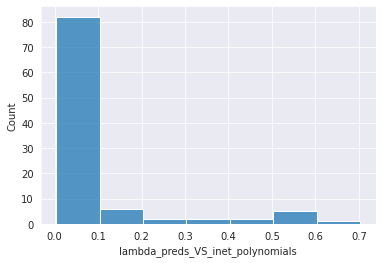

In [69]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

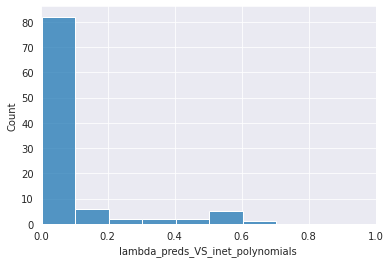

In [71]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


[(0.0, 1.0)]

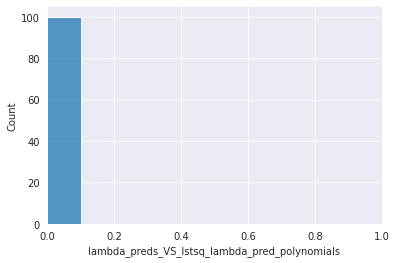

In [75]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


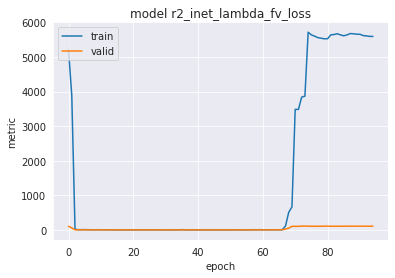

In [77]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    try:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    except:
        pass
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


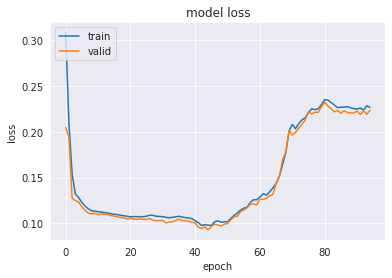

In [79]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [81]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [83]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [85]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [87]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


-0.0016*a**3 + 0.0026*a**2 - 0.1355*a - 0.1872

[-0.00156717  0.00264205 -0.13553554 -0.18724118]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.1772*a**3 - 0.4945*a**2 + 0.2191*a - 0.2497

[ 0.17723667 -0.49447368  0.2191118  -0.2496587 ]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.1772*a**3 - 0.4945*a**2 + 0.2191*a - 0.2497

[ 0.17723666 -0.49447366  0.2191118  -0.2496587 ]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-0.125*a**3 - 0.221399992704391

[-0.1250201  -0.22136208  0.27938354  0.26945674  0.24908274  0.20207691
  0.24928103  0.25487125  0.22921409  0.2666337 ]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
metamodel_functions


1/(1.00000000015586*exp(4.08826364818537e-9*X0**3 + 1.41276497735523e-8*X0**2 - 1.65124263865496e-9*X0) + 1)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


-(1.367*X0 + 0.313)/(3.73267326732673*X0 + 1.92946058091286)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
per_network_polynomials


-0.1199000030756*a**3 - 0.228699997067451

tf.Tensor(
[-0.22869956 -0.11990047  7.960468    7.530823    7.821873   12.244263
 12.490771   11.978285   11.738708    7.5609183 ], shape=(10,), dtype=float32)
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


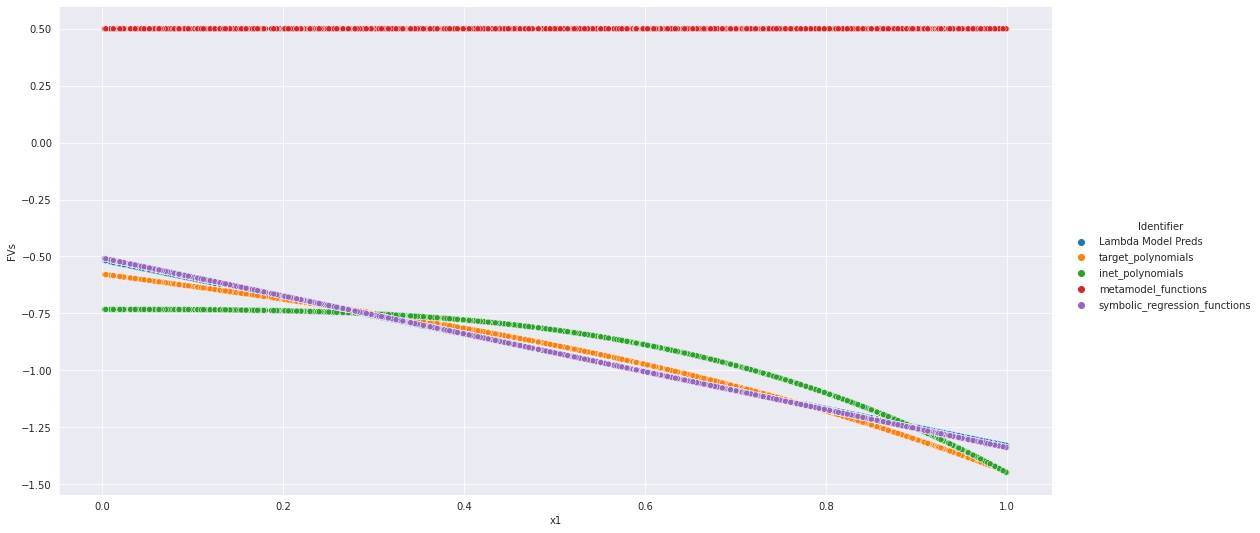

In [ ]:
from IPython.display import clear_output

for i in tqdm(range(100)):
    clear_output(wait=True)
    plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                          function_values_test_list, 
                                                          polynomial_dict_test_list,
                                                          rand_index=i, 
                                                          plot_type=1)

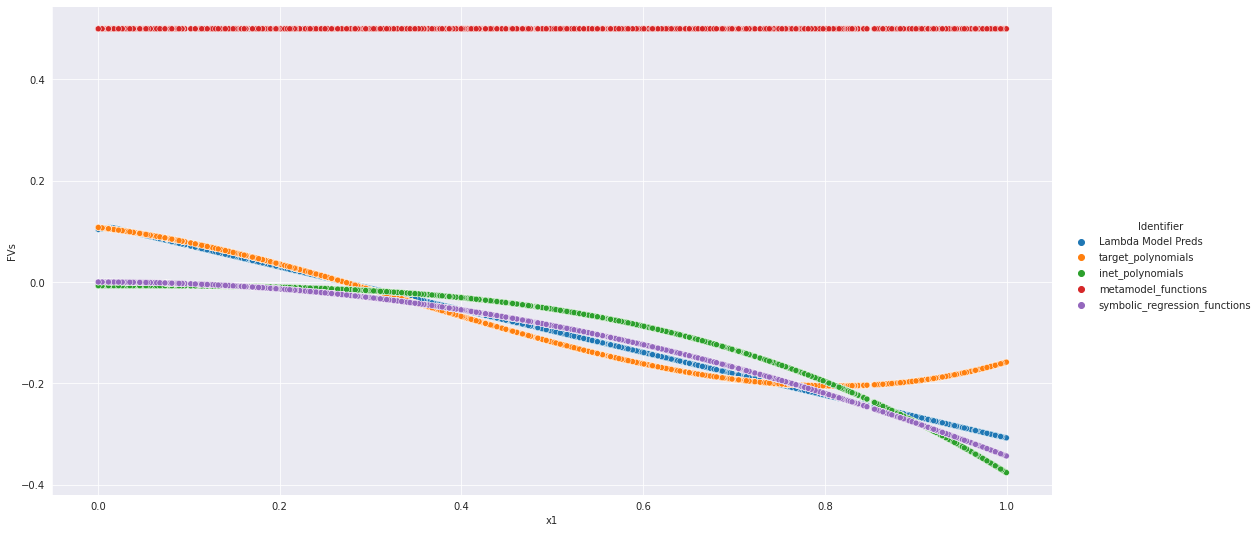

In [114]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

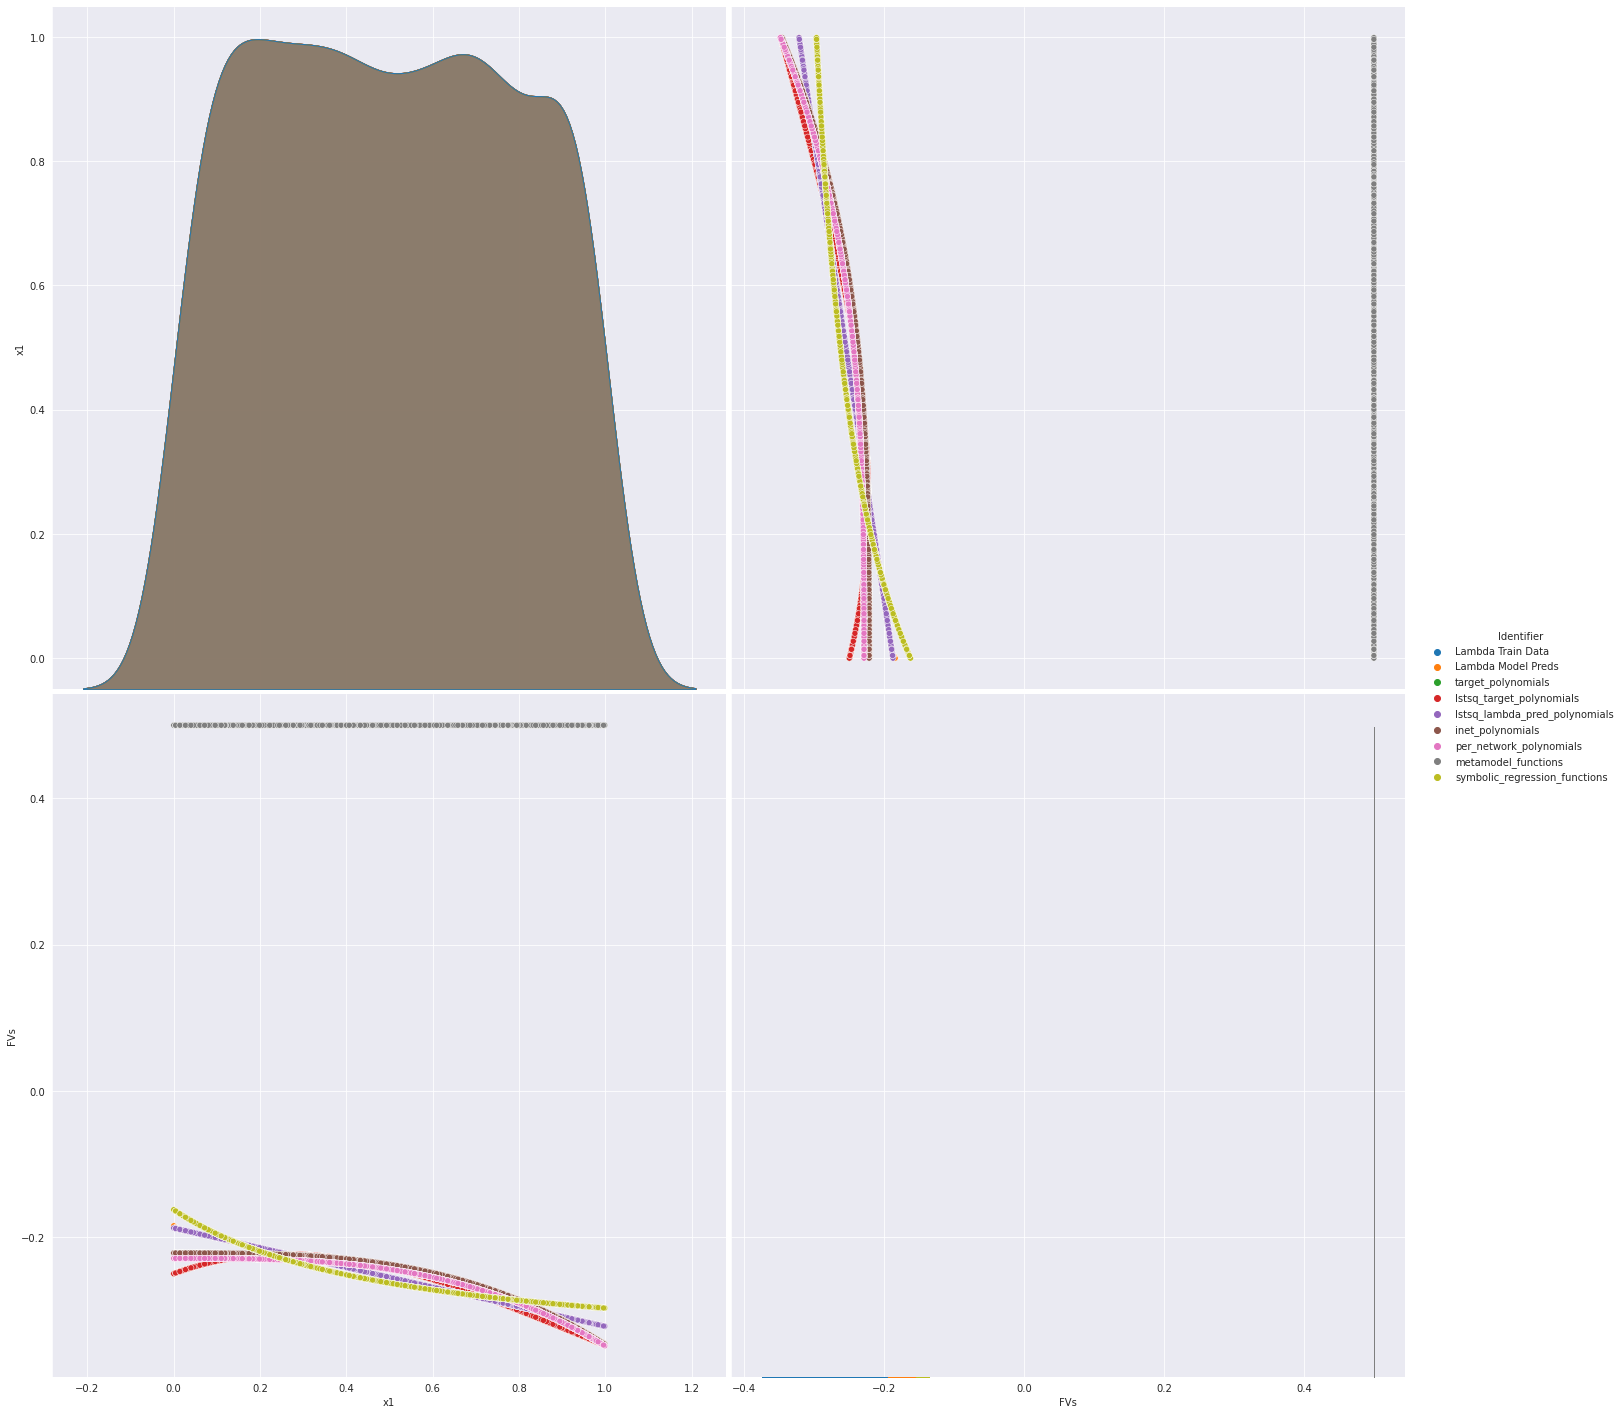

In [91]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

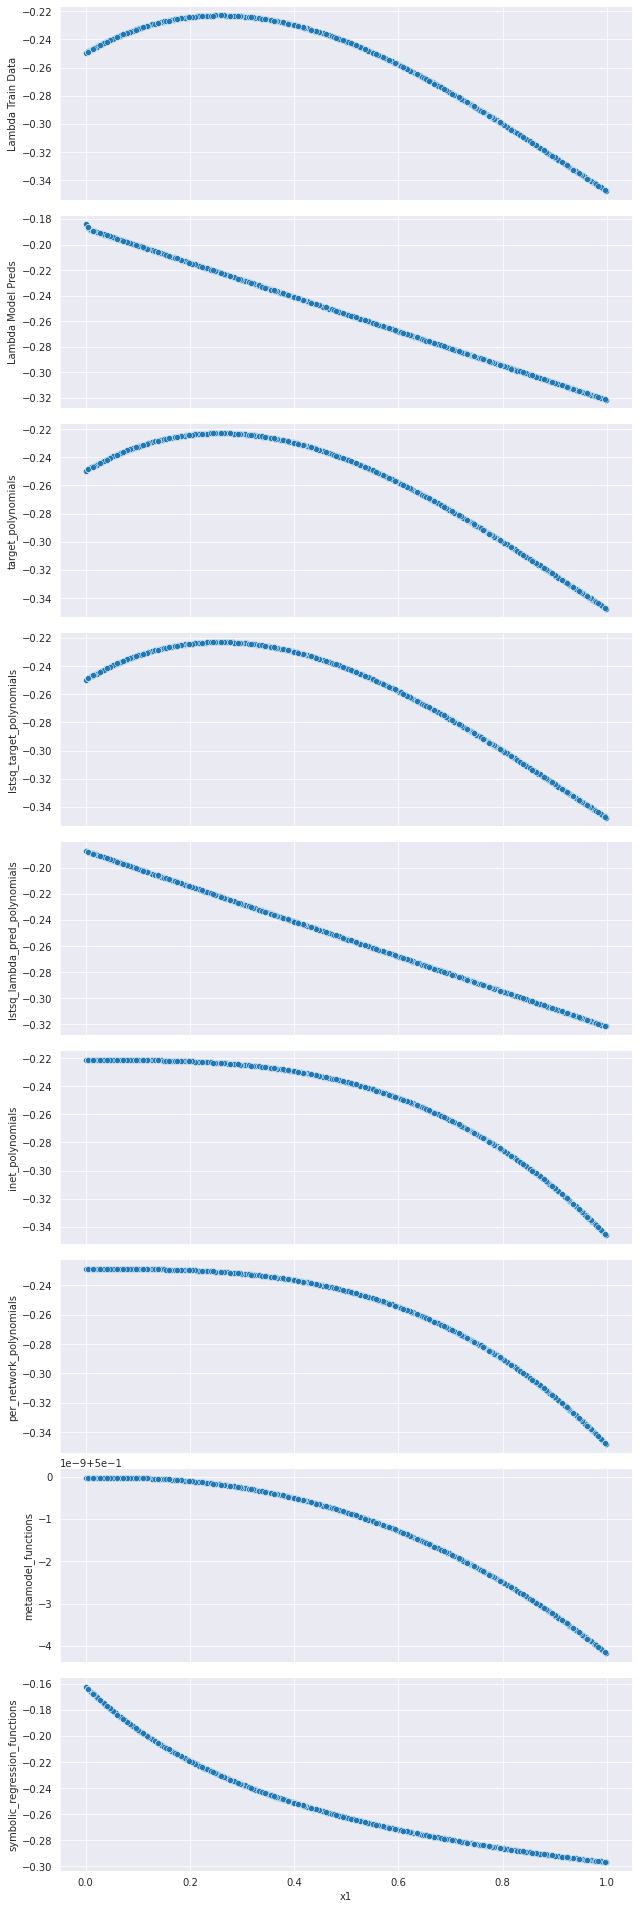

In [93]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()